In [13]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [14]:
def getCalibrationMatrix():

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "dist_pickle.p", "wb" ) )
    return (mtx, dist)

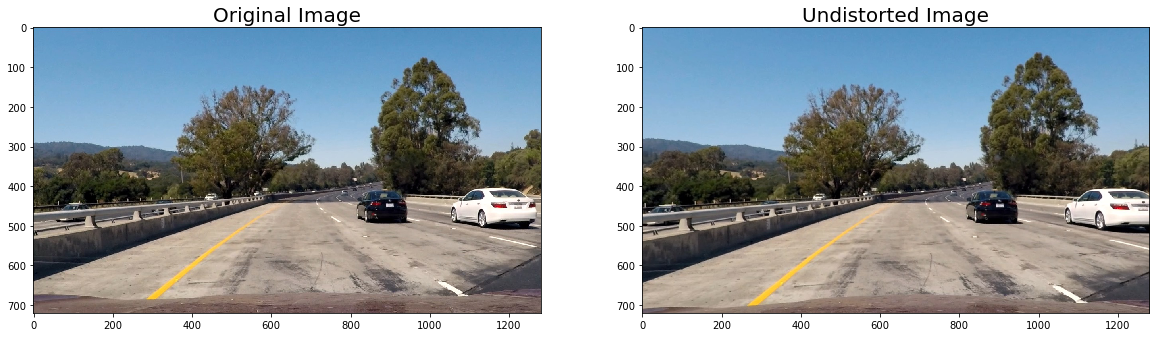

In [15]:
# Test undistortion on an image
img = mpimg.imread('test_images/test1.jpg')
img_size = (img.shape[1], img.shape[0])

mtx, dist = getCalibrationMatrix()
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)

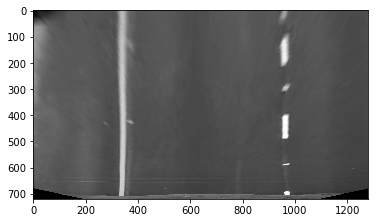

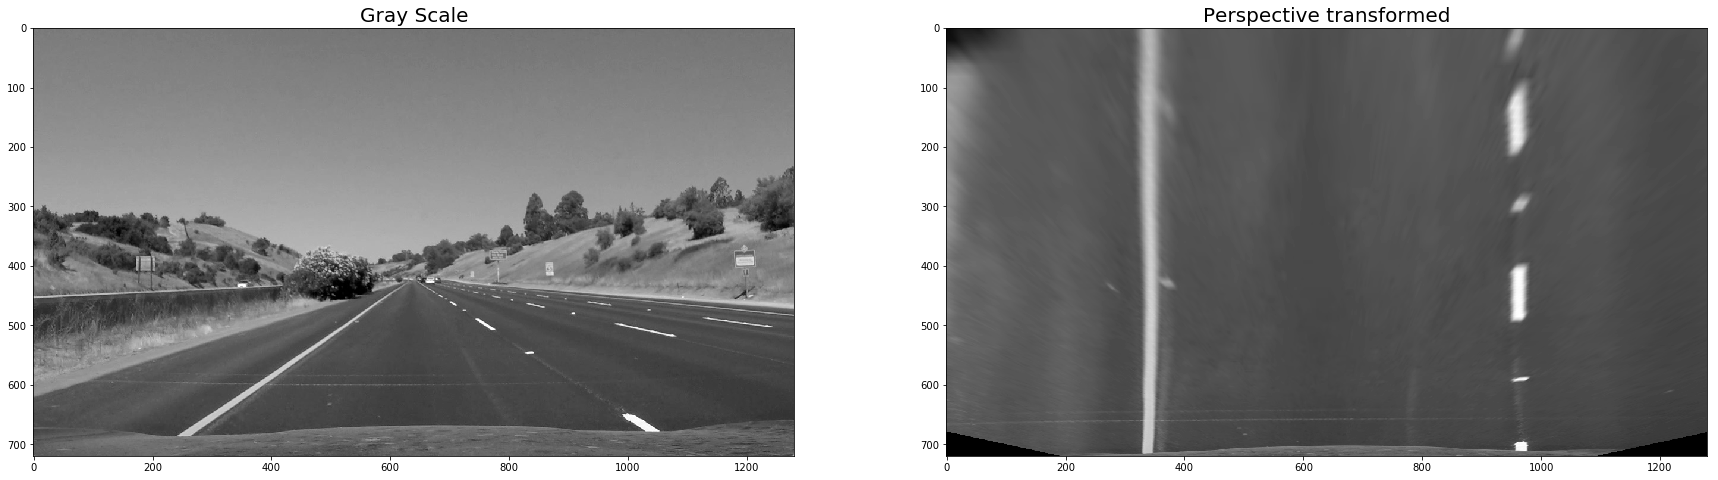

In [16]:
def getPerspectiveTransform():
    src = np.array([[582, 455], [700, 455], [1150, 720], [150, 720]], dtype = np.float32)
    dst = np.array([[300, 0], [1000, 0], [1000, 720], [300, 720]], dtype = np.float32)
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv


M, MInv = getPerspectiveTransform()


img = cv2.imread('test_images/straight_lines1.jpg')
img_size = (img.shape[1], img.shape[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
plt.imshow(warped, cmap='gray')

def undistort_image(image):
    global mtx, dist, M
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    return cv2.warpPerspective(dst, M, (image.shape[1], image.shape[0]))

plot_images(img, undistort_image(img), "Gray Scale", "Perspective transformed")

In [17]:
def togray(img):
#     img2 = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#     img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return (img[:,:,0])

def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    img = togray(img)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobel = np.uint8(sobel * 255 / np.max(sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(sobel)
    binary_output[(sobel >= thresh[0]) & (sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    img = togray(img)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, sobel_kernel)
    # 3) Calculate the magnitude 
    sobel = (sobelx ** 2 + sobely ** 2) ** 0.5
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobel = np.uint8(sobel * 255 / np.max(sobel))
    # 5) Create a binary mask where mag thresholds are met
    
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(sobel)
    binary_output[(sobel >= mag_thresh[0]) & (sobel <= mag_thresh[1])] = 1
    return binary_output
    

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    
    img = togray(img)
#     img = img[:,:,1]
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, sobel_kernel))
    dire = np.arctan2(sobely, sobelx)
    
    binary_output = np.zeros_like(dire)
    binary_output[(dire >= thresh[0]) & (dire <= thresh[1])] = 1
    binary_output[(dire >= -thresh[0]) & (dire <= -thresh[1])] = 1
    return binary_output

def color_threshold(img, thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_channel, s_binary    

In [18]:
def plot_images(img1, img2, t1, t2):
    # Visualize undistortion
#     plt.figure()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,20))
    ax1.imshow(img1, cmap='gray')
    ax1.set_title(t1, fontsize=20)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(t2, fontsize=20)

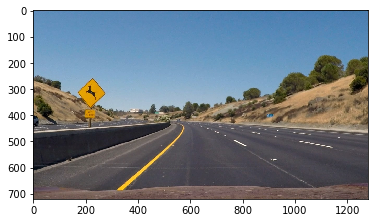

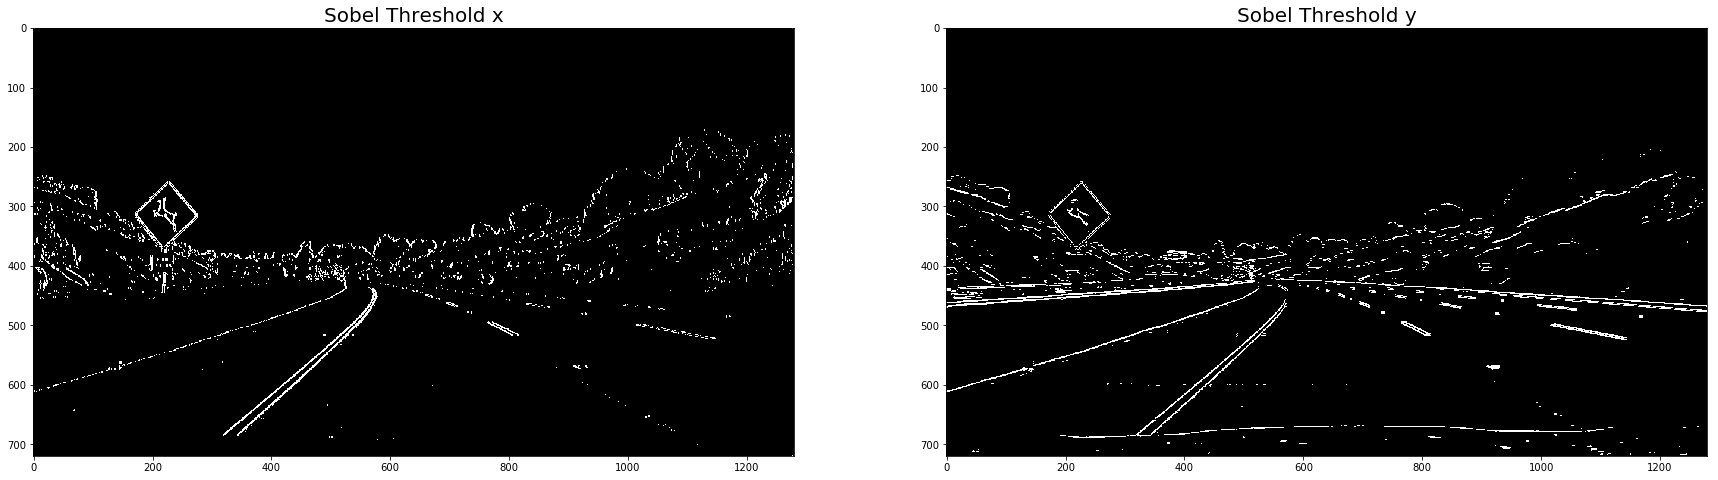

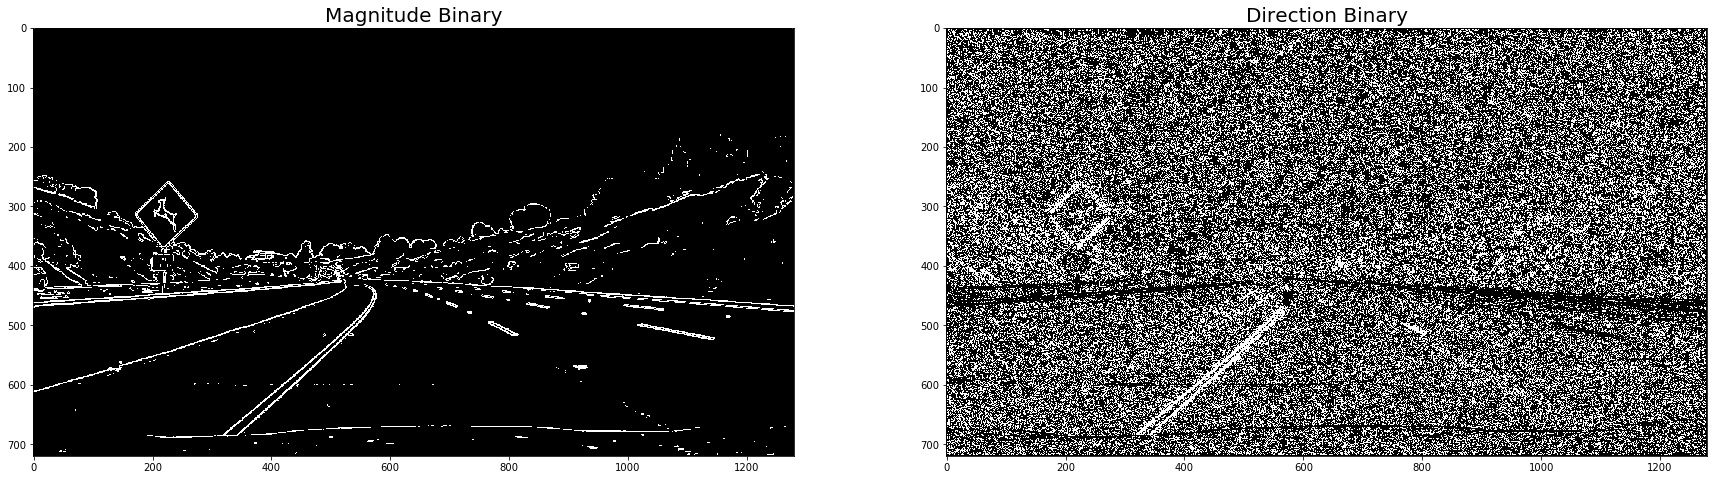

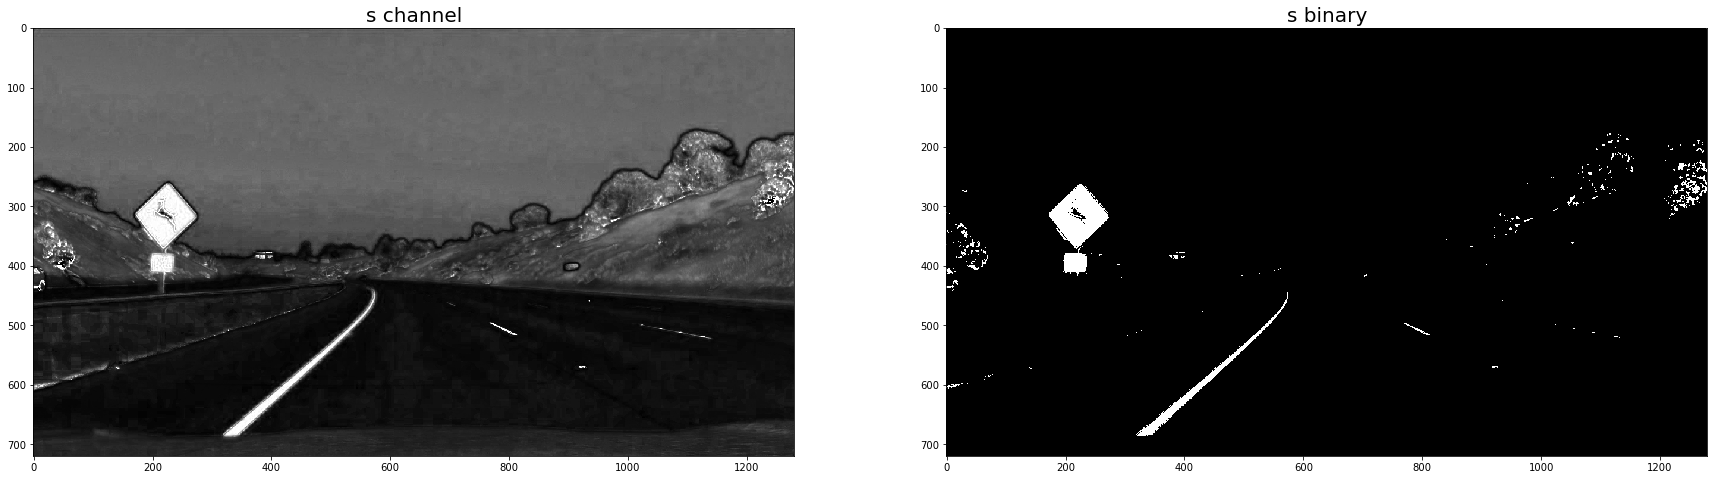

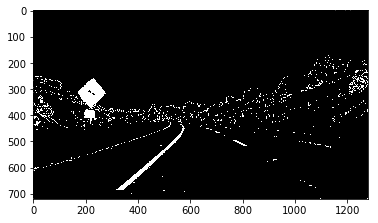

In [19]:

def show_image(image):
#     image = mpimg.imread(fname)
    plt.imshow(image)
    plt.figure()
    gradx = abs_sobel_thresh(image, orient='x', thresh=(40,250))
    grady = abs_sobel_thresh(image, orient='y', thresh=(50, 250))
    plot_images(gradx, grady, "Sobel Threshold x", "Sobel Threshold y")
    
    mag_binary = mag_thresh(image, sobel_kernel = ksize, mag_thresh=(50, 250))
    dir_binary = dir_threshold(image, thresh=(0.6, 1.2))
    
    plot_images(mag_binary, dir_binary, "Magnitude Binary", "Direction Binary")
    
    s_channel, s_binary = color_threshold(image, thresh=(160, 255))
    
    combined = np.zeros_like(dir_binary)
    combined[(s_binary == 1) | ((dir_binary == 1) & (mag_binary == 1)) | ((gradx == 1))] = 1
    
    plot_images(s_channel, s_binary, "s channel", "s binary")
    
    plt.figure()
    plt.imshow(combined, cmap='gray')
    combined = undistort_image(combined)
    
image = mpimg.imread('test_images/test2.jpg')
show_image(image)

In [20]:
ksize = 5

def process_image(image):
    
    gradx = abs_sobel_thresh(image, orient='x', thresh=(40,250))
    grady = abs_sobel_thresh(image, orient='y', thresh=(50, 250))
    mag_binary = mag_thresh(image, sobel_kernel = ksize, mag_thresh=(50, 250))
    dir_binary = dir_threshold(image, thresh=(0.6, 1.2))
    s_channel, s_binary = color_threshold(image, thresh=(160, 255))
    
    combined = np.zeros_like(dir_binary)
    combined[(s_binary == 1) | ((dir_binary == 1) & (mag_binary == 1)) | ((gradx == 1))] = 1
    plt.figure()
    combined = undistort_image(combined)
#     plt.imshow(combined, cmap='gray')
#     plt.figure()
    binary_warped = combined
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
        # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # Example values: 1926.74 1908.48
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    
    image_size = image.shape
    left_intercept = left_fit[0] * image_size[0] ** 2 + left_fit[1] * image_size[0] + left_fit[2]
    right_intercept = right_fit[0] * image_size[0] ** 2 + right_fit[1] * image_size[0] + right_fit[2]
    
    calculated_center = (left_intercept + right_intercept) / 2.0
    vehicle_position = (calculated_center - image_size[1] / 2.0) * xm_per_pix
    
    curvature_text = 'Left Curvature: {:.2f}m Right Curvature: {:.2f}m Position: {:.2f}m '.format(
                                                left_curverad, right_curverad, vehicle_position)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(combined).astype(np.uint8)
    
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, MInv, (image.shape[1], image.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    cv2.putText(result, curvature_text, (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
#     plt.imshow(result)
    return result

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


# %load_ext autoreload
# %autoreload 2
cnt = 0  # counter
output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

1753.71340237 1290.28627621
575.910371911 m 422.049928993 m
[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


  0%|          | 1/1261 [00:00<05:03,  4.15it/s]

1753.71340237 1290.28627621
575.910371911 m 422.049928993 m


  0%|          | 2/1261 [00:00<05:14,  4.01it/s]

1583.19618559 1755.25037908
519.38884684 m 575.718007424 m


  0%|          | 3/1261 [00:00<05:01,  4.17it/s]

1600.26927453 2496.80141668
525.225389169 m 809.061887385 m


  0%|          | 4/1261 [00:00<05:04,  4.13it/s]

1634.23235321 3249.79987434
536.547126693 m 1040.94793848 m


  0%|          | 5/1261 [00:01<04:48,  4.35it/s]

1676.98265414 3076.46764002
550.795245416 m 987.357970553 m


  0%|          | 6/1261 [00:01<04:54,  4.26it/s]

1664.68646894 2432.02569427
546.768753253 m 785.884866112 m


  1%|          | 7/1261 [00:01<04:44,  4.41it/s]

1748.85293252 2573.50022429
574.252085693 m 829.922649481 m


  1%|          | 8/1261 [00:01<04:53,  4.27it/s]

1736.06595306 4763.53080877
569.971364363 m 1477.7127383 m


  1%|          | 9/1261 [00:02<05:14,  3.98it/s]

1797.15809643 7036.98766054
589.59759748 m 2170.53352883 m


  1%|          | 10/1261 [00:02<05:09,  4.04it/s]

1826.2977301 2098.17339691
598.840369592 m 681.631758231 m


  1%|          | 11/1261 [00:02<04:55,  4.23it/s]

1987.9446664 1525.9014593
650.448515595 m 500.118506122 m


  1%|          | 12/1261 [00:02<04:57,  4.20it/s]

2076.93384768 1838.93136903
677.851165671 m 602.337525534 m


  1%|          | 13/1261 [00:03<04:44,  4.39it/s]

2248.76663619 1437.73144762
731.718094496 m 472.190347426 m
2057.46637609 1930.98382299
671.558092219 m 629.258235575 m


  1%|          | 15/1261 [00:03<04:29,  4.63it/s]

2045.8741573 2857.49895517
668.372207482 m 907.198918072 m


  1%|▏         | 16/1261 [00:03<04:40,  4.44it/s]

2171.25139131 2459.79254887
708.649610818 m 782.703594964 m


  1%|▏         | 17/1261 [00:03<04:33,  4.54it/s]

2167.71272589 2604.0577205
707.520270959 m 825.493062779 m


  1%|▏         | 18/1261 [00:04<04:42,  4.40it/s]

2218.46543873 2163.69943799
723.306479379 m 692.567320559 m


  2%|▏         | 19/1261 [00:04<04:56,  4.19it/s]

2284.77892993 2317.34725324
744.121004328 m 743.450556209 m


  2%|▏         | 20/1261 [00:04<04:49,  4.28it/s]

2256.98583672 2325.482768
735.073504725 m 748.86200387 m


  2%|▏         | 21/1261 [00:04<04:47,  4.31it/s]

2326.76560258 2845.43526546
757.040624949 m 912.323689189 m


  2%|▏         | 22/1261 [00:05<04:52,  4.24it/s]

2337.08309082 3073.22510805
760.039103202 m 987.246457042 m


  2%|▏         | 23/1261 [00:05<04:45,  4.33it/s]

2258.02642136 4493.42400154
735.623958193 m 1430.47489276 m
2113.91556608 1468.14608134
690.633648009 m 482.197836153 m


  2%|▏         | 25/1261 [00:05<04:36,  4.48it/s]

1928.50992658 1201.70911778
631.814576426 m 393.465992799 m


  2%|▏         | 26/1261 [00:05<04:31,  4.55it/s]

1977.69548413 1226.79474662
647.783366346 m 401.399887141 m
1849.72784767 1426.91908061
606.720526799 m 468.644135617 m


  2%|▏         | 28/1261 [00:06<04:21,  4.71it/s]

1945.56908332 1574.39029232
637.63534258 m 517.095796524 m
1902.8409505 1942.68043157
624.09175871 m 635.929930207 m


  2%|▏         | 30/1261 [00:06<04:12,  4.88it/s]

1703.8158427 2991.42157139
559.547322533 m 962.877932895 m


  2%|▏         | 31/1261 [00:07<04:16,  4.79it/s]

1588.81200065 3557.0104097
521.798230429 m 1131.80804245 m


  3%|▎         | 32/1261 [00:07<04:14,  4.82it/s]

1460.31175709 1962.02450503
479.037579891 m 636.03026681 m
1468.78576558 1908.24774292
481.913671632 m 621.789625097

  3%|▎         | 33/1261 [00:07<04:11,  4.88it/s]

 m
1406.28579273 3257.03564146
460.956217188 m 1028.63423743 m


  3%|▎         | 35/1261 [00:07<04:05,  4.99it/s]

1355.2631888 1699.52646391
443.927298606 m 555.148262763 m
1310.53682206 1005.77917667
429.173055268 m 328.400805774 m


  3%|▎         | 37/1261 [00:08<04:06,  4.97it/s]

1273.37874711 1202.80153604
416.728523927 m 395.040984434 m


  3%|▎         | 38/1261 [00:08<04:27,  4.57it/s]

1209.50083929 1358.25224185
395.140032764 m 444.297621904 m


  3%|▎         | 39/1261 [00:08<05:03,  4.02it/s]

1194.38013403 1780.92375149
390.210873846 m 572.131100644 m


  3%|▎         | 40/1261 [00:09<05:08,  3.96it/s]

1183.89650016 1993.25346752
387.062671013 m 637.304448474 m


  3%|▎         | 41/1261 [00:09<05:05,  4.00it/s]

1195.08411789 1684.52808317
391.078128736 m 544.358382714 m


  3%|▎         | 42/1261 [00:09<04:56,  4.11it/s]

1234.65781662 1682.72804605
404.818209031 m 544.14218751 m


  3%|▎         | 43/1261 [00:09<05:19,  3.81it/s]

1336.02165713 1511.49464484
438.789044864 m 492.052688777 m
1372.78357191 1599.83908732
450.892403325 m 520.977687533 m


  4%|▎         | 45/1261 [00:10<04:35,  4.41it/s]

1441.73409575 1779.51286907
473.338297796 m 577.429864833 m


  4%|▎         | 46/1261 [00:10<04:28,  4.52it/s]

1509.44008331 1777.77280261
495.169494888 m 577.821769454 m
1563.97646246

  4%|▎         | 47/1261 [00:10<04:23,  4.61it/s]

 2454.06889921
512.66575941 m 784.852828882 m


  4%|▍         | 48/1261 [00:10<04:24,  4.59it/s]

1650.62519101 1506.70456775
540.150876568 m 493.205090801 m


  4%|▍         | 49/1261 [00:11<04:18,  4.68it/s]

1783.25685678 1241.42402723
581.701549946 m 407.654718969 m


  4%|▍         | 50/1261 [00:11<04:24,  4.58it/s]

1856.41329054 1070.45647233
604.435666727 m 350.919606833 m


  4%|▍         | 51/1261 [00:11<04:25,  4.55it/s]

1962.89765767 1236.87873047
637.66531093 m 406.241739346 m


  4%|▍         | 52/1261 [00:11<04:28,  4.50it/s]

2044.42061941 1561.27868315
663.505918128 m 507.498675997 m


  4%|▍         | 53/1261 [00:11<04:30,  4.47it/s]

2063.12193564 1912.5365137
669.521855639 m 614.298941094 m


  4%|▍         | 54/1261 [00:12<04:34,  4.40it/s]

2067.81401162 2065.72745688
671.485100017 m 660.511227754 m


  4%|▍         | 55/1261 [00:12<04:33,  4.42it/s]

2444.64894198 2038.64399523
788.004982215 m 652.597566047 m


  4%|▍         | 56/1261 [00:12<04:33,  4.41it/s]

2507.01204595 2042.67402494
808.077345111 m 655.698198676 m


  5%|▍         | 57/1261 [00:12<04:33,  4.40it/s]

2411.4657595 2144.65541934
779.898821686 m 685.479119216 m


  5%|▍         | 58/1261 [00:13<04:23,  4.56it/s]

2341.58777838 3098.5035743
758.544523011 m 967.692539077 m


  5%|▍         | 59/1261 [00:13<04:20,  4.62it/s]

1990.49054704 1962.98291097
649.878011623 m 626.665146097 m


  5%|▍         | 60/1261 [00:13<04:29,  4.46it/s]

1854.40157791 1281.52710396
607.226191045 m 418.36362319 m


  5%|▍         | 61/1261 [00:13<04:23,  4.56it/s]

1843.04269778 1578.75340774
603.865395337 m 508.42704512 m
1765.07058719 2240.79016373
578.982636308 m 698.833390752 m


  5%|▍         | 63/1261 [00:14<04:17,  4.66it/s]

1742.10202306 2366.38703942
571.672993839 m 742.809761899 m


  5%|▌         | 64/1261 [00:14<04:21,  4.58it/s]

1725.57248318 2085.72923568
566.502606001 m 658.987727689 m


  5%|▌         | 65/1261 [00:14<04:24,  4.52it/s]

1788.81178189 2916.42053444
587.259388787 m 909.268658794 m


  5%|▌         | 66/1261 [00:14<04:19,  4.60it/s]

1866.5564258 2456.82795854
612.572329461 m 773.267795495 m


  5%|▌         | 67/1261 [00:15<04:53,  4.07it/s]

1901.72774934 2404.60974575
624.008279291 m 762.593266252 m


  5%|▌         | 68/1261 [00:15<05:09,  3.85it/s]

2091.06022552 2167.98851538
685.062406926 m 694.117446315 m


  5%|▌         | 69/1261 [00:15<04:57,  4.01it/s]

2127.40421694 2020.00600619
697.082984139 m 648.041349181 m


  6%|▌         | 70/1261 [00:15<04:55,  4.03it/s]

2242.09683918 1801.68360895
734.149340747 m 584.960996416 m


  6%|▌         | 71/1261 [00:16<05:04,  3.91it/s]

2320.72910588 1006.89422564
759.126244967 m 327.508494853 m


  6%|▌         | 72/1261 [00:16<04:46,  4.15it/s]

2360.77033682 941.783482372
772.232152203 m 303.8859728 m


  6%|▌         | 73/1261 [00:16<04:36,  4.30it/s]

2615.11098329 1050.57406046
853.308123643 m 342.765592767 m


  6%|▌         | 74/1261 [00:16<04:25,  4.46it/s]

2563.06736117 1186.03423765
836.876980856 m 389.280988304 m


  6%|▌         | 75/1261 [00:17<04:25,  4.47it/s]

2777.8446643 1328.20085874
904.772442593 m 436.25147667 m


  6%|▌         | 76/1261 [00:17<04:18,  4.59it/s]

2830.3176745 1605.32033029
921.615010355 m 524.515008176 m
3243.14463092

  6%|▌         | 77/1261 [00:17<04:17,  4.60it/s]

 1604.95080972
1051.73839817 m 526.242294995 m


  6%|▌         | 78/1261 [00:17<04:12,  4.68it/s]

3294.41215564 1849.74361899
1067.48700833 m 605.041997469 m


  6%|▋         | 79/1261 [00:17<04:15,  4.63it/s]

3368.5731249 2110.8896304
1091.33369737 m 689.104359935 m


  6%|▋         | 80/1261 [00:18<04:11,  4.70it/s]

3181.0630433 2439.39881088
1033.59777313 m 792.637633617 m
3365.17993134

  6%|▋         | 81/1261 [00:18<04:08,  4.74it/s]

 2357.16999361
1092.98255675 m 765.492193169 m


  7%|▋         | 82/1261 [00:18<04:15,  4.62it/s]

3439.53973906 2267.8910546
1117.60819629 m 738.38208404 m


  7%|▋         | 83/1261 [00:18<04:15,  4.61it/s]

2981.5703219 2319.77630566
973.333390929 m 753.914845556 m


  7%|▋         | 84/1261 [00:18<04:24,  4.45it/s]

2947.50073103 2806.38175075
962.254738644 m 910.040478879 m


  7%|▋         | 85/1261 [00:19<04:37,  4.23it/s]

2595.29508638 4214.38517699
850.077726751 m 1346.38325195 m


  7%|▋         | 86/1261 [00:19<04:40,  4.19it/s]

2379.79011815 4966.45991515
780.575553435 m 1583.05207012 m


  7%|▋         | 87/1261 [00:19<04:27,  4.39it/s]

2043.41405294 1248.80605648
671.158967293 m 409.20833369 m


  7%|▋         | 88/1261 [00:19<04:48,  4.07it/s]

1855.11153059 1547.19754904
608.634456303 m 507.244935933 m


  7%|▋         | 89/1261 [00:20<05:00,  3.90it/s]

1696.41898267 2256.14616481
555.470743456 m 727.104338096 m


  7%|▋         | 90/1261 [00:20<04:47,  4.07it/s]

1556.95328791 2146.53938389
508.005394358 m 689.545393235 m


  7%|▋         | 91/1261 [00:20<04:41,  4.16it/s]

1591.30086393 2089.56316239
519.411758537 m 675.793857762 m


  7%|▋         | 92/1261 [00:20<04:32,  4.29it/s]

1656.11320737 2059.44226118
541.802279939 m 667.914349869 m


  7%|▋         | 93/1261 [00:21<04:23,  4.44it/s]

1607.25082029 2120.8815129
525.455841118 m 686.354310325 m


  7%|▋         | 94/1261 [00:21<04:16,  4.54it/s]

1600.18133818 2039.88830175
523.3346973 m 660.753994866 m


  8%|▊         | 95/1261 [00:21<04:26,  4.38it/s]

1636.39874526 2036.56410836
535.792483801 m 662.542247039 m


  8%|▊         | 96/1261 [00:21<04:39,  4.16it/s]

1641.02350155 1893.92969768
537.468941247 m 618.319227258 m


  8%|▊         | 97/1261 [00:22<04:27,  4.36it/s]

1648.25022188 1111.53246987
540.100519317 m 361.986167064 m


  8%|▊         | 98/1261 [00:22<04:23,  4.41it/s]

1730.78467701 1085.79557766
567.761663296 m 351.767135927 m


  8%|▊         | 99/1261 [00:22<04:18,  4.50it/s]

1762.49698638 1107.54302234
578.399591771 m 361.173438509 m


  8%|▊         | 100/1261 [00:22<04:14,  4.56it/s]

1767.79220971 1168.14594899
580.115254212 m 381.879498993 m


  8%|▊         | 101/1261 [00:22<04:08,  4.66it/s]

1644.77591554 1428.89363801
539.185174282 m 469.319721576 m


  8%|▊         | 102/1261 [00:23<04:05,  4.73it/s]

1696.4860693 1749.51561307
556.392231607 m 572.559783149 m


  8%|▊         | 103/1261 [00:23<04:09,  4.65it/s]

1662.26346821 2279.45086184
545.052522383 m 739.951431541 m


  8%|▊         | 104/1261 [00:23<04:13,  4.57it/s]

1641.22565893 1892.22974672
538.08976929 m 618.962447029 m


  8%|▊         | 105/1261 [00:23<04:13,  4.56it/s]

1752.31923235 2480.67644401
575.233223261 m 807.322043044 m


  8%|▊         | 106/1261 [00:23<04:12,  4.58it/s]

1745.02345439 2409.1638826
572.916545238 m 786.316048387 m


  8%|▊         | 107/1261 [00:24<04:12,  4.56it/s]

1764.55331876 2042.54297827
579.423582881 m 669.752371988 m


  9%|▊         | 108/1261 [00:24<04:11,  4.59it/s]

1658.33195905 1949.25143033
544.025625438 m 638.605536506 m


  9%|▊         | 109/1261 [00:24<04:07,  4.65it/s]

1635.90796032 2462.86086522
536.572682782 m 801.579832846 m


  9%|▊         | 110/1261 [00:24<04:09,  4.62it/s]

1552.10450346 1801.65219663
508.414172282 m 591.201547754 m


  9%|▉         | 111/1261 [00:25<04:04,  4.71it/s]

1558.95925801 1176.89214085
510.80149301 m 382.853492472 m
1641.34594011 1212.24817844
538.53655378 m 393.000643677 m


  9%|▉         | 113/1261 [00:25<04:02,  4.72it/s]

1560.61175277 1108.48365763
511.445687704 m 359.590603091 m


  9%|▉         | 114/1261 [00:25<03:57,  4.82it/s]

1537.79100827 1208.7393047
503.767108662 m 395.439066626 m
1447.94071792 1596.82321269
473.499105988 m 523.382877212 m


  9%|▉         | 116/1261 [00:26<03:58,  4.80it/s]

1439.6081429 1537.41115431
470.497006926 m 504.081897319 m


  9%|▉         | 117/1261 [00:26<03:58,  4.80it/s]

1433.22959112 1491.55308428
468.801435649 m 489.335250539 m


  9%|▉         | 118/1261 [00:26<03:56,  4.83it/s]

1443.31023792 1579.59956832
472.4844502 m 517.546084094 m


  9%|▉         | 119/1261 [00:26<03:55,  4.85it/s]

1452.93518437 1538.3560194
475.920047561 m 504.016633978 m


 10%|▉         | 120/1261 [00:26<03:59,  4.76it/s]

1406.56821043 1534.91181305
460.328946495 m 501.658624463 m


 10%|▉         | 121/1261 [00:27<04:34,  4.15it/s]

1490.61994841 1312.73679444
488.796214255 m 431.076400092 m


 10%|▉         | 122/1261 [00:27<04:30,  4.21it/s]

1523.83623162 988.738925481
499.976488026 m 322.053046867 m


 10%|▉         | 123/1261 [00:27<04:26,  4.26it/s]

1391.07690891 999.711993537
455.583436643 m 327.156167592 m


 10%|▉         | 124/1261 [00:27<04:21,  4.34it/s]

1372.36513322 1147.12510182
449.242945717 m 376.772217516 m


 10%|▉         | 125/1261 [00:28<04:17,  4.41it/s]

1402.61957217 1377.00128077
459.634553741 m 449.811404182 m


 10%|▉         | 126/1261 [00:28<04:16,  4.43it/s]

1480.42533116 1300.35969825
485.849461669 m 426.602134156 m


 10%|█         | 127/1261 [00:28<04:16,  4.42it/s]

1453.1535806 1800.62493162
476.810411142 m 580.880663183 m
1489.4517555 1841.50646554
488.968612162 m 595.801836778 m


 10%|█         | 129/1261 [00:28<04:04,  4.63it/s]

1416.85650933 1855.18924974
464.931473213 m 596.140822454 m


 10%|█         | 130/1261 [00:29<03:59,  4.73it/s]

1533.82578336 1633.43695202
503.748205759 m 529.856226003 m


 10%|█         | 131/1261 [00:29<04:05,  4.60it/s]

1611.08491215 1656.39708554
529.140980665 m 536.428236111 m


 10%|█         | 132/1261 [00:29<04:02,  4.66it/s]

1619.14717719 1549.63311732
531.77458155 m 502.435795596 m


 11%|█         | 133/1261 [00:29<04:03,  4.64it/s]

1607.26288835 1376.1779478
527.893646802 m 449.713307479 m


 11%|█         | 134/1261 [00:30<03:56,  4.77it/s]

1646.1717706 1144.93205361
540.626563009 m 376.049357264 m


 11%|█         | 135/1261 [00:30<03:56,  4.76it/s]

1710.59793774 1103.58609435
561.607088815 m 362.424826587 m


 11%|█         | 136/1261 [00:30<03:58,  4.72it/s]

1711.13351323 1166.63572121
561.801340051 m 383.184954032 m


 11%|█         | 137/1261 [00:30<03:56,  4.75it/s]

1829.43628265 1396.64142005
600.213446421 m 457.725628581 m


 11%|█         | 138/1261 [00:30<04:05,  4.58it/s]

1929.65622854 1465.70333542
632.665705463 m 480.61951696 m


 11%|█         | 139/1261 [00:31<04:01,  4.65it/s]

1947.00820265 1915.6985348
638.306199523 m 622.358088168 m


 11%|█         | 140/1261 [00:31<04:06,  4.55it/s]

2151.36273752 2139.73663915
703.86634493 m 695.305584579 m


 11%|█         | 141/1261 [00:31<04:02,  4.61it/s]

2039.29552608 2630.69926092
668.093740338 m 845.929468971 m


 11%|█▏        | 142/1261 [00:31<04:07,  4.53it/s]

2122.03406925 4034.75557817
695.021094325 m 1279.36540139 m


 11%|█▏        | 143/1261 [00:32<04:02,  4.61it/s]

2137.16851371 2232.27304369
700.288151772 m 720.961830958 m


 11%|█▏        | 144/1261 [00:32<04:07,  4.52it/s]

2015.13483276 2217.86865567
660.953538399 m 717.399194153 m


 11%|█▏        | 145/1261 [00:32<03:59,  4.65it/s]

2143.57546299 2512.02098575
702.628867932 m 809.086962537 m
2038.47332525

 12%|█▏        | 146/1261 [00:32<03:58,  4.67it/s]

 1792.56638033
668.992214697 m 585.305682638 m


 12%|█▏        | 147/1261 [00:32<03:53,  4.78it/s]

2031.16203539 1344.04578844
666.652807905 m 441.321570938 m


 12%|█▏        | 148/1261 [00:33<03:57,  4.68it/s]

1857.70437296 1112.05045025
610.162834955 m 364.725505911 m


 12%|█▏        | 149/1261 [00:33<03:54,  4.75it/s]

1846.77978193 1531.48714309
606.581023793 m 499.692157035 m


 12%|█▏        | 150/1261 [00:33<03:58,  4.66it/s]

1859.18142976 1576.48536059
610.652708556 m 515.074367657 m


 12%|█▏        | 151/1261 [00:33<03:56,  4.70it/s]

1948.9461379 1915.46472739
640.028933387 m 622.15832573 m


 12%|█▏        | 152/1261 [00:33<03:56,  4.68it/s]

2023.70472013 2167.08469942
664.385977942 m 701.164372413 m
1923.30179011 3202.8134691
631.636134622 m 1013.37949985 m


 12%|█▏        | 154/1261 [00:34<03:49,  4.82it/s]

1964.13869611 2926.10123112
644.898858676 m 937.215710268 m


 12%|█▏        | 155/1261 [00:34<03:59,  4.62it/s]

2101.30562512 3887.34515074
689.118279195 m 1236.01159617 m


 12%|█▏        | 156/1261 [00:34<03:57,  4.66it/s]

2095.71946401 2852.87995424
687.290874923 m 917.794890442 m
2003.12847597 2323.97667638
657.247127434 m 752.569252845 m


 13%|█▎        | 158/1261 [00:35<03:45,  4.89it/s]

1865.44869497 1812.51030524
612.580496598 m 589.59483656 m


 13%|█▎        | 159/1261 [00:35<03:52,  4.75it/s]

1847.64437817 1795.54456625
606.712499808 m 584.862927796 m


 13%|█▎        | 160/1261 [00:35<03:56,  4.66it/s]

1733.51018764 1358.46977667
569.370820386 m 445.945523538 m


 13%|█▎        | 161/1261 [00:35<04:04,  4.50it/s]

1770.61922138 1273.55745898
581.474001033 m 418.30107497 m


 13%|█▎        | 162/1261 [00:36<04:04,  4.49it/s]

1784.89753371 1280.04685457
586.04729192 m 420.433761999 m


 13%|█▎        | 163/1261 [00:36<04:01,  4.56it/s]

1775.18931851 1394.85041389
582.798881846 m 458.109790507 m
1690.08041709 1932.23205321
555.028544798 m 626.88147729 m


 13%|█▎        | 165/1261 [00:36<03:51,  4.74it/s]

1688.86949342 1747.24753074
554.658501095 m 566.259094002 m


 13%|█▎        | 166/1261 [00:36<03:48,  4.78it/s]

1750.90481603 1817.75992763
574.842509532 m 588.772457307 m


 13%|█▎        | 167/1261 [00:37<03:52,  4.71it/s]

1633.89777318 1814.40989358
536.643250234 m 585.847730629 m


 13%|█▎        | 168/1261 [00:37<03:50,  4.73it/s]

1922.3972503 1956.08724428
629.737405165 m 633.063252603 m


 13%|█▎        | 169/1261 [00:37<03:58,  4.58it/s]

1961.4308799 2056.14224334
642.044280729 m 666.125529047 m


 13%|█▎        | 170/1261 [00:37<04:00,  4.54it/s]

2106.00927218 1744.94044307
687.91578984 m 570.7307195 m


 14%|█▎        | 171/1261 [00:37<03:57,  4.59it/s]

2126.23504535 1450.24492196
694.185614853 m 476.325209456 m


 14%|█▎        | 172/1261 [00:38<03:55,  4.63it/s]

2084.6473209 1115.77296954
680.997019301 m 363.781778672 m


 14%|█▎        | 173/1261 [00:38<03:48,  4.75it/s]

1895.86813842 836.182711371
621.145446973 m 263.498365188 m
1749.74258186 877.816676939
574.130443121 m 283.944282165 m


 14%|█▍        | 175/1261 [00:38<03:41,  4.90it/s]

1674.26896745 1023.59376578
549.71000932 m 336.095247833 m


 14%|█▍        | 176/1261 [00:39<03:47,  4.76it/s]

1616.85913682 995.842924359
531.004525855 m 327.036621786 m


 14%|█▍        | 177/1261 [00:39<03:48,  4.75it/s]

1693.03653843 1145.18656583
555.779122473 m 376.095776088 m


 14%|█▍        | 178/1261 [00:39<03:51,  4.67it/s]

1722.73118051 1288.02291106
565.400208312 m 422.263848309 m


 14%|█▍        | 179/1261 [00:39<03:48,  4.73it/s]

1628.04016489 1152.41729347
534.656185956 m 378.444191413 m
1669.29984992 1125.63258458


 14%|█▍        | 180/1261 [00:39<03:44,  4.81it/s]

548.114188356 m 369.717673923 m
1488.75903445

 14%|█▍        | 181/1261 [00:40<03:51,  4.66it/s]

 1198.22700793
488.841868527 m 392.871244327 m


 14%|█▍        | 182/1261 [00:40<03:45,  4.78it/s]

1502.77325321 1378.04192764
493.428598681 m 450.654090544 m
1417.02676154 1360.3894308
464.654071425 m 442.684779818 m


 15%|█▍        | 184/1261 [00:40<03:38,  4.92it/s]

1314.47185945 945.693714362
429.801998082 m 310.589647169 m


 15%|█▍        | 185/1261 [00:40<03:38,  4.92it/s]

1247.80138197 1032.85226826
406.814151599 m 338.530618386 m


 15%|█▍        | 186/1261 [00:41<03:42,  4.84it/s]

1125.02674936 1217.78449833
363.783223199 m 391.400129677 m


 15%|█▍        | 187/1261 [00:41<03:49,  4.68it/s]

1153.14256819 1747.0513227
373.785631557 m 542.122837127 m


 15%|█▍        | 188/1261 [00:41<03:50,  4.65it/s]

1137.42761985 1100.16127663
368.575831554 m 355.869749576 m


 15%|█▍        | 189/1261 [00:41<03:44,  4.77it/s]

1143.55330507 1154.24058976
370.952533386 m 372.511318891 m
1166.89486991 1637.04374313
379.608933324 m 512.202109958 m


 15%|█▌        | 191/1261 [00:42<03:37,  4.91it/s]

1155.41114675 1489.25290026
375.92694905 m 469.733061265 m


 15%|█▌        | 192/1261 [00:42<03:44,  4.77it/s]

1259.52539969 1455.47640294
412.244265341 m 462.648442134 m


 15%|█▌        | 193/1261 [00:42<03:43,  4.78it/s]

1221.2226523 1267.51882735
399.295505741 m 406.524275919 m


 15%|█▌        | 194/1261 [00:42<03:44,  4.76it/s]

1305.42296431 1427.27935128
427.983854328 m 455.032685145 m


 15%|█▌        | 195/1261 [00:43<03:44,  4.76it/s]

1317.27322203 1249.99410859
432.011839617 m 403.799236415 m


 16%|█▌        | 196/1261 [00:43<03:48,  4.65it/s]

1530.97322995 1051.76223984
502.819489588 m 345.453909648 m


 16%|█▌        | 197/1261 [00:43<03:43,  4.75it/s]

1733.36781116 1621.93852894
568.276072939 m 528.329372432 m
1875.73912008 2047.266126
613.369431341 m 665.828452796 m


 16%|█▌        | 199/1261 [00:43<03:40,  4.82it/s]

2007.61045718 3235.73809348
654.517404545 m 1043.44294444 m


 16%|█▌        | 200/1261 [00:44<03:46,  4.68it/s]

2029.54967883 1645.93990258
661.496968654 m 540.188928492 m


 16%|█▌        | 201/1261 [00:44<03:43,  4.75it/s]

2114.2366155 1362.16495917
688.25037088 m 446.942815527 m


 16%|█▌        | 202/1261 [00:44<03:48,  4.64it/s]

1907.9635729 1329.23561292
623.759203516 m 436.584906648 m


 16%|█▌        | 203/1261 [00:44<03:40,  4.79it/s]

1744.34368144 1536.68319772
571.855941982 m 502.750965247 m
1789.06763322 1869.20864135
586.169231601 m 606.709601534 m


 16%|█▋        | 205/1261 [00:45<03:35,  4.89it/s]

1754.87726412 1785.48958215
575.391550716 m 577.719671411 m


 16%|█▋        | 206/1261 [00:45<03:40,  4.78it/s]

1673.33257998 1575.73554639
549.093315365 m 512.37902721 m


 16%|█▋        | 207/1261 [00:45<03:39,  4.80it/s]

1467.35116726 1746.93666203
481.913665849 m 558.677008279 m
1422.22567763 1037.01284475
466.983783938 m 340.550929232 m


 17%|█▋        | 209/1261 [00:45<03:34,  4.90it/s]

1453.61812261 1119.04436794
477.373429169 m 367.323242921 m


 17%|█▋        | 210/1261 [00:46<03:42,  4.71it/s]

1524.27103742 1010.76757125
500.637392951 m 331.733598918 m


 17%|█▋        | 211/1261 [00:46<03:41,  4.73it/s]

1557.56930207 1180.13621368
511.477109684 m 387.574524638 m
1546.49359881 1239.04322377
507.840417279 m 406.566593777 m


 17%|█▋        | 213/1261 [00:46<03:34,  4.88it/s]

1497.14408475 1452.67418434
491.715810149 m 473.896331395 m


 17%|█▋        | 214/1261 [00:46<03:39,  4.77it/s]

1458.32199836 1819.42860565
478.989721365 m 585.191078561 m


 17%|█▋        | 215/1261 [00:47<03:34,  4.87it/s]

1471.72517321 2379.16508222
483.377377221 m 752.255385814 m


 17%|█▋        | 216/1261 [00:47<03:40,  4.74it/s]

1454.99738631 2909.11915183
477.882358133 m 912.518888459 m


 17%|█▋        | 217/1261 [00:47<03:38,  4.79it/s]

1529.52803278 2289.40561336
502.08517296 m 725.349633574 m


 17%|█▋        | 218/1261 [00:47<03:42,  4.68it/s]

1629.23636959 2519.12189633
534.063039748 m 799.956958206 m


 17%|█▋        | 219/1261 [00:48<03:40,  4.72it/s]

1611.94295998 2348.52013328
528.518801546 m 742.639021802 m


 17%|█▋        | 220/1261 [00:48<03:50,  4.52it/s]

1692.72301171 2602.99920355
554.044882772 m 826.335013213 m


 18%|█▊        | 221/1261 [00:48<03:47,  4.57it/s]

1715.3517909 3964.3254069
561.113444907 m 1225.17820175 m


 18%|█▊        | 222/1261 [00:48<03:44,  4.63it/s]

1737.28452805 1805.39673596
568.118993768 m 586.020498804 m


 18%|█▊        | 223/1261 [00:48<03:39,  4.73it/s]

1844.46779612 1346.77732315
601.946106572 m 441.979675011 m


 18%|█▊        | 224/1261 [00:49<03:44,  4.61it/s]

1787.88018305 1474.56475902
584.315206026 m 480.933392904 m


 18%|█▊        | 225/1261 [00:49<03:41,  4.67it/s]

1797.6100021 1636.78860728
587.580487896 m 531.343871315 m


 18%|█▊        | 226/1261 [00:49<03:44,  4.60it/s]

1834.7484776 2045.57051074
599.805096045 m 651.958636176 m


 18%|█▊        | 227/1261 [00:49<03:37,  4.75it/s]

1976.83592254 2035.49066003
644.718016634 m 651.333205782 m


 18%|█▊        | 228/1261 [00:49<03:39,  4.71it/s]

2044.17575466 2140.30094094
665.855206868 m 685.903174092 m
2125.80660255 2055.41527278
691.031367703 m 661.368881225 m


 18%|█▊        | 230/1261 [00:50<03:32,  4.85it/s]

2314.87522268 1974.45393164
749.655912976 m 639.828680831 m


 18%|█▊        | 231/1261 [00:50<03:38,  4.72it/s]

2280.84533725 1779.77624097
739.594268806 m 578.080107112 m


 18%|█▊        | 232/1261 [00:50<03:42,  4.62it/s]

2395.27854373 1825.77557114
774.904976524 m 594.775919377 m


 18%|█▊        | 233/1261 [00:51<03:44,  4.57it/s]

2298.1237677 2154.7596069
745.499971081 m 696.781322576 m


 19%|█▊        | 234/1261 [00:51<03:46,  4.54it/s]

2368.55181445 1466.58238166
767.548173081 m 481.106757752 m


 19%|█▊        | 235/1261 [00:51<03:42,  4.61it/s]

2285.63380251 997.205435368
742.224557587 m 324.671250548 m


 19%|█▊        | 236/1261 [00:51<03:40,  4.64it/s]

1955.11648277 1117.55247561
639.136219695 m 367.063794488 m


 19%|█▉        | 237/1261 [00:51<03:37,  4.71it/s]

1857.10876589 1348.39727559
607.932051018 m 440.800154534 m
1771.84329431 1130.4569859
580.814109594 m 371.015355394 m


 19%|█▉        | 239/1261 [00:52<03:32,  4.81it/s]

1703.67795898 1461.80098855
559.027278588 m 474.280463844 m


 19%|█▉        | 240/1261 [00:52<03:29,  4.87it/s]

1667.42182812 1342.34368305
547.314436647 m 437.555788763 m
1784.4040814 1367.53709525
585.093900721

 19%|█▉        | 241/1261 [00:52<03:28,  4.90it/s]

 m 445.713707324 m


 19%|█▉        | 242/1261 [00:52<03:29,  4.87it/s]

1899.39929648 1459.52201897
621.907281801 m 475.975600195 m
1755.98672098 1189.62392221
576.193376842 m 389.54871387 m


 19%|█▉        | 244/1261 [00:53<03:23,  4.99it/s]

1747.2470602 1456.06949402
573.35234736 m 474.017276158 m


 19%|█▉        | 245/1261 [00:53<03:24,  4.96it/s]

1732.61448616 1238.10873576
568.894885381 m 405.167975608 m
1666.37318011 1040.27654356
547.295995195 m

 20%|█▉        | 246/1261 [00:53<03:24,  4.97it/s]

 341.628925621 m
1668.23670215 1192.83039305
547.906265417 m 390.488358779 m


 20%|█▉        | 248/1261 [00:54<03:26,  4.90it/s]

1630.33324745 1348.35950749
535.486244432 m 436.829334865 m


 20%|█▉        | 249/1261 [00:54<03:31,  4.79it/s]

1685.14894118 1351.01350783
553.473006406 m 439.733571815 m
1693.59845735

 20%|█▉        | 250/1261 [00:54<03:27,  4.86it/s]

 1327.0605875
556.250134821 m 432.164277005 m
1752.59696387 1444.31529724
575.5579954 m 469.237395552 m


 20%|█▉        | 252/1261 [00:54<03:27,  4.87it/s]

1797.02268107 1598.209935
590.074744331 m 517.934584633 m
1861.29220831 1462.25396527
610.976533501 m 476.506761319 m


 20%|██        | 254/1261 [00:55<03:26,  4.87it/s]

1948.48902422 1592.04254564
639.23007675 m 518.646738949 m


 20%|██        | 255/1261 [00:55<03:39,  4.59it/s]

1948.44284141 1549.80841637
639.54676126 m 504.580714304 m


 20%|██        | 256/1261 [00:55<03:36,  4.65it/s]

1943.26571582 1405.79051103
637.935558275 m 460.149324523 m


 20%|██        | 257/1261 [00:56<03:38,  4.59it/s]

1949.38592795 930.69411777
640.146437688 m 301.82123672 m


 20%|██        | 258/1261 [00:56<03:50,  4.34it/s]

1904.99722053 941.348419491
625.702604253 m 306.256193099 m


 21%|██        | 259/1261 [00:56<03:46,  4.42it/s]

1844.10814887 1167.61216504
605.6577875 m 383.468416962 m


 21%|██        | 260/1261 [00:56<03:59,  4.18it/s]

1815.54814384 1517.30244393
596.132787775 m 494.838906801 m


 21%|██        | 261/1261 [00:57<04:09,  4.00it/s]

1951.35232342 1488.60445244
640.928109385 m 487.933212352 m


 21%|██        | 262/1261 [00:57<04:17,  3.88it/s]

1964.56883831 1530.58423026
645.252922982 m 500.802735514 m


 21%|██        | 263/1261 [00:57<04:08,  4.02it/s]

1902.42715164 1668.86953813
624.714551805 m 545.299501596 m


 21%|██        | 264/1261 [00:57<04:10,  3.98it/s]

1900.41784538 1674.94770534
623.938183452 m 548.21963899 m


 21%|██        | 265/1261 [00:58<04:25,  3.75it/s]

1932.37251553 1797.66839793
634.537058595 m 587.597726139 m


 21%|██        | 266/1261 [00:58<04:28,  3.71it/s]

2071.86139768 1862.06524278
680.506310508 m 609.673270076 m


 21%|██        | 267/1261 [00:58<04:35,  3.61it/s]

1920.02037104 1745.12875778
630.320689347 m 571.672321862 m


 21%|██▏       | 268/1261 [00:58<04:32,  3.64it/s]

1913.24031462 1838.21553127
628.068738363 m 602.375692373 m


 21%|██▏       | 269/1261 [00:59<04:51,  3.41it/s]

2031.76808201 2130.64593138
667.249796771 m 696.711947875 m


 21%|██▏       | 270/1261 [00:59<04:48,  3.43it/s]

2033.20277106 1405.97522224
667.545614983 m 461.320043601 m


 21%|██▏       | 271/1261 [00:59<04:43,  3.49it/s]

2022.25103372 1159.34631027
663.809286831 m 377.938375191 m


 22%|██▏       | 272/1261 [01:00<04:40,  3.52it/s]

1913.14348767 1677.66066126
627.202568311 m 548.570075062 m


 22%|██▏       | 273/1261 [01:00<04:42,  3.49it/s]

2019.5193091 2089.96819101
662.518670824 m 678.443041415 m


 22%|██▏       | 274/1261 [01:00<04:43,  3.48it/s]

1972.47376391 2541.68149068
646.339617457 m 813.199184348 m


 22%|██▏       | 275/1261 [01:00<04:30,  3.64it/s]

2010.73558272 3111.30925481
659.253060681 m 992.072102051 m


 22%|██▏       | 276/1261 [01:01<04:19,  3.80it/s]

2213.28137435 2833.83858527
726.602421937 m 913.332874824 m


 22%|██▏       | 277/1261 [01:01<04:17,  3.82it/s]

2376.03483284 2573.59264978
780.377423886 m 835.08793287 m


 22%|██▏       | 278/1261 [01:01<04:11,  3.91it/s]

2427.94270388 2544.66969472
797.461686208 m 828.656203746 m


 22%|██▏       | 279/1261 [01:01<04:04,  4.02it/s]

2432.14132479 2467.30173486
798.765408278 m 802.613253254 m


 22%|██▏       | 280/1261 [01:02<03:51,  4.23it/s]

2587.48980911 2261.04265591
849.857831554 m 737.959399343 m


 22%|██▏       | 281/1261 [01:02<03:47,  4.30it/s]

2717.27532391 1350.00258794
892.498448102 m 441.940360418 m


 22%|██▏       | 282/1261 [01:02<03:53,  4.19it/s]

2758.98373828 1330.86728148
906.149461629 m 436.085147826 m


 22%|██▏       | 283/1261 [01:02<03:57,  4.11it/s]

2986.61159555 1412.30672044
980.93513533 m 462.776656853 m


 23%|██▎       | 284/1261 [01:03<04:08,  3.93it/s]

2858.81472861 1799.60383678
938.96386875 m 590.738931388 m


 23%|██▎       | 285/1261 [01:03<04:00,  4.06it/s]

2882.5195247 2107.9668696
946.759766561 m 691.45239763 m


 23%|██▎       | 286/1261 [01:03<04:01,  4.04it/s]

3226.87669279 2716.69357862
1059.73405402 m 888.178937868 m


 23%|██▎       | 287/1261 [01:03<04:17,  3.78it/s]

3230.39725623 3739.28949278
1061.01387325 m 1214.91608025 m


 23%|██▎       | 288/1261 [01:04<04:08,  3.91it/s]

3328.62524354 3917.01918403
1093.25506993 m 1276.14463931 m


 23%|██▎       | 289/1261 [01:04<04:10,  3.88it/s]

3296.81866866 3038.43668758
1082.81504173 m 993.291239847 m


 23%|██▎       | 290/1261 [01:04<03:54,  4.15it/s]

3669.36097761 2771.04216707
1205.16732317 m 907.973909641 m


 23%|██▎       | 291/1261 [01:04<03:47,  4.26it/s]

3623.37323824 1917.914255
1190.04485217 m 629.907305703 m


 23%|██▎       | 292/1261 [01:05<03:42,  4.35it/s]

3529.94477875 1619.60017159
1159.1476467 m 531.454078853 m


 23%|██▎       | 293/1261 [01:05<03:43,  4.34it/s]

3598.55841316 1327.64086555
1181.67435844 m 430.882061238 m


 23%|██▎       | 294/1261 [01:05<03:45,  4.29it/s]

4044.62083952 1472.82930011
1328.41078023 m 481.831037926 m


 23%|██▎       | 295/1261 [01:05<03:42,  4.34it/s]

3706.09289772 1642.21690234
1217.05722212 m 538.62746437 m


 23%|██▎       | 296/1261 [01:05<03:34,  4.49it/s]

3638.90315644 2748.60184401
1194.73629335 m 896.415254444 m


 24%|██▎       | 297/1261 [01:06<03:37,  4.43it/s]

3891.32591092 3290.25289461
1278.02083898 m 1069.55809678 m


 24%|██▎       | 298/1261 [01:06<03:32,  4.54it/s]

3574.89879578 4507.48411314
1173.90680492 m 1456.23981365 m


 24%|██▎       | 299/1261 [01:06<03:31,  4.54it/s]

4003.21181342 5259.66638327
1314.86857147 m 1698.37717526 m


 24%|██▍       | 300/1261 [01:06<03:25,  4.67it/s]

4078.0221667 7118.46442756
1339.41232107 m 2296.31564291 m


 24%|██▍       | 301/1261 [01:07<03:41,  4.33it/s]

4744.09588017 6074.81618499
1557.64670539 m 1961.97950862 m


 24%|██▍       | 302/1261 [01:07<03:38,  4.39it/s]

5475.04298877 10627.857855
1795.18873656 m 3427.14601852 m


 24%|██▍       | 303/1261 [01:07<03:33,  4.49it/s]

5436.27735088 4930.59748999
1783.03792836 m 1603.19070315 m


 24%|██▍       | 304/1261 [01:07<03:36,  4.41it/s]

5329.63644634 5111.70871858
1748.80711316 m 1657.77481889 m


 24%|██▍       | 305/1261 [01:08<03:38,  4.38it/s]

5666.21120223 6369.01740619
1858.03690977 m 2062.83192775 m
6830.19314094 3199.2757402
2240.64553884 m 1045.19232555 m


 24%|██▍       | 307/1261 [01:08<03:25,  4.65it/s]

6539.86905829 3479.48233253
2145.08723784 m 1138.96224065 m
6400.41035344 7438.49706396
2101.69360982 m 2386.82109042 m

 24%|██▍       | 308/1261 [01:08<03:22,  4.70it/s]

 25%|██▍       | 309/1261 [01:08<03:28,  4.57it/s]

8686.64514693 11558.7698496
2851.01352041 m 3700.91167927 m


 25%|██▍       | 310/1261 [01:09<03:32,  4.47it/s]

8171.08324289 95514.1378681
2683.35058405 m 30169.1330846 m


 25%|██▍       | 311/1261 [01:09<03:29,  4.54it/s]

10299.3279284 16659.6635547
3382.28279525 m 5225.42505076 m


 25%|██▍       | 312/1261 [01:09<03:31,  4.49it/s]

15022.3882754 17505.1677935
4932.30298423 m 5611.29942238 m


 25%|██▍       | 313/1261 [01:09<03:29,  4.53it/s]

19141.7128069 4179.52432769
6286.941319 m 1358.4169504 m


 25%|██▍       | 314/1261 [01:09<03:26,  4.59it/s]

28895.7079278 3871.01556426
9488.81793982 m 1264.73066991 m


 25%|██▍       | 315/1261 [01:10<03:29,  4.53it/s]

68326.6342162 3030.24481201
22430.6418488 m 994.098573397 m


 25%|██▌       | 316/1261 [01:10<03:32,  4.45it/s]

119634.921935 3122.56358154
39258.0263111 m 1025.30131379 m


 25%|██▌       | 317/1261 [01:10<03:40,  4.28it/s]

95143.8073133 2114.88033092
31217.6487806 m 689.280587344 m


 25%|██▌       | 318/1261 [01:10<03:35,  4.38it/s]

327224.250553 3588.76131017
107467.444169 m 1177.51621457 m


 25%|██▌       | 319/1261 [01:11<03:32,  4.43it/s]

52782.6120865 4675.81954233
17333.1940499 m 1532.16428418 m


 25%|██▌       | 320/1261 [01:11<03:29,  4.49it/s]

126323.504741 7577.87438157
41491.3568079 m 2468.75534065 m


 25%|██▌       | 321/1261 [01:11<03:30,  4.46it/s]

51718.4449008 7224.20911945
16986.0034156 m 2360.22737971 m


 26%|██▌       | 322/1261 [01:11<03:29,  4.48it/s]

36844.7051157 7300.70208428
12100.9582263 m 2385.8197292 m


 26%|██▌       | 323/1261 [01:12<03:35,  4.36it/s]

180686.399063 5736.75757793
59344.1953114 m 1879.01198268 m


 26%|██▌       | 324/1261 [01:12<03:43,  4.19it/s]

45623.3382648 6104.0361565
14982.4332297 m 2002.52944949 m


 26%|██▌       | 325/1261 [01:12<04:00,  3.89it/s]

83265.3037887 5611.99194044
27348.5511846 m 1841.05982557 m


 26%|██▌       | 326/1261 [01:12<03:58,  3.92it/s]

18303.9080438 4674.24421502
6010.09196566 m 1534.55836507 m


 26%|██▌       | 327/1261 [01:13<04:03,  3.84it/s]

24523.2211912 6240.7972113
8052.44521145 m 2047.87700284 m


 26%|██▌       | 328/1261 [01:13<03:51,  4.03it/s]

20388.9225034 4250.93067181
6694.69153733 m 1396.22731111 m


 26%|██▌       | 329/1261 [01:13<03:42,  4.19it/s]

27758.3229966 8756.45684192
9112.38606143 m 2873.02983323 m


 26%|██▌       | 330/1261 [01:13<03:39,  4.25it/s]

99292.449613 2859.01496985
32612.9182191 m 936.093985731 m


 26%|██▌       | 331/1261 [01:13<03:34,  4.33it/s]

54065.3515929 3867.06040521
17757.0980697 m 1270.10179706 m


 26%|██▋       | 332/1261 [01:14<03:32,  4.37it/s]

53180.552228 20184.4483562
17456.4868823 m 6464.12360837 m


 26%|██▋       | 333/1261 [01:14<03:36,  4.29it/s]

61247.9587065 7718.01522621
20075.365606 m 2444.08307621 m


 26%|██▋       | 334/1261 [01:14<03:31,  4.38it/s]

286891.117385 13179.1378123
94119.4737064 m 4226.32211933 m


 27%|██▋       | 335/1261 [01:14<03:29,  4.43it/s]

251019.516671 14450.589132
82363.2497509 m 4705.37718347 m


 27%|██▋       | 336/1261 [01:15<03:24,  4.51it/s]

112675.597726 12826.699773
36997.6549206 m 4155.0303547 m


 27%|██▋       | 337/1261 [01:15<03:24,  4.52it/s]

75989.4043352 42088.3549636
24948.9928627 m 13704.5393656 m


 27%|██▋       | 338/1261 [01:15<03:26,  4.48it/s]

29774.3141042 41120.5089016
9779.31936418 m 13400.1585294 m


 27%|██▋       | 339/1261 [01:15<03:23,  4.53it/s]

24472.8368267 11679.6984548
8038.11766172 m 3827.27571449 m
16432.4205392 6252.00526833
5397.24948688

 27%|██▋       | 340/1261 [01:15<03:19,  4.61it/s]

 m 2051.46368527 m


 27%|██▋       | 341/1261 [01:16<03:22,  4.54it/s]

21559.8534054 4275.5101106
7081.00068079 m 1404.20830064 m


 27%|██▋       | 342/1261 [01:16<03:22,  4.54it/s]

25958.8611124 12247.3737753
8520.70114002 m 3989.94763058 m


 27%|██▋       | 343/1261 [01:16<03:30,  4.35it/s]

38402.4103547 21551.1046538
12607.5188624 m 7023.39266279 m


 27%|██▋       | 344/1261 [01:16<03:23,  4.50it/s]

38956.2950456 35403.8540211
12792.7888714 m 11543.6567586 m


 27%|██▋       | 345/1261 [01:17<03:19,  4.59it/s]

75404.3395566 27530.3686366
24762.2604509 m 8996.89813281 m


 27%|██▋       | 346/1261 [01:17<03:19,  4.58it/s]

141758.572569 28116.9461811
46553.5801689 m 9162.46257566 m


 28%|██▊       | 347/1261 [01:17<03:17,  4.62it/s]

17566.0828607 15488.887308
5761.61157766 m 5032.06121596 m


 28%|██▊       | 348/1261 [01:17<03:23,  4.49it/s]

16396.6365746 42064.894003
5380.45393497 m 13746.8429164 m


 28%|██▊       | 349/1261 [01:17<03:22,  4.51it/s]

15160.3398755 152227.670401
4971.53431201 m 49742.1201802 m


 28%|██▊       | 350/1261 [01:18<03:21,  4.52it/s]

25618.3969028 53364.5588396
8410.96840176 m 17488.8918459 m


 28%|██▊       | 351/1261 [01:18<03:19,  4.55it/s]

14915.1591661 9010.63342413
4893.38382655 m 2931.51392955 m


 28%|██▊       | 352/1261 [01:18<03:24,  4.45it/s]

11334.5757076 4754.5984165
3716.32100476 m 1560.22579464 m


 28%|██▊       | 353/1261 [01:18<03:21,  4.51it/s]

10002.8750658 5358.58578652
3280.72494238 m 1755.98516686 m


 28%|██▊       | 354/1261 [01:19<03:19,  4.55it/s]

10250.4383024 2381.61424691
3360.73949883 m 765.998593717 m


 28%|██▊       | 355/1261 [01:19<03:20,  4.52it/s]

9099.42858374 3383.06088448
2982.87899096 m 1102.96707247 m


 28%|██▊       | 356/1261 [01:19<03:23,  4.45it/s]

11206.9383396 2835.42451794
3675.46629885 m 921.43439487 m


 28%|██▊       | 357/1261 [01:19<03:19,  4.53it/s]

13756.0526464 7014.55627473
4510.72549088 m 2303.88306274 m


 28%|██▊       | 358/1261 [01:19<03:23,  4.44it/s]

62690.36324 15742.9944787
20588.9219892 m 5164.87506411 m


 28%|██▊       | 359/1261 [01:20<03:45,  4.00it/s]

13254.4711246 8910.16981697
4352.24249069 m 2885.24430276 m


 29%|██▊       | 360/1261 [01:20<03:40,  4.08it/s]

11533.639022 82412.9411102
3785.42481232 m 26978.2745858 m


 29%|██▊       | 361/1261 [01:20<03:59,  3.76it/s]

8825.50703472 14250.6127418
2894.74675344 m 4676.60565393 m


 29%|██▊       | 362/1261 [01:21<03:52,  3.87it/s]

5315.14868577 5896.24732064
1739.39719816 m 1936.64251524 m


 29%|██▉       | 363/1261 [01:21<03:39,  4.10it/s]

4292.52058304 6228.26837714
1400.34775083 m 2045.66477447 m


 29%|██▉       | 364/1261 [01:21<03:33,  4.19it/s]

3574.53781817 3944.9903311
1166.7645515 m 1295.47064465 m


 29%|██▉       | 365/1261 [01:21<03:25,  4.37it/s]

3440.82454181 3637.67047009
1121.34670047 m 1192.45698679 m


 29%|██▉       | 366/1261 [01:22<03:37,  4.11it/s]

3407.90395697 8043.49832966
1111.48825181 m 2639.07976136 m


 29%|██▉       | 367/1261 [01:22<03:34,  4.16it/s]

3456.87608291 8182.83688078
1128.05451637 m 2685.80789558 m


 29%|██▉       | 368/1261 [01:22<03:37,  4.10it/s]

3592.55073141 11747.3140949
1172.44123587 m 3855.07546383 m


 29%|██▉       | 369/1261 [01:22<03:29,  4.25it/s]

4233.34955353 10390.0847201
1387.51980413 m 3365.51306138 m


 29%|██▉       | 370/1261 [01:22<03:28,  4.28it/s]

4358.14741487 10002.480044
1428.26536616 m 3246.52640283 m


 29%|██▉       | 371/1261 [01:23<03:28,  4.27it/s]

5021.37437626 12690.0913057
1648.05674056 m 4125.10589708 m


 30%|██▉       | 372/1261 [01:23<03:28,  4.27it/s]

6081.2013803 8523.06619251
1996.73587259 m 2772.38765862 m


 30%|██▉       | 373/1261 [01:23<03:28,  4.26it/s]

6342.83441993 24669.9374573
2082.71501412 m 8069.00389189 m


 30%|██▉       | 374/1261 [01:23<03:28,  4.25it/s]

9602.33413864 109136.38381
3153.499331 m 35711.5378837 m


 30%|██▉       | 375/1261 [01:24<03:30,  4.21it/s]

14496.547003 10937.5222355
4756.31634163 m 3589.77852844 m


 30%|██▉       | 376/1261 [01:24<03:33,  4.15it/s]

29233.9590822 7958.52420824
9562.14153974 m 2611.21966176 m


 30%|██▉       | 377/1261 [01:24<03:34,  4.12it/s]

143605.242221 5696.47363801
46905.0040974 m 1871.02569295 m


 30%|██▉       | 378/1261 [01:24<03:30,  4.19it/s]

32865.5334096 12899.2318604
10704.5835545 m 4224.89294364 m


 30%|███       | 379/1261 [01:25<03:37,  4.06it/s]

17044.2875533 8649.50248122
5546.96474203 m 2839.40950975 m


 30%|███       | 380/1261 [01:25<03:37,  4.05it/s]

17103.9932414 16043.0787289
5575.28663104 m 5261.15739991 m


 30%|███       | 381/1261 [01:25<03:45,  3.90it/s]

16545.8744587 19286.524604
5400.28440024 m 6328.21347387 m


 30%|███       | 382/1261 [01:25<03:40,  3.99it/s]

16361.4846972 426058.77353
5342.72393823 m 139618.924683 m


 30%|███       | 383/1261 [01:26<03:46,  3.87it/s]

13685.4748602 8207.74351669
4464.9268837 m 2667.1596024 m


 30%|███       | 384/1261 [01:26<03:42,  3.94it/s]

11037.5991988 42216.7824871
3597.58463552 m 13811.8146794 m


 31%|███       | 385/1261 [01:26<03:57,  3.68it/s]

10757.8073825 12713.8576937
3510.30077741 m 4148.00002207 m
11990.4296841 16135.4757974
3920.94513237 m 5274.03862836 m


 31%|███       | 387/1261 [01:27<03:32,  4.12it/s]

15683.5498563 29559.999334
5141.63615002 m 9688.59185492 m


 31%|███       | 388/1261 [01:27<03:28,  4.18it/s]

15534.2353725 44256.6197701
5093.49313836 m 14494.1659178 m


 31%|███       | 389/1261 [01:27<03:24,  4.26it/s]

11940.6957947 19100.0817297
3914.90829547 m 6253.1793609 m


 31%|███       | 390/1261 [01:27<03:19,  4.37it/s]

17938.494727 5231.39795177
5890.01233265 m 1695.71664427 m


 31%|███       | 391/1261 [01:28<03:16,  4.44it/s]

13259.2963795 45810.2986464
4351.85537505 m 15040.1770343 m


 31%|███       | 392/1261 [01:28<03:13,  4.48it/s]

16190.644076 7961.03100465
5317.19349585 m 2612.95912392 m


 31%|███       | 393/1261 [01:28<03:18,  4.37it/s]

9219.4721584 7489.08104565
3024.98440507 m 2459.60257969 m


 31%|███       | 394/1261 [01:28<03:19,  4.35it/s]

9823.01776473 6108.6964046
3224.94583233 m 2004.67996371 m


 31%|███▏      | 395/1261 [01:28<03:20,  4.32it/s]

10683.1057656 45034.1126156
3507.8825645 m 14767.1840426 m


 31%|███▏      | 396/1261 [01:29<03:23,  4.25it/s]

9523.95855317 19276.9539649
3127.15291603 m 6302.85850706 m


 31%|███▏      | 397/1261 [01:29<03:22,  4.27it/s]

11607.5877122 10489.0644113
3812.51837495 m 3424.54335093 m


 32%|███▏      | 398/1261 [01:29<03:27,  4.15it/s]

18930.1663438 6385.43460584
6216.96031596 m 2077.16301918 m


 32%|███▏      | 399/1261 [01:29<03:25,  4.20it/s]

14960.6754928 4793.98558425
4913.5400717 m 1554.91588863 m


 32%|███▏      | 400/1261 [01:30<03:24,  4.21it/s]

15204.8871481 5603.68221667
4993.87744059 m 1820.55655451 m
56279.4231596 12179.2246861
18471.6365277 m 3986.74000402 m


 32%|███▏      | 402/1261 [01:30<03:08,  4.55it/s]

41330.2094717 61660.5185183
13564.7643168 m 20250.7494057 m


 32%|███▏      | 403/1261 [01:30<03:22,  4.23it/s]

406746.451165 5214.23917671
133479.312392 m 1691.03074265 m


 32%|███▏      | 404/1261 [01:31<03:26,  4.14it/s]

32614.1061633 57869.5439135
10684.7861296 m 19006.5853753 m


 32%|███▏      | 405/1261 [01:31<03:24,  4.20it/s]

44402.807219 4741.17801928
14561.107546 m 1551.85546106 m


 32%|███▏      | 406/1261 [01:31<03:12,  4.43it/s]

24555.438435 4845.8212969
8041.83089676 m 1584.9631774 m


 32%|███▏      | 407/1261 [01:31<03:13,  4.41it/s]

36669.5619626 5932.3515165
12014.1766078 m 1944.90663283 m


 32%|███▏      | 408/1261 [01:31<03:18,  4.30it/s]

36020.2263856 14161.2264679
11801.2013452 m 4651.29978314 m


 32%|███▏      | 409/1261 [01:32<03:10,  4.46it/s]

25333.7643041 67171.5951446
8296.62945607 m 22038.8044259 m


 33%|███▎      | 410/1261 [01:32<03:09,  4.49it/s]

45392.8025794 11244.5193724
14882.6680336 m 3675.95692711 m


 33%|███▎      | 411/1261 [01:32<03:15,  4.34it/s]

33654.8871938 5586.74530767
11032.5071727 m 1816.62408089 m


 33%|███▎      | 412/1261 [01:32<03:23,  4.18it/s]

118349.700291 6797.68148544
38827.0084168 m 2214.3041347 m


 33%|███▎      | 413/1261 [01:33<03:19,  4.26it/s]

209993.218765 13274.4922493
68928.0797723 m 4344.23111314 m


 33%|███▎      | 414/1261 [01:33<03:15,  4.34it/s]

24041.0664144 13987.8080486
7895.64578799 m 4576.89765804 m


 33%|███▎      | 415/1261 [01:33<03:17,  4.29it/s]

18372.1854954 38094.9878852
6033.50633744 m 12480.2872607 m


 33%|███▎      | 416/1261 [01:33<03:15,  4.32it/s]

19203.4686857 70435.397753
6307.44090601 m 23114.3028798 m


 33%|███▎      | 417/1261 [01:34<03:14,  4.35it/s]

14915.0959101 6766.14616506
4898.25628796 m 2221.3446266 m


 33%|███▎      | 418/1261 [01:34<03:06,  4.52it/s]

11464.3716274 7198.06370387
3764.5289185 m 2363.25157227 m


 33%|███▎      | 419/1261 [01:34<03:07,  4.49it/s]

9920.28433736 12600.9256743
3257.71159026 m 4138.78957882 m


 33%|███▎      | 420/1261 [01:34<03:05,  4.54it/s]

9104.00201039 26698.9950477
2988.48246066 m 8737.02715702 m


 33%|███▎      | 421/1261 [01:34<03:05,  4.53it/s]

9623.07786734 10012.2906611
3159.04912536 m 3265.73944208 m


 33%|███▎      | 422/1261 [01:35<03:05,  4.51it/s]

9524.86916594 8782.06266499
3125.78942579 m 2855.80728217 m


 34%|███▎      | 423/1261 [01:35<03:02,  4.58it/s]

11177.6244298 7644.17639323
3670.59436276 m 2488.92778613 m


 34%|███▎      | 424/1261 [01:35<03:02,  4.60it/s]

16043.1759577 13277.9704171
5269.43023782 m 4339.90853651 m


 34%|███▎      | 425/1261 [01:35<03:11,  4.36it/s]

11346.5864442 10032.5626613
3726.63059799 m 3274.86567757 m


 34%|███▍      | 426/1261 [01:36<03:24,  4.08it/s]

12979.7431829 35476.4917245
4262.82354394 m 11652.1487116 m


 34%|███▍      | 427/1261 [01:36<03:17,  4.22it/s]

17136.966218 25213.8360662
5627.45120644 m 8270.17873957 m


 34%|███▍      | 428/1261 [01:36<03:12,  4.33it/s]

17535.390352 13023.1136605
5758.31780723 m 4276.93534492 m


 34%|███▍      | 429/1261 [01:36<03:08,  4.42it/s]

21023.6821304 4343.90115704
6903.94857849 m 1421.38422819 m


 34%|███▍      | 430/1261 [01:36<03:09,  4.39it/s]

31833.7551213 4624.98289029
10451.3671638 m 1513.56151426 m


 34%|███▍      | 431/1261 [01:37<03:11,  4.34it/s]

30330.6261284 5774.39755741
9950.65407235 m 1892.19890591 m


 34%|███▍      | 432/1261 [01:37<03:08,  4.40it/s]

314100.029305 13410.9868635
102998.848985 m 4404.88371717 m


 34%|███▍      | 433/1261 [01:37<03:09,  4.37it/s]

474784.820739 15791.3155319
155460.703923 m 5185.63804214 m


 34%|███▍      | 434/1261 [01:37<03:10,  4.33it/s]

16733.4215418 25972.0873124
5468.19571252 m 8520.69997659 m


 34%|███▍      | 435/1261 [01:38<03:13,  4.28it/s]

12045.4568474 8555.20603728
3931.31797796 m 2798.84286897 m


 35%|███▍      | 436/1261 [01:38<03:11,  4.30it/s]

9137.491838 24284.7883017
2983.37338599 m 7975.91802485 m


 35%|███▍      | 437/1261 [01:38<03:16,  4.19it/s]

9112.4998337 42830.318718
2982.1250296 m 14054.3728663 m


 35%|███▍      | 438/1261 [01:38<03:16,  4.19it/s]

8496.39824847 11044.9121125
2776.77276418 m 3609.95929812 m


 35%|███▍      | 439/1261 [01:39<03:13,  4.25it/s]

7716.39351327 3395.30539142
2527.25089343 m 1108.66744707 m


 35%|███▍      | 440/1261 [01:39<03:17,  4.16it/s]

7485.27379444 4584.77475027
2455.66523856 m 1505.09975813 m


 35%|███▍      | 441/1261 [01:39<03:08,  4.35it/s]

7015.73350505 5892.07343451
2299.69133608 m 1935.22562379 m
8226.87474242 11546.035683
2698.72582332 m 3788.83710066 m


 35%|███▌      | 443/1261 [01:39<02:56,  4.63it/s]

9289.68814938 5926.01220957
3042.95185691 m 1943.82413449 m


 35%|███▌      | 444/1261 [01:40<03:01,  4.51it/s]

8560.48879861 11463.6698043
2805.90795049 m 3765.25999063 m


 35%|███▌      | 445/1261 [01:40<02:57,  4.59it/s]

8236.64625249 70857.904083
2697.98069199 m 23260.6995416 m


 35%|███▌      | 446/1261 [01:40<03:02,  4.47it/s]

7655.42832099 33570.0273975
2508.81668892 m 11005.6278934 m


 35%|███▌      | 447/1261 [01:40<03:00,  4.50it/s]

7630.15661802 11683.8724223
2503.7699521 m 3836.44265002 m


 36%|███▌      | 448/1261 [01:41<02:57,  4.58it/s]

7952.26751939 9495.95769901
2609.98078431 m 3118.95848105 m


 36%|███▌      | 449/1261 [01:41<03:03,  4.43it/s]

8580.61775956 4772.31558858
2818.08939117 m 1565.42747817 m


 36%|███▌      | 450/1261 [01:41<03:03,  4.42it/s]

10828.8284886 3876.18715185
3556.74910355 m 1267.8472974 m


 36%|███▌      | 451/1261 [01:41<03:05,  4.37it/s]

12767.9459699 3157.55188736
4192.9165211 m 1030.33249376 m


 36%|███▌      | 452/1261 [01:41<03:00,  4.48it/s]

15493.7130298 3890.7749151
5086.90168993 m 1274.64296392 m


 36%|███▌      | 453/1261 [01:42<03:05,  4.36it/s]

21492.0631412 4457.84384085
7054.68329023 m 1461.1567068 m


 36%|███▌      | 454/1261 [01:42<03:06,  4.32it/s]

149306.344074 22288.1594387
48906.6598493 m 7307.64108449 m


 36%|███▌      | 455/1261 [01:42<03:07,  4.30it/s]

50609.2976587 31282.5785274
16552.2953528 m 10221.2010266 m


 36%|███▌      | 456/1261 [01:42<03:05,  4.34it/s]

30938.8782898 12050.9195945
10107.4845842 m 3929.86132341 m


 36%|███▌      | 457/1261 [01:43<03:02,  4.40it/s]

17907.9652468 31250.083335
5842.18905544 m 10227.1471265 m


 36%|███▋      | 458/1261 [01:43<03:00,  4.44it/s]

23667.7981054 1983181.64328
7731.38843615 m 650243.145961 m


 36%|███▋      | 459/1261 [01:43<03:12,  4.17it/s]

13094.6681112 22768.7075741
4257.49222797 m 7444.76782709 m


 36%|███▋      | 460/1261 [01:43<03:05,  4.31it/s]

9909.21234983 8808.60797828
3219.96385926 m 2871.45972402 m


 37%|███▋      | 461/1261 [01:44<03:10,  4.21it/s]

9633.62753458 10023.4335281
3132.95655171 m 3264.94015602 m


 37%|███▋      | 462/1261 [01:44<03:02,  4.37it/s]

7724.00497305 10711.5196341
2508.96682143 m 3501.85433759 m


 37%|███▋      | 463/1261 [01:44<03:05,  4.31it/s]

8149.23389304 15238.5939607
2655.31063203 m 4997.86117521 m


 37%|███▋      | 464/1261 [01:44<03:06,  4.28it/s]

8015.24011403 99159.8100032
2606.07944329 m 32544.8189033 m


 37%|███▋      | 465/1261 [01:45<03:07,  4.25it/s]

8330.38828377 32139.0074778
2712.10110118 m 10555.5138684 m


 37%|███▋      | 466/1261 [01:45<03:07,  4.24it/s]

7717.79023283 10936.1017886
2506.51536753 m 3574.63898625 m


 37%|███▋      | 467/1261 [01:45<03:01,  4.36it/s]

7295.04962126 5213.48876795
2370.76367042 m 1694.98303961 m


 37%|███▋      | 468/1261 [01:45<02:59,  4.43it/s]

8296.56529899 4931.17742473
2702.84814417 m 1603.50203827 m


 37%|███▋      | 469/1261 [01:45<03:04,  4.30it/s]

8564.83664457 4657.65060416
2793.09648391 m 1515.25816947 m


 37%|███▋      | 470/1261 [01:46<03:02,  4.33it/s]

10479.2107898 4279.06167006
3431.25593114 m 1395.29824684 m


 37%|███▋      | 471/1261 [01:46<03:00,  4.37it/s]

19103.4466657 8042.96708899
6260.95345346 m 2634.3406063 m


 37%|███▋      | 472/1261 [01:46<03:06,  4.24it/s]

29646.586529 10272.6078409
9727.92382893 m 3370.61247905 m


 38%|███▊      | 473/1261 [01:46<03:05,  4.24it/s]

204129.872456 9876.21653568
67026.8430847 m 3241.16314279 m


 38%|███▊      | 474/1261 [01:47<03:02,  4.30it/s]

307824.439947 27893.7964877
101063.718413 m 9161.6183115 m


 38%|███▊      | 475/1261 [01:47<03:02,  4.31it/s]

35489.2300682 70184.0326934
11656.0017404 m 23011.5621048 m


 38%|███▊      | 476/1261 [01:47<03:02,  4.31it/s]

270745.275919 5596.79951515
88925.8142537 m 1819.5880101 m


 38%|███▊      | 477/1261 [01:47<03:10,  4.13it/s]

36456.423227 4955.33861691
11972.3617779 m 1602.99149999 m


 38%|███▊      | 478/1261 [01:48<03:16,  3.99it/s]

65936.7440664 4558.93825973
21653.0984741 m 1472.3442037 m


 38%|███▊      | 479/1261 [01:48<03:11,  4.07it/s]

66153.3580571 7294.26759015
21723.001365 m 2374.09505063 m


 38%|███▊      | 480/1261 [01:48<03:10,  4.09it/s]

19150.6774299 8875.04079643
6280.71580418 m 2890.02877453 m


 38%|███▊      | 481/1261 [01:48<03:11,  4.07it/s]

30254.5915823 50731.899384
9932.17754104 m 16624.3088227 m


 38%|███▊      | 482/1261 [01:49<03:09,  4.12it/s]

17879.4258873 28142.5754723
5862.65358209 m 9231.07133674 m


 38%|███▊      | 483/1261 [01:49<03:08,  4.12it/s]

16425.3354114 13157.1899352
5384.74758148 m 4319.13753162 m


 38%|███▊      | 484/1261 [01:49<03:06,  4.17it/s]

18979.7983569 5873.9700816
6229.46451039 m 1927.71155517 m


 38%|███▊      | 485/1261 [01:49<03:11,  4.05it/s]

20166.1559063 131605.721947
6620.00732844 m 43160.7738485 m


 39%|███▊      | 486/1261 [01:50<03:12,  4.02it/s]

67991.1024976 6484.22554537
22330.9196497 m 2125.62483895 m


 39%|███▊      | 487/1261 [01:50<03:11,  4.04it/s]

72945.8259932 7780.83162165
23956.0825979 m 2538.23098983 m


 39%|███▊      | 488/1261 [01:50<03:07,  4.12it/s]

28289.5145512 3821.52791769
9288.78191025 m 1236.02832036 m


 39%|███▉      | 489/1261 [01:50<03:02,  4.22it/s]

646591.67182 4841.17021819
212037.985287 m 1579.63400392 m


 39%|███▉      | 490/1261 [01:50<02:59,  4.29it/s]

3172570.38838 6261.3893431
1040377.55471 m 2050.33554375 m


 39%|███▉      | 491/1261 [01:51<02:58,  4.31it/s]

36772.4180151 16974.5886199
12066.5202274 m 5574.72717056 m


 39%|███▉      | 492/1261 [01:51<03:08,  4.09it/s]

497878.081639 15220.9529738
163397.124449 m 4995.41111168 m


 39%|███▉      | 493/1261 [01:51<03:03,  4.19it/s]

65567.3451297 32321.7045673
21525.658418 m 10614.7037444 m


 39%|███▉      | 494/1261 [01:51<03:05,  4.14it/s]

277166.249028 15635.9541956
91023.5709658 m 5134.84813213 m


 39%|███▉      | 495/1261 [01:52<03:06,  4.11it/s]

25272.4024073 73112.011404
8300.584536 m 24011.8701607 m


 39%|███▉      | 496/1261 [01:52<03:08,  4.06it/s]

27150.9914655 19893.5568134
8917.80942284 m 6529.15994728 m


 39%|███▉      | 497/1261 [01:52<03:06,  4.09it/s]

8809136.11236 20492.616647
2893040.88273 m 6727.83281918 m


 39%|███▉      | 498/1261 [01:52<03:05,  4.12it/s]

26774.0732221 7092.89794631
8782.30197911 m 2317.37328749 m


 40%|███▉      | 499/1261 [01:53<02:59,  4.24it/s]

58074.8034321 10156.6221685
19067.0832595 m 3329.36763883 m


 40%|███▉      | 500/1261 [01:53<02:58,  4.26it/s]

95300.9086876 11268.4345992
31301.6922666 m 3699.08537669 m


 40%|███▉      | 501/1261 [01:53<03:09,  4.01it/s]

16286.5116661 30014.484091
5348.59050027 m 9844.74919499 m


 40%|███▉      | 502/1261 [01:53<03:02,  4.16it/s]

17589.2579288 563837.618449
5777.19558919 m 184921.616872 m


 40%|███▉      | 503/1261 [01:54<02:59,  4.22it/s]

11590.2560112 6131.53022882
3805.26159077 m 1999.91061996 m


 40%|███▉      | 504/1261 [01:54<02:56,  4.29it/s]

13991.2632089 7701.92983875
4594.68909412 m 2517.31691194 m


 40%|████      | 505/1261 [01:54<03:09,  3.99it/s]

15219.5934803 16732.1206164
4998.61036507 m 5486.87787848 m


 40%|████      | 506/1261 [01:54<03:28,  3.62it/s]

20840.2139962 44291.2863439
6845.04013677 m 14547.1931812 m


 40%|████      | 507/1261 [01:55<03:19,  3.79it/s]

23380.5416845 13859.9781412
7678.40653757 m 4551.85490299 m


 40%|████      | 508/1261 [01:55<03:13,  3.89it/s]

23487.8984733 5040.47428665
7714.05196015 m 1647.35987117 m


 40%|████      | 509/1261 [01:55<03:04,  4.08it/s]

109381.13431 2573.29067607
35900.7396088 m 819.28268086 m


 40%|████      | 510/1261 [01:55<03:13,  3.88it/s]

15908.8277622 43879.8303099
5225.19209152 m 14403.6822723 m


 41%|████      | 511/1261 [01:56<03:18,  3.77it/s]

11787.6938 876836.5274
3871.56758107 m 287898.520573 m


 41%|████      | 512/1261 [01:56<03:14,  3.86it/s]

19436.914051 5780.27015761
6383.90020863 m 1890.02339448 m


 41%|████      | 513/1261 [01:56<03:10,  3.93it/s]

15837.846343 3502.46985849
5195.12929819 m 1136.27455228 m


 41%|████      | 514/1261 [01:56<03:09,  3.94it/s]

28698.9257234 3544.7035109
9415.29875251 m 1151.2023254 m


 41%|████      | 515/1261 [01:57<03:07,  3.99it/s]

21103.0756362 3628.17408762
6922.61874747 m 1181.70029678 m


 41%|████      | 516/1261 [01:57<03:13,  3.86it/s]

13210.8342865 4775.11868199
4325.02232669 m 1560.63828942 m


 41%|████      | 517/1261 [01:57<03:11,  3.88it/s]

11450.6741155 6318.99773112
3743.03561459 m 2068.46533211 m


 41%|████      | 518/1261 [01:57<03:05,  4.01it/s]

9757.70366422 12846.5488573
3190.92057908 m 4216.72456415 m


 41%|████      | 519/1261 [01:58<02:57,  4.17it/s]

11430.7078216 29405.8644121
3737.45252163 m 9653.79198661 m


 41%|████      | 520/1261 [01:58<02:57,  4.19it/s]

108291.086398 9856.1731687
35550.2632763 m 3230.16248473 m


 41%|████▏     | 521/1261 [01:58<03:05,  3.99it/s]

135319.534072 3473.66619036
44432.9861322 m 1114.74878946 m


 41%|████▏     | 522/1261 [01:58<03:03,  4.02it/s]

87734.1551242 14729.6264508
28808.564099 m 4833.55927352 m


 41%|████▏     | 523/1261 [01:59<03:01,  4.06it/s]

63286.0013651 3950.94460667
20785.4076405 m 1279.61736425 m


 42%|████▏     | 524/1261 [01:59<03:08,  3.91it/s]

91848.3767476 4479.74487107
30166.9578453 m 1458.13418693 m


 42%|████▏     | 525/1261 [01:59<03:08,  3.91it/s]

22174.1826926 14900.861911
7273.39488146 m 4892.71086487 m


 42%|████▏     | 526/1261 [02:00<03:21,  3.64it/s]

26343.7411805 5364.9537564
8652.12042813 m 1749.09356009 m


 42%|████▏     | 527/1261 [02:00<03:09,  3.87it/s]

46596.6976823 3854.83681265
15304.104629 m 1248.71979879 m


 42%|████▏     | 528/1261 [02:00<03:03,  3.99it/s]

39636.2158468 6332.81105931
13018.4562741 m 2060.5675924 m


 42%|████▏     | 529/1261 [02:00<02:55,  4.17it/s]

10246.8886629 8285.89463769
3362.27192183 m 2707.02342136 m


 42%|████▏     | 530/1261 [02:00<02:52,  4.23it/s]

3405.85632528 5457.31926586
1104.44789809 m 1783.65620428 m


 42%|████▏     | 531/1261 [02:01<02:57,  4.12it/s]

2544.92317786 5345.16145427
817.372162256 m 1747.46823171 m


 42%|████▏     | 532/1261 [02:01<02:54,  4.17it/s]

2572.11453978 6071.25259461
824.75580363 m 1994.05329278 m


 42%|████▏     | 533/1261 [02:01<02:50,  4.26it/s]

2948.26888267 6102.25384827
949.829236598 m 1969.56265784 m


 42%|████▏     | 534/1261 [02:01<02:56,  4.11it/s]

2341.84416272 24374.6127051
750.495006866 m 7983.71136513 m


 42%|████▏     | 535/1261 [02:02<03:06,  3.90it/s]

2338.89442487 13376.8854656
753.139593268 m 4391.63272948 m


 43%|████▎     | 536/1261 [02:02<03:09,  3.83it/s]

3673.05541049 12382.8461097
1197.82992058 m 4057.79097278 m


 43%|████▎     | 537/1261 [02:02<03:04,  3.92it/s]

2681.83545409 6411.85294135
868.233050728 m 2097.59526759 m


 43%|████▎     | 538/1261 [02:02<02:57,  4.07it/s]

3890.7411673 16025.452328
1271.71243604 m 5263.24000833 m


 43%|████▎     | 539/1261 [02:03<02:56,  4.10it/s]

4234.90498942 8692.52051146
1386.48440903 m 2854.27934158 m


 43%|████▎     | 540/1261 [02:03<02:52,  4.18it/s]

2809.69818912 4892.99468118
916.382924827 m 1602.8140992 m


 43%|████▎     | 541/1261 [02:03<02:49,  4.24it/s]

4342.90689316 7533.45174236
1417.89331485 m 2472.462079 m


 43%|████▎     | 542/1261 [02:03<02:50,  4.22it/s]

4210.83542516 5530.81825138
1374.11479312 m 1813.50467521 m


 43%|████▎     | 543/1261 [02:04<02:48,  4.27it/s]

10345.9296254 64038.6944468
3393.03556049 m 21026.577465 m


 43%|████▎     | 544/1261 [02:04<02:46,  4.30it/s]

7490.06190224 28537.2266923
2456.06392674 m 9372.82834844 m


 43%|████▎     | 545/1261 [02:04<03:06,  3.84it/s]

6563.63265036 30256.4525609
2153.85529494 m 9935.55105044 m


 43%|████▎     | 546/1261 [02:04<02:58,  4.00it/s]

5578.82784824 6237.09751771
1828.92231475 m 2038.93374636 m


 43%|████▎     | 547/1261 [02:05<03:00,  3.96it/s]

9629.79143094 14166.2703481
3162.46375276 m 4652.90030652 m


 43%|████▎     | 548/1261 [02:05<02:49,  4.20it/s]

5652.01439752 8012.93600155
1855.63996671 m 2631.10435325 m
4717.64962675 6394.25811975
1546.49716198 m 2099.21962347 m


 44%|████▎     | 550/1261 [02:05<02:42,  4.36it/s]

8723.19537789 6192.65489214
2865.13157632 m 2033.98846504 m


 44%|████▎     | 551/1261 [02:06<02:38,  4.49it/s]

2741.83365336 4934.4887011
891.936382356 m 1620.45723287 m


 44%|████▍     | 552/1261 [02:06<02:35,  4.55it/s]

10586.5996765 3364.39025609
3476.8960766 m 1103.50211022 m


 44%|████▍     | 553/1261 [02:06<02:41,  4.38it/s]

45952.3904512 4100.38668404
15080.3365417 m 1346.75684299 m


 44%|████▍     | 554/1261 [02:06<02:40,  4.41it/s]

34078.3090662 9411.6402467
11164.7087682 m 3069.41324671 m


 44%|████▍     | 555/1261 [02:07<03:03,  3.85it/s]

25160.433661 3967.92291334
8246.73389237 m 1303.27266391 m


 44%|████▍     | 556/1261 [02:07<03:15,  3.60it/s]

114076.598496 14674.444671
37452.841616 m 4790.09555135 m


 44%|████▍     | 557/1261 [02:07<03:02,  3.86it/s]

42080.0757449 5713.47926188
13811.3011831 m 1824.18126312 m


 44%|████▍     | 558/1261 [02:07<02:52,  4.08it/s]

223512.790664 3109.04926846
73356.6935486 m 962.696146094 m


 44%|████▍     | 559/1261 [02:07<02:45,  4.23it/s]

15731.8960579 5190.80092689
5146.1883198 m 1698.39626737 m


 44%|████▍     | 560/1261 [02:08<02:43,  4.30it/s]

1369242.71404 3098.43153616
442315.415927 m 1011.14512816 m


 44%|████▍     | 561/1261 [02:08<02:41,  4.35it/s]

26165.7719402 2675.26155341
8450.170484 m 869.834787875 m


 45%|████▍     | 562/1261 [02:08<02:35,  4.50it/s]

9019.31469634 4643.69578996
2915.30018931 m 1479.23167582 m


 45%|████▍     | 563/1261 [02:08<02:33,  4.54it/s]

4544.82224683 7077.01230476
1490.81563325 m 2240.59079373 m


 45%|████▍     | 564/1261 [02:09<02:37,  4.42it/s]

8972.00687942 4424.47458456
2946.73208929 m 1452.58189136 m


 45%|████▍     | 565/1261 [02:09<02:40,  4.34it/s]

4423.34914473 1855.91161695
1451.3648451 m 583.371982914 m


 45%|████▍     | 566/1261 [02:09<02:40,  4.33it/s]

3161.43836933 2893.05282015
1030.54029626 m 930.199817488 m


 45%|████▍     | 567/1261 [02:09<02:38,  4.39it/s]

4200.49431527 2454.78070691
1373.07804021 m 786.917235159 m


 45%|████▌     | 568/1261 [02:10<02:44,  4.21it/s]

104520.047362 2898.28628303
34315.4591549 m 937.407836506 m


 45%|████▌     | 569/1261 [02:10<02:37,  4.39it/s]

20302.3510841 2233.67761864
6667.90915049 m 706.500481179 m
8399.5289993

 45%|████▌     | 570/1261 [02:10<02:35,  4.45it/s]

 2665.22665453
2758.20051213 m 849.853540662 m


 45%|████▌     | 571/1261 [02:10<02:35,  4.45it/s]

30599.7132396 2527.52502629
10042.4690029 m 794.441949643 m


 45%|████▌     | 572/1261 [02:10<02:33,  4.50it/s]

3796.48808529 3802.69015336
1246.0806395 m 1223.3969043 m


 45%|████▌     | 573/1261 [02:11<02:35,  4.42it/s]

3517.09886189 4510.78166023
1154.68674631 m 1454.26230036 m
2582.68617582 12038.0070261
847.1448128

 46%|████▌     | 574/1261 [02:11<02:30,  4.55it/s]

 m 3938.63625606 m


 46%|████▌     | 575/1261 [02:11<02:31,  4.52it/s]

3663.93114234 24282.6970184
1202.97303309 m 7961.60680219 m


 46%|████▌     | 576/1261 [02:11<02:30,  4.56it/s]

2527.47250244 55512.4465205
829.447183784 m 18232.6775568 m


 46%|████▌     | 577/1261 [02:12<02:29,  4.58it/s]

789922.257835 10159.5303748
259279.914955 m 3323.91736174 m


 46%|████▌     | 578/1261 [02:12<02:29,  4.58it/s]

2695.70638783 5966.7047384
880.450010634 m 1935.19724353 m


 46%|████▌     | 579/1261 [02:12<02:28,  4.59it/s]

8246.55171998 8322.53723186
2708.3115445 m 2733.52366231 m


 46%|████▌     | 580/1261 [02:12<02:28,  4.58it/s]

4149.04243197 285844.236514
1362.12112406 m 93627.2309539 m
135391.724327 17073.1755335
44458.6347711 m 5576.62680392 m


 46%|████▌     | 582/1261 [02:13<02:25,  4.65it/s]

13652.1890483 7533.40220038
4483.59243251 m 2453.77685952 m


 46%|████▌     | 583/1261 [02:13<02:25,  4.65it/s]

39303.1462714 4387.48609949
12906.8435807 m 1419.13674127 m


 46%|████▋     | 584/1261 [02:13<02:29,  4.52it/s]

6490.5680677 3676.59316324
2126.76989904 m 1182.94801094 m


 46%|████▋     | 585/1261 [02:13<02:38,  4.26it/s]

1955.30889333 3190.25820341
640.2600786 m 1024.87697584 m


 46%|████▋     | 586/1261 [02:14<02:33,  4.38it/s]

10236.4322006 3398.13363821
3362.0577569 m 1089.44067676 m


 47%|████▋     | 587/1261 [02:14<02:31,  4.44it/s]

4724.62483274 3448.87105492
1551.48084926 m 1112.97836386 m


 47%|████▋     | 588/1261 [02:14<02:29,  4.50it/s]

18487.7823525 3540.95095773
6071.84514284 m 1140.685889 m


 47%|████▋     | 589/1261 [02:14<02:28,  4.54it/s]

1673.27756281 2188.35146418
543.946073224 m 682.183764131 m


 47%|████▋     | 590/1261 [02:14<02:25,  4.63it/s]

1507.11268393 2946.7793149
488.233626698 m 951.509543169 m


 47%|████▋     | 591/1261 [02:15<02:33,  4.38it/s]

4670.13477613 1798.06767339
1533.7949726 m 566.15236646 m


 47%|████▋     | 592/1261 [02:15<02:29,  4.48it/s]

1458.51663136 1926.56568564
475.272307443 m 615.933904635 m


 47%|████▋     | 593/1261 [02:15<02:24,  4.62it/s]

1594.90647475 2279.90410843
521.677370313 m 742.156361158 m


 47%|████▋     | 594/1261 [02:15<02:24,  4.60it/s]

3287.65857557 9548.62766084
1074.53843025 m 3131.27373238 m


 47%|████▋     | 595/1261 [02:16<02:27,  4.51it/s]

10958.4600913 11862.1172847
3598.5212511 m 3892.87600672 m


 47%|████▋     | 596/1261 [02:16<02:31,  4.40it/s]

10186.7768201 16263.9744268
3312.77942272 m 5328.12579824 m


 47%|████▋     | 597/1261 [02:16<02:36,  4.24it/s]

15255.6603294 8979.45536405
5003.53841257 m 2944.49124116 m


 47%|████▋     | 598/1261 [02:16<02:41,  4.09it/s]

6187.80102416 5107.10754586
2023.28283389 m 1677.42138239 m


 48%|████▊     | 599/1261 [02:16<02:39,  4.16it/s]

3972.2768877 11072.1200626
1292.45961718 m 3627.41135801 m


 48%|████▊     | 600/1261 [02:17<02:38,  4.16it/s]

13546.3620562 314746.84994
4449.21378337 m 102478.714333 m
2965.58161556 6404.01932741
928.926358173 m 2027.47577096 m


 48%|████▊     | 602/1261 [02:17<02:32,  4.33it/s]

3542.23140238 7014.88036468
1120.56411617 m 2218.36397854 m


 48%|████▊     | 603/1261 [02:17<02:33,  4.30it/s]

5296.57540822 15713.2838691
1710.6352173 m 5113.06243602 m


 48%|████▊     | 604/1261 [02:18<02:29,  4.41it/s]

7184.99073312 2815.19920487
2337.33851855 m 923.503270379 m


 48%|████▊     | 605/1261 [02:18<02:50,  3.86it/s]

1617.55760182 1501.73959967
495.036607934 m 474.446368463 m


 48%|████▊     | 606/1261 [02:18<02:45,  3.96it/s]

1257.45358056 1592.09394008
380.906224947 m 506.067921112 m


 48%|████▊     | 607/1261 [02:18<02:41,  4.05it/s]

1485.69486725 1710.96136456
472.310790114 m 547.736944984 m


 48%|████▊     | 608/1261 [02:19<02:43,  4.00it/s]

1688.54328153 1929.14991775
543.113172082 m 626.384300857 m


 48%|████▊     | 609/1261 [02:19<02:38,  4.11it/s]

1610.03843997 1842.9359436
515.756929073 m 598.607420372 m


 48%|████▊     | 610/1261 [02:19<02:35,  4.19it/s]

1791.21439029 1979.96297511
577.788648662 m 646.235016451 m


 48%|████▊     | 611/1261 [02:19<02:36,  4.15it/s]

1995.73244765 1890.68184634
648.293862263 m 616.856671795 m


 49%|████▊     | 612/1261 [02:20<02:41,  4.02it/s]

1600.17562792 1545.76951887
516.862872599 m 496.894259755 m


 49%|████▊     | 613/1261 [02:20<02:57,  3.65it/s]

1408.14224616 1345.77996336
452.612619784 m 427.23219441 m


 49%|████▊     | 614/1261 [02:20<02:44,  3.92it/s]

1359.13722354 1495.80056514
439.164017901 m 483.571326342 m


 49%|████▉     | 615/1261 [02:20<02:38,  4.08it/s]

1436.6653881 1531.93096769
466.540272942 m 496.11186983 m


 49%|████▉     | 616/1261 [02:21<02:34,  4.18it/s]

1152.02756018 2155.09180741
371.848975874 m 707.844068014 m


 49%|████▉     | 617/1261 [02:21<02:34,  4.16it/s]

1281.25107768 6154.31143048
419.126378903 m 1966.33015963 m


 49%|████▉     | 618/1261 [02:21<02:34,  4.16it/s]

1247.36302965 3816.92320609
408.19440808 m 1239.29176674 m


 49%|████▉     | 619/1261 [02:21<02:30,  4.27it/s]

1372.64885093 2458.9715613
450.716897981 m 806.760487021 m


 49%|████▉     | 620/1261 [02:22<02:30,  4.26it/s]

1487.55550977 2716.5006104
487.953847814 m 888.843806484 m


 49%|████▉     | 621/1261 [02:22<02:34,  4.15it/s]

1417.66066048 2168.97209701
464.258586664 m 711.970752604 m


 49%|████▉     | 622/1261 [02:22<02:28,  4.32it/s]

1329.24344644 2756.28433824
436.527004983 m 899.219105523 m


 49%|████▉     | 623/1261 [02:22<02:25,  4.39it/s]

1387.01357186 2763.55833747
455.308300412 m 900.292878925 m
1348.03315391 2349.37054815
442.384826232 m 767.272730327 m


 50%|████▉     | 625/1261 [02:23<02:22,  4.45it/s]

1210.79587813 2196.34803475
395.304594905 m 719.997523609 m


 50%|████▉     | 626/1261 [02:23<02:27,  4.30it/s]

1322.67146113 2299.06083987
428.906371612 m 752.233631265 m


 50%|████▉     | 627/1261 [02:23<02:26,  4.33it/s]

1347.18142459 2236.14217797
435.881452113 m 731.695416541 m


 50%|████▉     | 628/1261 [02:23<02:37,  4.03it/s]

1473.63571932 1771.84074748
468.520194276 m 581.949470563 m


 50%|████▉     | 629/1261 [02:24<02:43,  3.88it/s]

1516.13337898 1606.89234473
483.670574931 m 527.49565449 m


 50%|████▉     | 630/1261 [02:24<02:35,  4.05it/s]

1828.10155085 1994.23361475
587.844715248 m 653.196759408 m


 50%|█████     | 631/1261 [02:24<02:36,  4.02it/s]

2148.66373335 1867.40713855
694.125191535 m 611.07231789 m


 50%|█████     | 632/1261 [02:24<02:35,  4.05it/s]

2332.45647533 2276.13196345
756.512839637 m 737.650273651 m


 50%|█████     | 633/1261 [02:25<02:45,  3.81it/s]

2340.76424976 1996.31844846
759.331921275 m 650.141343665 m


 50%|█████     | 634/1261 [02:25<02:42,  3.85it/s]

2280.38986341 2959.24426819
735.521585778 m 953.569722548 m


 50%|█████     | 635/1261 [02:25<02:34,  4.06it/s]

2187.90389714 1788.75669133
696.947662821 m 587.161535999 m


 50%|█████     | 636/1261 [02:25<02:30,  4.15it/s]

2245.86269842 1583.50905588
701.038433546 m 519.872111065 m


 51%|█████     | 637/1261 [02:26<02:30,  4.15it/s]

2201.19122846 1387.20328731
673.158662645 m 453.287953112 m


 51%|█████     | 638/1261 [02:26<02:25,  4.28it/s]

2235.77404471 1426.78028843
684.937303913 m 467.011483729 m


 51%|█████     | 639/1261 [02:26<02:24,  4.30it/s]

2302.24661782 1632.15564995
712.782942318 m 536.012334688 m


 51%|█████     | 640/1261 [02:26<02:19,  4.44it/s]

2943.47459138 1771.61816277
920.100242737 m 581.491782344 m


 51%|█████     | 641/1261 [02:27<02:24,  4.30it/s]

3395.82771494 2093.09743836
1078.97436545 m 683.079785232 m


 51%|█████     | 642/1261 [02:27<02:29,  4.13it/s]

3685.19617085 1845.90951773
1174.34241006 m 604.411406041 m


 51%|█████     | 643/1261 [02:27<02:32,  4.06it/s]

3564.40294082 1395.45305288
1134.42771757 m 457.915818158 m


 51%|█████     | 644/1261 [02:27<02:42,  3.80it/s]

2776.90363564 2343.72306257
887.680893475 m 762.762483149 m


 51%|█████     | 645/1261 [02:28<02:33,  4.00it/s]

2874.97650069 2247.05329602
916.462027694 m 733.325676502 m


 51%|█████     | 646/1261 [02:28<02:40,  3.84it/s]

2597.8552877 1872.94919913
827.665862008 m 614.441093453 m


 51%|█████▏    | 647/1261 [02:28<02:34,  3.97it/s]

2428.91664582 1704.51374341
778.671227472 m 559.782385706 m


 51%|█████▏    | 648/1261 [02:28<02:32,  4.02it/s]

2359.74304465 1751.01474026
759.399171703 m 574.94729596 m


 51%|█████▏    | 649/1261 [02:29<02:23,  4.26it/s]

2291.65011608 1792.70807247
738.966922783 m 588.46252403 m


 52%|█████▏    | 650/1261 [02:29<02:17,  4.43it/s]

2521.41367576 1878.53666746
813.708977295 m 616.058489064 m


 52%|█████▏    | 651/1261 [02:29<02:22,  4.27it/s]

2150.30631327 1971.83277636
699.169406269 m 646.389325493 m


 52%|█████▏    | 652/1261 [02:29<02:21,  4.32it/s]

2062.8958726 2037.22439487
671.96018408 m 667.464278713 m


 52%|█████▏    | 653/1261 [02:30<02:17,  4.41it/s]

1899.86241765 2117.07498851
620.395237773 m 693.708651966 m


 52%|█████▏    | 654/1261 [02:30<02:12,  4.57it/s]

1828.79257102 3498.39489747
598.152554513 m 1128.1548966 m


 52%|█████▏    | 655/1261 [02:30<02:12,  4.57it/s]

1720.52507826 3501.91777039
563.558681852 m 1130.59505136 m
1727.82037804 3008.25639322

 52%|█████▏    | 656/1261 [02:30<02:11,  4.60it/s]


565.89506559 m 977.286696915 m


 52%|█████▏    | 657/1261 [02:30<02:12,  4.56it/s]

1715.47044692 2777.68410182
561.965078125 m 904.941861419 m


 52%|█████▏    | 658/1261 [02:31<02:13,  4.51it/s]

1614.80384926 2403.76724719
529.206113021 m 786.82800441 m


 52%|█████▏    | 659/1261 [02:31<02:16,  4.42it/s]

1663.86764527 2565.08713579
545.402449339 m 837.842919448 m


 52%|█████▏    | 660/1261 [02:31<02:20,  4.27it/s]

1737.05395763 2117.63051459
568.357779864 m 694.578690325 m


 52%|█████▏    | 661/1261 [02:31<02:16,  4.40it/s]

1730.01514642 2098.88862991
566.740004583 m 688.295579662 m


 52%|█████▏    | 662/1261 [02:32<02:15,  4.42it/s]

1861.1066229 2299.73188912
609.287626285 m 752.974833255 m


 53%|█████▎    | 663/1261 [02:32<02:14,  4.43it/s]

1862.74003558 2536.51846253
609.779566251 m 828.839102271 m


 53%|█████▎    | 664/1261 [02:32<02:16,  4.37it/s]

1865.45834042 2588.46589557
610.653441022 m 846.007164197 m


 53%|█████▎    | 665/1261 [02:32<02:16,  4.35it/s]

1905.37006969 2605.96518639
622.794080203 m 852.852805838 m


 53%|█████▎    | 666/1261 [02:32<02:14,  4.41it/s]

1898.44164033 2407.18609286
619.708996584 m 789.211182586 m


 53%|█████▎    | 667/1261 [02:33<02:14,  4.40it/s]

2160.47209666 2793.35365568
701.785265784 m 914.28210552 m


 53%|█████▎    | 668/1261 [02:33<02:16,  4.36it/s]

2264.89294783 3319.67410421
735.830770824 m 1081.64308736 m


 53%|█████▎    | 669/1261 [02:33<02:20,  4.23it/s]

2603.50699447 3125.36316799
843.099580269 m 1020.21361191 m


 53%|█████▎    | 670/1261 [02:33<02:16,  4.34it/s]

2652.05432349 3644.965624
858.71704596 m 1186.01543231 m


 53%|█████▎    | 671/1261 [02:34<02:14,  4.38it/s]

2754.78863542 3382.49782024
890.782070398 m 1101.84478029 m


 53%|█████▎    | 672/1261 [02:34<02:10,  4.53it/s]

2570.679826 2272.2880512
831.115569881 m 746.148835011 m


 53%|█████▎    | 673/1261 [02:34<02:11,  4.46it/s]

2780.50742496 2207.66638987
897.300986545 m 724.82874519 m


 53%|█████▎    | 674/1261 [02:34<02:15,  4.32it/s]

2973.42164761 1992.26637656
956.636466544 m 654.358717811 m


 54%|█████▎    | 675/1261 [02:34<02:13,  4.39it/s]

3003.55963293 2081.36751807
965.736140716 m 683.604898012 m


 54%|█████▎    | 676/1261 [02:35<02:14,  4.36it/s]

2871.68554739 2182.87001909
924.438817231 m 716.907244483 m


 54%|█████▎    | 677/1261 [02:35<02:12,  4.41it/s]

2879.56429553 1939.3046677
926.987999895 m 636.840657096 m


 54%|█████▍    | 678/1261 [02:35<02:10,  4.46it/s]

3006.65221082 1942.73744477
969.434264623 m 637.979191113 m


 54%|█████▍    | 679/1261 [02:35<02:11,  4.43it/s]

2536.011814 2105.86471385
823.068416988 m 691.673310125 m


 54%|█████▍    | 680/1261 [02:36<02:09,  4.49it/s]

3128.85134618 3017.96444987
1008.72771803 m 987.059371661 m


 54%|█████▍    | 681/1261 [02:36<02:05,  4.62it/s]

2506.49228683 2941.45277743
813.598721158 m 963.323716079 m


 54%|█████▍    | 682/1261 [02:36<02:07,  4.55it/s]

3067.05729153 3042.2784437
991.703843264 m 995.594827969 m


 54%|█████▍    | 683/1261 [02:36<02:03,  4.67it/s]

2586.08294231 2442.73019183
840.996028074 m 801.907409027 m


 54%|█████▍    | 684/1261 [02:36<02:04,  4.64it/s]

2547.47159202 2379.80418848
830.177782688 m 781.284034572 m


 54%|█████▍    | 685/1261 [02:37<02:07,  4.50it/s]

2339.10923992 2290.72094107
763.767184471 m 752.283600948 m


 54%|█████▍    | 686/1261 [02:37<02:05,  4.57it/s]

2250.85785834 2062.30360949
734.745255573 m 677.279314835 m


 54%|█████▍    | 687/1261 [02:37<02:02,  4.68it/s]

2138.35107423 2158.51849192
699.258831574 m 708.971728206 m


 55%|█████▍    | 688/1261 [02:37<02:03,  4.63it/s]

2044.85930262 2361.10904487
669.796580613 m 775.289939543 m


 55%|█████▍    | 689/1261 [02:38<02:03,  4.64it/s]

2150.8030936 2406.60449702
705.064067791 m 789.806067615 m


 55%|█████▍    | 690/1261 [02:38<02:01,  4.71it/s]

2104.77211777 2253.07953957
690.096552421 m 739.854320477 m


 55%|█████▍    | 691/1261 [02:38<02:05,  4.55it/s]

1755.50009656 2456.08177949
576.590603847 m 805.825035941 m


 55%|█████▍    | 692/1261 [02:38<02:03,  4.60it/s]

1659.42108346 3215.71169984
545.041066934 m 1050.37240189 m


 55%|█████▍    | 693/1261 [02:38<02:06,  4.50it/s]

1748.48604202 4072.57612509
574.127311478 m 1323.25639105 m


 55%|█████▌    | 694/1261 [02:39<02:03,  4.60it/s]

1781.30862954 3488.67083853
584.816492199 m 1137.9344903 m


 55%|█████▌    | 695/1261 [02:39<02:04,  4.55it/s]

1641.46321207 2616.87182106
539.125390747 m 858.518355874 m


 55%|█████▌    | 696/1261 [02:39<02:03,  4.58it/s]

1650.96365327 2399.19012535
542.235117763 m 787.666915236 m


 55%|█████▌    | 697/1261 [02:39<02:02,  4.59it/s]

1579.29938395 2099.07021646
518.68084721 m 689.414600683 m


 55%|█████▌    | 698/1261 [02:40<02:06,  4.44it/s]

1555.70732064 2080.41681344
510.796196697 m 683.228424926 m


 55%|█████▌    | 699/1261 [02:40<02:02,  4.59it/s]

1639.36043604 2045.57888913
537.912135515 m 671.748564733 m


 56%|█████▌    | 700/1261 [02:40<02:02,  4.58it/s]

1534.081362 1991.97664523
503.248637278 m 653.756609671 m


 56%|█████▌    | 701/1261 [02:40<02:01,  4.62it/s]

1587.19140705 1928.41720851
520.026183716 m 632.697487599 m


 56%|█████▌    | 702/1261 [02:40<02:04,  4.51it/s]

1618.36398252 1926.64576513
530.471169772 m 632.227972556 m


 56%|█████▌    | 703/1261 [02:41<02:03,  4.51it/s]

1652.46730299 2026.94458708
541.457700755 m 665.462660021 m


 56%|█████▌    | 704/1261 [02:41<02:06,  4.42it/s]

1628.22933583 1932.88527353
533.509474143 m 634.035127599 m


 56%|█████▌    | 705/1261 [02:41<02:03,  4.49it/s]

1755.39989648 1755.32228705
573.456943733 m 574.369002363 m


 56%|█████▌    | 706/1261 [02:41<02:05,  4.41it/s]

1859.50302059 1886.87476444
606.707886541 m 618.756196839 m


 56%|█████▌    | 707/1261 [02:42<02:02,  4.54it/s]

1841.6173266 1716.75082818
601.442556585 m 561.686961482 m


 56%|█████▌    | 708/1261 [02:42<02:03,  4.47it/s]

1830.21321586 1633.07576643
597.690901933 m 533.862283796 m


 56%|█████▌    | 709/1261 [02:42<02:02,  4.52it/s]

1923.91056632 1568.48299166
626.786914505 m 511.652176394 m


 56%|█████▋    | 710/1261 [02:42<02:04,  4.41it/s]

1901.37687029 1632.75248829
619.277098953 m 533.936190443 m


 56%|█████▋    | 711/1261 [02:42<02:02,  4.50it/s]

2154.38664164 1683.7748121
698.9669536 m 551.521462909 m


 56%|█████▋    | 712/1261 [02:43<02:02,  4.47it/s]

2024.52102288 1756.50441281
659.596047762 m 576.139024378 m


 57%|█████▋    | 713/1261 [02:43<02:01,  4.51it/s]

2147.29079165 1770.35161571
698.285572403 m 581.026417182 m


 57%|█████▋    | 714/1261 [02:43<02:05,  4.37it/s]

1953.18443182 1777.59621811
636.639883819 m 583.34579593 m


 57%|█████▋    | 715/1261 [02:43<02:01,  4.48it/s]

1802.89235435 1863.75689556
588.545286911 m 611.99956744 m


 57%|█████▋    | 716/1261 [02:44<02:00,  4.52it/s]

1868.8620938 2016.49028155
609.5996207 m 662.32123309 m


 57%|█████▋    | 717/1261 [02:44<01:58,  4.58it/s]

1928.19530874 2473.82467709
629.475869082 m 810.473687307 m


 57%|█████▋    | 718/1261 [02:44<01:59,  4.53it/s]

1904.36076034 2399.91110679
622.495991901 m 786.315067523 m


 57%|█████▋    | 719/1261 [02:44<01:57,  4.60it/s]

1991.20354513 2347.34001986
649.824863532 m 768.903534933 m
2046.9116005 2134.20902525
667.93429626

 57%|█████▋    | 720/1261 [02:44<01:58,  4.57it/s]

 m 699.948417401 m


 57%|█████▋    | 721/1261 [02:45<01:57,  4.60it/s]

2064.17709591 2149.3852274
673.025513022 m 704.685936618 m


 57%|█████▋    | 722/1261 [02:45<01:59,  4.51it/s]

2054.83678372 2043.62424447
670.297533289 m 670.161176388 m


 57%|█████▋    | 723/1261 [02:45<01:58,  4.52it/s]

2074.85397254 1950.72070635
676.49504552 m 639.939531811 m


 57%|█████▋    | 724/1261 [02:45<02:02,  4.39it/s]

2106.95565312 2041.84116831
686.597433206 m 669.054758897 m


 57%|█████▋    | 725/1261 [02:46<02:00,  4.46it/s]

2109.55858635 1942.96301399
688.516019945 m 636.550324581 m


 58%|█████▊    | 726/1261 [02:46<01:57,  4.54it/s]

1915.33677433 2310.91660707
625.987040005 m 754.530682891 m
1847.49258244 2227.43119835
603.699106035 m 728.000737612 m


 58%|█████▊    | 728/1261 [02:46<01:53,  4.69it/s]

1709.47596812 1776.75153623
559.718258313 m 583.36479023 m
1873.55013971 2545.99601896
611.27495784

 58%|█████▊    | 729/1261 [02:46<01:52,  4.71it/s]

 m 828.175042331 m
1794.92209814 2768.48032794
586.433489985 m 897.974467591 m


 58%|█████▊    | 731/1261 [02:47<01:51,  4.74it/s]

1657.75966065 2749.06608169
542.110651707 m 892.814813418 m
1785.78674518 2063.61691273
581.10301642 m 676.195734944 m


 58%|█████▊    | 733/1261 [02:47<01:50,  4.78it/s]

1802.20433726 1720.65693246
584.312361279 m 565.140118877 m


 58%|█████▊    | 734/1261 [02:47<01:53,  4.63it/s]

1768.01607393 1667.21954402
573.55187912 m 547.602666788 m


 58%|█████▊    | 735/1261 [02:48<01:52,  4.66it/s]

1817.679088 1936.90733304
589.15053815 m 635.330644871 m


 58%|█████▊    | 736/1261 [02:48<01:52,  4.65it/s]

1816.41375657 1788.22655881
588.761117536 m 586.994291376 m
1909.69605513 1916.02261602
617.474098417

 58%|█████▊    | 737/1261 [02:48<01:51,  4.69it/s]

 m 628.115288957 m


 59%|█████▊    | 738/1261 [02:48<01:53,  4.62it/s]

1814.58714134 1882.64804449
587.35187168 m 617.62889903 m


 59%|█████▊    | 739/1261 [02:49<01:54,  4.56it/s]

1743.3112122 1723.45938453
566.206477609 m 565.911055685 m
1830.40529744 1673.70395153
592.071234351 m 549.72998281 m


 59%|█████▉    | 741/1261 [02:49<01:48,  4.81it/s]

1889.30123685 1820.03378649
609.676834763 m 597.519383891 m
1873.39933669 1698.33821078
604.52495497

 59%|█████▉    | 742/1261 [02:49<01:48,  4.78it/s]

 m 557.81850104 m


 59%|█████▉    | 743/1261 [02:49<01:50,  4.68it/s]

1983.88640749 1577.50063306
638.740643629 m 518.052135027 m


 59%|█████▉    | 744/1261 [02:50<01:52,  4.61it/s]

1924.70873972 1502.79995304
620.002448603 m 493.311250167 m


 59%|█████▉    | 745/1261 [02:50<01:54,  4.49it/s]

2014.72814544 1477.62512719
648.723093629 m 485.107330211 m


 59%|█████▉    | 746/1261 [02:50<01:52,  4.56it/s]

2038.71018671 1545.81784283
657.100234503 m 507.729103762 m


 59%|█████▉    | 747/1261 [02:50<01:52,  4.55it/s]

2250.98142294 1628.33263669
722.78995965 m 534.662336204 m


 59%|█████▉    | 748/1261 [02:50<01:52,  4.58it/s]

2339.44976155 1666.97526609
751.210483868 m 547.108225437 m


 59%|█████▉    | 749/1261 [02:51<01:53,  4.49it/s]

2270.19971636 1733.0946259
731.192188493 m 567.861586835 m
2465.05603868 1813.50388425
790.337392433 m 593.714544818 m


 60%|█████▉    | 751/1261 [02:51<01:50,  4.60it/s]

2386.74949732 1639.3689919
766.356914311 m 537.480802362 m


 60%|█████▉    | 752/1261 [02:51<01:52,  4.51it/s]

2391.36846507 1835.8151828
769.800058148 m 599.771438055 m


 60%|█████▉    | 753/1261 [02:52<01:56,  4.35it/s]

2343.22197143 2839.00681255
753.839709791 m 907.869326531 m


 60%|█████▉    | 754/1261 [02:52<02:02,  4.15it/s]

2072.76536341 2693.09767529
668.208109403 m 864.866461689 m


 60%|█████▉    | 755/1261 [02:52<02:04,  4.07it/s]

1945.20356836 2315.17127407
628.894886895 m 749.452514743 m


 60%|█████▉    | 756/1261 [02:52<02:00,  4.20it/s]

2129.66645276 2601.51655271
687.536231951 m 836.202072346 m


 60%|██████    | 757/1261 [02:53<01:55,  4.37it/s]

2012.52280103 2489.03201887
652.429019082 m 801.587616227 m


 60%|██████    | 758/1261 [02:53<01:54,  4.40it/s]

2059.42483529 2192.41893504
667.812145105 m 709.452885123 m


 60%|██████    | 759/1261 [02:53<02:00,  4.17it/s]

1844.82377288 2035.86029955
601.477592434 m 660.867187531 m


 60%|██████    | 760/1261 [02:53<01:59,  4.19it/s]

1849.39005272 2097.38274383
603.043733703 m 680.604045779 m


 60%|██████    | 761/1261 [02:54<02:04,  4.02it/s]

1817.56078946 2095.38905021
593.156834607 m 680.41981367 m


 60%|██████    | 762/1261 [02:54<01:57,  4.25it/s]

1870.96132313 2604.76364296
611.152375771 m 838.420263121 m


 61%|██████    | 763/1261 [02:54<01:57,  4.26it/s]

1838.33160325 2544.85313536
600.96264711 m 820.279091163 m


 61%|██████    | 764/1261 [02:54<01:57,  4.24it/s]

1733.92760298 2246.01887015
568.288299742 m 729.842452298 m


 61%|██████    | 765/1261 [02:54<02:01,  4.09it/s]

1700.92469736 2779.72206722
557.766515804 m 894.94798252 m


 61%|██████    | 766/1261 [02:55<02:05,  3.93it/s]

1597.42032474 4897.81193845
524.01768347 m 1544.2775217 m


 61%|██████    | 767/1261 [02:55<02:03,  4.00it/s]

1642.78250354 5116.12708619
538.719653914 m 1616.20269651 m


 61%|██████    | 768/1261 [02:55<02:00,  4.10it/s]

1672.53734011 3431.45172186
548.013645373 m 1102.62395834 m


 61%|██████    | 769/1261 [02:55<01:55,  4.28it/s]

1725.44567551 2555.9808823
564.155498252 m 832.290302378 m


 61%|██████    | 770/1261 [02:56<01:56,  4.23it/s]

1632.89219404 2282.65792095
534.380659059 m 745.858040921 m


 61%|██████    | 771/1261 [02:56<01:54,  4.27it/s]

1678.70229911 2253.76878449
549.078107232 m 736.991511611 m


 61%|██████    | 772/1261 [02:56<01:52,  4.35it/s]

1815.08384148 2087.44537865
593.405021037 m 683.029006771 m


 61%|██████▏   | 773/1261 [02:56<01:55,  4.23it/s]

1928.41294531 2321.3584335
629.372242715 m 757.429293522 m


 61%|██████▏   | 774/1261 [02:57<01:56,  4.17it/s]

1973.59224686 2454.88912659
643.67444773 m 800.928949172 m


 61%|██████▏   | 775/1261 [02:57<01:55,  4.21it/s]

1883.88326167 2077.01419907
615.342308005 m 680.457356343 m


 62%|██████▏   | 776/1261 [02:57<01:53,  4.28it/s]

1898.98963028 2040.1332558
619.488185766 m 669.777836287 m


 62%|██████▏   | 777/1261 [02:57<01:56,  4.15it/s]

1982.97790665 2903.82614278
645.512731003 m 947.851269853 m


 62%|██████▏   | 778/1261 [02:58<01:58,  4.07it/s]

2108.69619785 2706.68011195
682.606003629 m 886.463062153 m


 62%|██████▏   | 779/1261 [02:58<01:54,  4.20it/s]

2201.78542081 2191.07519913
712.048870878 m 719.602242421 m


 62%|██████▏   | 780/1261 [02:58<01:50,  4.36it/s]

2103.67879798 2111.9203054
683.002897714 m 693.659053076 m


 62%|██████▏   | 781/1261 [02:58<01:47,  4.45it/s]

2279.91233097 1887.41889837
739.417999218 m 619.56583235 m


 62%|██████▏   | 782/1261 [02:58<01:46,  4.50it/s]

2386.89898351 2024.04065672
776.205381977 m 664.794853444 m


 62%|██████▏   | 783/1261 [02:59<01:44,  4.56it/s]

2385.0815607 1767.02141843
775.731179001 m 579.941623627 m


 62%|██████▏   | 784/1261 [02:59<01:45,  4.50it/s]

2493.67229494 1739.65689762
811.30924883 m 570.878360196 m


 62%|██████▏   | 785/1261 [02:59<01:54,  4.16it/s]

2543.47912161 2098.32028992
828.486287657 m 689.099769346 m


 62%|██████▏   | 786/1261 [02:59<01:56,  4.08it/s]

2580.11623358 2065.02770508
840.035752217 m 678.263821704 m


 62%|██████▏   | 787/1261 [03:00<01:56,  4.09it/s]

2815.64880253 2141.43148905
915.012791107 m 703.331107301 m


 62%|██████▏   | 788/1261 [03:00<01:49,  4.30it/s]

2731.40037671 2271.93976309
888.363653951 m 746.164229579 m


 63%|██████▎   | 789/1261 [03:00<01:49,  4.30it/s]

2822.94340451 3396.29290224
916.110711672 m 1109.71729407 m


 63%|██████▎   | 790/1261 [03:00<01:49,  4.31it/s]

2830.45391427 3900.15694596
919.013102337 m 1272.43688174 m


 63%|██████▎   | 791/1261 [03:01<01:48,  4.33it/s]

3182.35423652 3720.14394119
1030.93325685 m 1215.51700077 m


 63%|██████▎   | 792/1261 [03:01<01:46,  4.42it/s]

3735.92769063 3969.2775951
1207.0954191 m 1294.37073759 m


 63%|██████▎   | 793/1261 [03:01<01:46,  4.38it/s]

3716.02497339 2607.77614778
1199.76144198 m 856.277277013 m


 63%|██████▎   | 794/1261 [03:01<01:46,  4.38it/s]

3459.20367662 2385.447483
1120.02491831 m 783.508228499 m


 63%|██████▎   | 795/1261 [03:01<01:45,  4.41it/s]

3731.03445719 2476.5415694
1205.06971937 m 813.428329828 m


 63%|██████▎   | 796/1261 [03:02<01:46,  4.38it/s]

3336.15624052 2943.89576382
1081.13012499 m 966.805335327 m


 63%|██████▎   | 797/1261 [03:02<01:45,  4.40it/s]

3665.06794912 2928.09589492
1187.52653699 m 961.58762883 m


 63%|██████▎   | 798/1261 [03:02<01:45,  4.39it/s]

3690.46164726 3943.25902648
1197.13275406 m 1293.01331649 m


 63%|██████▎   | 799/1261 [03:02<01:42,  4.49it/s]

3856.62314868 5305.90455979
1255.04432804 m 1731.78635564 m


 63%|██████▎   | 800/1261 [03:03<01:41,  4.53it/s]

4084.88310166 6820.45658414
1331.83854893 m 2213.08611621 m


 64%|██████▎   | 801/1261 [03:03<01:41,  4.54it/s]

3581.81360267 32467.0473571
1171.96080498 m 10425.1435908 m


 64%|██████▎   | 802/1261 [03:03<01:42,  4.49it/s]

3803.03650453 33733.841326
1244.87190937 m 10751.0498256 m


 64%|██████▎   | 803/1261 [03:03<01:43,  4.43it/s]

3058.67544935 53731.2536478
1003.50896727 m 17313.7731109 m


 64%|██████▍   | 804/1261 [03:04<01:42,  4.44it/s]

2787.75010353 5462.17096483
914.572932612 m 1791.43004463 m


 64%|██████▍   | 805/1261 [03:04<01:41,  4.47it/s]

2387.83588711 2908.56749431
783.894414758 m 953.570465526 m


 64%|██████▍   | 806/1261 [03:04<01:41,  4.47it/s]

2328.40090691 2851.99779731
764.576329114 m 934.506516725 m


 64%|██████▍   | 807/1261 [03:04<01:40,  4.52it/s]

2219.56035531 2958.53708986
729.022152764 m 969.782926625 m


 64%|██████▍   | 808/1261 [03:04<01:44,  4.34it/s]

2026.92647875 3055.6373185
665.607995598 m 1001.41378835 m


 64%|██████▍   | 809/1261 [03:05<01:42,  4.42it/s]

2105.58600062 2787.56093258
691.232868302 m 913.125463713 m
2094.02561744 2942.54230491
686.89852142 m 965.020958452 m


 64%|██████▍   | 811/1261 [03:05<01:38,  4.58it/s]

2038.23524585 2422.90066868
667.747645302 m 790.666905397 m


 64%|██████▍   | 812/1261 [03:05<01:38,  4.55it/s]

2158.45615317 1812.38023831
706.725076189 m 582.754284283 m


 64%|██████▍   | 813/1261 [03:05<01:39,  4.52it/s]

2106.58815546 1978.39722469
689.237541643 m 640.75063359 m


 65%|██████▍   | 814/1261 [03:06<01:41,  4.39it/s]

2125.16660633 2177.03589131
695.375150962 m 709.338535627 m
2155.62428138 2666.13302507
706.115335505

 65%|██████▍   | 815/1261 [03:06<01:39,  4.50it/s]

 m 873.502307953 m


 65%|██████▍   | 816/1261 [03:06<01:36,  4.59it/s]

2139.60735932 1933.15370452
702.025769893 m 624.232734707 m


 65%|██████▍   | 817/1261 [03:06<01:37,  4.55it/s]

2230.58555999 1586.18584629
732.643506906 m 502.932640858 m


 65%|██████▍   | 818/1261 [03:07<01:37,  4.55it/s]

2152.41916255 1544.94607325
706.967979535 m 489.072523726 m


 65%|██████▍   | 819/1261 [03:07<01:36,  4.57it/s]

2184.1314907 1574.98161897
717.361735147 m 502.601319375 m


 65%|██████▌   | 820/1261 [03:07<01:34,  4.67it/s]

2427.90606792 1704.17521189
797.353117003 m 549.430627399 m


 65%|██████▌   | 821/1261 [03:07<01:35,  4.63it/s]

2567.78645958 1754.00147405
843.283270337 m 567.843492089 m


 65%|██████▌   | 822/1261 [03:07<01:34,  4.62it/s]

2841.49017805 1852.06033283
933.163795118 m 603.399103548 m


 65%|██████▌   | 823/1261 [03:08<01:34,  4.63it/s]

2941.16983687 1853.16664698
965.828893805 m 604.898112108 m


 65%|██████▌   | 824/1261 [03:08<01:34,  4.61it/s]

3014.57737818 1598.36456131
989.674221819 m 518.013646658 m


 65%|██████▌   | 825/1261 [03:08<01:33,  4.67it/s]

2951.64732045 1678.92455913
968.77373523 m 546.963569328 m


 66%|██████▌   | 826/1261 [03:08<01:33,  4.63it/s]

2700.08766637 2014.54039547
886.412167214 m 660.22664851 m
2800.2635692 2050.88444018
918.905111616 m 672.3064707 m


 66%|██████▌   | 828/1261 [03:09<01:30,  4.79it/s]

3030.42882152 1994.99154244
993.345618291 m 653.889372886 m


 66%|██████▌   | 829/1261 [03:09<01:33,  4.61it/s]

2495.13130776 1761.90435291
819.20510396 m 575.556915723 m


 66%|██████▌   | 830/1261 [03:09<01:34,  4.57it/s]

2423.49276841 1715.80476327
795.888072653 m 560.827023576 m


 66%|██████▌   | 831/1261 [03:09<01:36,  4.44it/s]

2416.42862582 1628.83254141
793.622186866 m 532.072592267 m


 66%|██████▌   | 832/1261 [03:10<01:37,  4.40it/s]

2217.2418807 1596.65997427
728.176739769 m 521.8101142 m


 66%|██████▌   | 833/1261 [03:10<01:37,  4.40it/s]

2236.03058916 1778.34858813
734.354003408 m 583.177637777 m


 66%|██████▌   | 834/1261 [03:10<01:39,  4.30it/s]

2105.51517493 1775.84779315
690.540961952 m 582.656345959 m


 66%|██████▌   | 835/1261 [03:10<01:37,  4.38it/s]

2012.06977269 2068.93843966
659.129137734 m 679.528658709 m


 66%|██████▋   | 836/1261 [03:11<01:39,  4.28it/s]

1964.59949303 2034.97650561
642.157197037 m 668.361807409 m


 66%|██████▋   | 837/1261 [03:11<01:35,  4.43it/s]

1987.18536861 2078.52911859
648.824820678 m 682.455235709 m


 66%|██████▋   | 838/1261 [03:11<01:35,  4.42it/s]

1824.20684191 1622.41572879
594.835261035 m 532.347798407 m


 67%|██████▋   | 839/1261 [03:11<01:35,  4.43it/s]

1727.16023425 2619.09950874
562.736118779 m 857.204212986 m


 67%|██████▋   | 840/1261 [03:11<01:34,  4.44it/s]

1755.37213144 2578.85247896
573.842588538 m 844.471949373 m


 67%|██████▋   | 841/1261 [03:12<01:36,  4.36it/s]

1674.1090448 2690.48248686
546.019911728 m 880.093942424 m


 67%|██████▋   | 842/1261 [03:12<01:35,  4.41it/s]

1878.47018908 2807.99887761
613.867901351 m 916.899445979 m


 67%|██████▋   | 843/1261 [03:12<01:34,  4.43it/s]

1858.89828411 2477.90463271
607.598490973 m 811.09559339 m


 67%|██████▋   | 844/1261 [03:12<01:32,  4.49it/s]

1836.4035281 2409.56209723
599.365541611 m 788.713600401 m


 67%|██████▋   | 845/1261 [03:13<01:34,  4.41it/s]

1920.75895341 2087.35708301
628.645059284 m 684.593145298 m


 67%|██████▋   | 846/1261 [03:13<01:35,  4.36it/s]

2004.80786613 1927.9601005
657.812437168 m 633.077414377 m


 67%|██████▋   | 847/1261 [03:13<01:37,  4.23it/s]

2109.21014374 2768.10620256
692.504920559 m 901.648137646 m


 67%|██████▋   | 848/1261 [03:13<01:34,  4.37it/s]

2143.83805738 3295.86319599
703.828860822 m 1065.79394592 m


 67%|██████▋   | 849/1261 [03:14<01:37,  4.24it/s]

2318.57456112 3688.68441938
761.537532557 m 1188.21900281 m


 67%|██████▋   | 850/1261 [03:14<01:35,  4.28it/s]

2584.87436696 2251.61557727
848.498415647 m 736.056740891 m


 67%|██████▋   | 851/1261 [03:14<01:34,  4.36it/s]

2667.88054565 3555.804406
874.926737712 m 1145.95266538 m


 68%|██████▊   | 852/1261 [03:14<01:31,  4.45it/s]

3057.01390347 4113.30746068
1000.41613801 m 1318.17293608 m


 68%|██████▊   | 853/1261 [03:14<01:31,  4.46it/s]

3174.1678034 3902.58328741
1036.06367512 m 1254.93631825 m


 68%|██████▊   | 854/1261 [03:15<01:31,  4.44it/s]

3369.34689208 3549.65815584
1100.33175468 m 1143.29364217 m


 68%|██████▊   | 855/1261 [03:15<01:30,  4.47it/s]

4096.0730949 3219.82256919
1333.05878397 m 1039.47899215 m


 68%|██████▊   | 857/1261 [03:15<01:28,  4.55it/s]

3660.74258676 2660.63286747
1192.96012557 m 864.151436818 m
3679.01553261 2262.87501068
1198.60947868 m 739.094881114 m


 68%|██████▊   | 858/1261 [03:16<01:29,  4.53it/s]

3304.50192601 1653.59075249
1078.44849913 m 543.127302751 m


 68%|██████▊   | 859/1261 [03:16<01:28,  4.53it/s]

3249.52824714 1811.67334172
1060.67677992 m 595.034021704 m


 68%|██████▊   | 860/1261 [03:16<01:28,  4.51it/s]

3392.34203507 2158.22216438
1106.71669436 m 706.598323144 m


 68%|██████▊   | 861/1261 [03:16<01:27,  4.57it/s]

3600.47275858 1804.81802834
1173.66553981 m 592.645126124 m


 68%|██████▊   | 862/1261 [03:16<01:27,  4.54it/s]

3174.79457531 1732.69211422
1038.77783147 m 569.008775071 m


 68%|██████▊   | 863/1261 [03:17<01:28,  4.49it/s]

3235.35034194 2262.22348733
1058.65549445 m 739.042472924 m


 69%|██████▊   | 864/1261 [03:17<01:26,  4.58it/s]

3286.15691586 2578.78629039
1077.03041758 m 837.852410344 m


 69%|██████▊   | 865/1261 [03:17<01:27,  4.55it/s]

3134.40608482 2667.03705579
1028.34711716 m 864.101985345 m


 69%|██████▊   | 866/1261 [03:17<01:26,  4.57it/s]

3301.0689971 2634.77350639
1082.13908416 m 855.038195146 m


 69%|██████▉   | 867/1261 [03:18<01:27,  4.49it/s]

3664.24250838 2736.81912481
1201.52003098 m 884.972113323 m


 69%|██████▉   | 868/1261 [03:18<01:27,  4.51it/s]

3880.87600351 2441.46823299
1270.78481486 m 791.944223881 m


 69%|██████▉   | 869/1261 [03:18<01:29,  4.38it/s]

3711.45734858 2041.37008076
1214.95055373 m 666.278818752 m


 69%|██████▉   | 870/1261 [03:18<01:28,  4.43it/s]

3204.52928008 1797.81444701
1051.21327922 m 588.560066974 m


 69%|██████▉   | 871/1261 [03:18<01:27,  4.44it/s]

3162.49021738 1533.75141831
1037.09804263 m 503.684307483 m


 69%|██████▉   | 872/1261 [03:19<01:26,  4.48it/s]

2767.23609269 1497.08301636
908.864909564 m 491.603760111 m


 69%|██████▉   | 873/1261 [03:19<01:25,  4.51it/s]

2607.41563792 2897.08021085
856.413407951 m 925.693974951 m


 69%|██████▉   | 874/1261 [03:19<01:26,  4.47it/s]

2681.65611971 3194.75579172
880.727310931 m 1014.92573784 m


 69%|██████▉   | 875/1261 [03:19<01:24,  4.54it/s]

2706.66696409 2406.3181042
889.013836178 m 774.476229787 m


 69%|██████▉   | 876/1261 [03:20<01:24,  4.57it/s]

2436.70856993 2711.18354147
800.329736025 m 869.421934468 m


 70%|██████▉   | 877/1261 [03:20<01:24,  4.56it/s]

2286.79247391 4439.74096421
750.849686646 m 1395.39803702 m


 70%|██████▉   | 878/1261 [03:20<01:23,  4.61it/s]

2354.47047638 5083.91096681
773.26800207 m 1592.95584715 m


 70%|██████▉   | 879/1261 [03:20<01:24,  4.51it/s]

2336.49241515 4567.32194726
767.427595177 m 1443.57880545 m


 70%|██████▉   | 880/1261 [03:20<01:25,  4.48it/s]

2460.27167305 3808.72176503
808.000487697 m 1212.10959975 m
2558.81520121 3102.20604581
839.912535779 m 996.669515943 m


 70%|██████▉   | 882/1261 [03:21<01:23,  4.54it/s]

2483.84408363 2751.66063462
815.789041676 m 888.234519717 m


 70%|███████   | 883/1261 [03:21<01:22,  4.57it/s]

2623.73244448 1697.90717863
861.271931388 m 557.426657407 m
2742.41768082

 70%|███████   | 884/1261 [03:21<01:21,  4.61it/s]

 2327.12099478
899.280514566 m 757.123895541 m


 70%|███████   | 885/1261 [03:22<01:23,  4.52it/s]

2913.35898101 3096.36503258
953.706896726 m 996.190145455 m


 70%|███████   | 886/1261 [03:22<01:23,  4.50it/s]

3224.86076488 2115.24153071
1049.71517451 m 691.524906005 m


 70%|███████   | 887/1261 [03:22<01:23,  4.47it/s]

3640.9324667 3832.76452265
1183.61152567 m 1231.13142175 m


 70%|███████   | 888/1261 [03:22<01:23,  4.49it/s]

3923.93185033 4799.00360546
1270.81866666 m 1537.90193968 m


 70%|███████   | 889/1261 [03:22<01:23,  4.43it/s]

4363.21483674 5052.07814255
1410.22278584 m 1622.28106468 m


 71%|███████   | 890/1261 [03:23<01:23,  4.44it/s]

5373.45339801 3968.2652749
1735.38337683 m 1279.93804484 m


 71%|███████   | 891/1261 [03:23<01:22,  4.50it/s]

7046.16838795 3649.24851864
2270.16448291 m 1179.30490456 m


 71%|███████   | 892/1261 [03:23<01:22,  4.49it/s]

6819.06103995 3618.26742205
2205.16216778 m 1168.71892933 m


 71%|███████   | 893/1261 [03:23<01:24,  4.36it/s]

6379.358457 2603.64298246
2063.93741055 m 849.206608911 m


 71%|███████   | 894/1261 [03:24<01:23,  4.37it/s]

4967.32749473 1827.12837227
1614.54646753 m 600.125967048 m


 71%|███████   | 895/1261 [03:24<01:22,  4.44it/s]

5295.71769844 3068.37258286
1716.44210804 m 996.96644305 m


 71%|███████   | 896/1261 [03:24<01:23,  4.37it/s]

5054.39739914 2780.41383514
1637.72431973 m 906.148286561 m


 71%|███████   | 897/1261 [03:24<01:22,  4.42it/s]

4991.38349354 3059.7378177
1620.77200706 m 993.143845232 m


 71%|███████   | 898/1261 [03:24<01:20,  4.49it/s]

4363.06922894 2587.63207524
1421.62341814 m 843.594479989 m


 71%|███████▏  | 899/1261 [03:25<01:20,  4.51it/s]

4105.87890067 3119.1901904
1340.60851308 m 1011.04293505 m


 71%|███████▏  | 900/1261 [03:25<01:20,  4.50it/s]

4085.04736771 3208.88894155
1331.6474018 m 1040.57125377 m


 71%|███████▏  | 901/1261 [03:25<01:21,  4.44it/s]

3552.74839182 2812.49946303
1159.39842854 m 916.842378668 m


 72%|███████▏  | 902/1261 [03:25<01:21,  4.40it/s]

5262.59559857 2650.58948874
1710.07080422 m 864.337682481 m


 72%|███████▏  | 903/1261 [03:26<01:22,  4.35it/s]

4114.69476515 2222.79133867
1344.06346549 m 727.414968776 m


 72%|███████▏  | 904/1261 [03:26<01:21,  4.38it/s]

4541.4447464 2156.34930556
1485.41746127 m 705.959380399 m


 72%|███████▏  | 905/1261 [03:26<01:20,  4.43it/s]

4416.87289043 1801.52591583
1446.69027629 m 591.573148112 m


 72%|███████▏  | 906/1261 [03:26<01:22,  4.30it/s]

3613.77157656 1248.78350968
1185.8970602 m 404.660404074 m


 72%|███████▏  | 907/1261 [03:27<01:21,  4.33it/s]

3379.86498066 1706.00895341
1109.96957771 m 560.319410715 m


 72%|███████▏  | 908/1261 [03:27<01:22,  4.30it/s]

2646.31626734 1906.58310302
869.163003336 m 625.514264813 m


 72%|███████▏  | 909/1261 [03:27<01:19,  4.41it/s]

2630.48713507 1694.08457044
863.969935794 m 556.406602374 m


 72%|███████▏  | 910/1261 [03:27<01:18,  4.46it/s]

2381.18421464 1815.45216288
782.07717249 m 595.901584025 m


 72%|███████▏  | 911/1261 [03:27<01:18,  4.48it/s]

2221.81568663 2371.3734805
729.536703217 m 774.294135961 m


 72%|███████▏  | 912/1261 [03:28<01:18,  4.44it/s]

2251.26137039 2612.85492322
738.977128028 m 850.343027166 m


 72%|███████▏  | 913/1261 [03:28<01:19,  4.39it/s]

2267.97268021 2288.96373607
744.8783953 m 747.990455613 m


 72%|███████▏  | 914/1261 [03:28<01:18,  4.41it/s]

2099.59441401 2014.94787158
689.326291811 m 659.99779885 m


 73%|███████▎  | 915/1261 [03:28<01:18,  4.43it/s]

2121.01342979 2071.3689165
696.218757926 m 677.780403229 m


 73%|███████▎  | 916/1261 [03:29<01:16,  4.50it/s]

2007.79981179 1785.80924647
658.984070408 m 585.919171969 m
1925.95339699 1702.16807896
631.429352851

 73%|███████▎  | 917/1261 [03:29<01:15,  4.57it/s]

 m 558.731424171 m


 73%|███████▎  | 918/1261 [03:29<01:16,  4.49it/s]

1819.097022 2674.9877664
596.290953708 m 865.054071054 m


 73%|███████▎  | 919/1261 [03:29<01:17,  4.39it/s]

2020.74343039 3174.42653221
663.27818404 m 1018.63127076 m


 73%|███████▎  | 920/1261 [03:29<01:16,  4.43it/s]

1973.09361045 2420.20275309
647.954929978 m 786.568517235 m


 73%|███████▎  | 921/1261 [03:30<01:18,  4.35it/s]

2061.43180944 3145.7996445
677.063083422 m 1014.51950543 m


 73%|███████▎  | 922/1261 [03:30<01:18,  4.34it/s]

2290.59615773 4491.1645611
751.623833602 m 1430.28979608 m


 73%|███████▎  | 923/1261 [03:30<01:17,  4.35it/s]

2319.8575611 5431.48483998
760.645368482 m 1728.44079487 m


 73%|███████▎  | 924/1261 [03:30<01:16,  4.43it/s]

2473.03425853 4436.86816606
810.042911516 m 1421.0702026 m


 73%|███████▎  | 925/1261 [03:31<01:16,  4.42it/s]

2495.96332726 2913.24495214
816.026242101 m 947.342588993 m


 73%|███████▎  | 926/1261 [03:31<01:15,  4.46it/s]

2819.70938665 2402.02853553
917.970543151 m 785.418810093 m


 74%|███████▎  | 927/1261 [03:31<01:14,  4.48it/s]

3264.34456356 2274.81868211
1060.9034124 m 744.580642952 m


 74%|███████▎  | 928/1261 [03:31<01:15,  4.43it/s]

3135.27866356 2137.36663099
1019.45878523 m 700.317298991 m


 74%|███████▎  | 929/1261 [03:32<01:17,  4.26it/s]

3130.08973614 2140.45439684
1020.21930808 m 701.304168151 m


 74%|███████▍  | 930/1261 [03:32<01:18,  4.23it/s]

3268.86804888 2165.79720784
1063.72689388 m 709.735182689 m


 74%|███████▍  | 931/1261 [03:32<01:17,  4.25it/s]

3287.53524203 1734.40997762
1068.24308707 m 569.66641166 m


 74%|███████▍  | 932/1261 [03:32<01:19,  4.14it/s]

3265.55085271 1535.682033
1062.24754235 m 503.947021918 m


 74%|███████▍  | 933/1261 [03:32<01:17,  4.23it/s]

3141.97385276 2193.49788968
1020.87886956 m 718.504498225 m


 74%|███████▍  | 934/1261 [03:33<01:15,  4.32it/s]

3014.91955466 2400.48899852
982.058015255 m 784.402863373 m


 74%|███████▍  | 935/1261 [03:33<01:15,  4.30it/s]

3191.02036437 2024.33765242
1036.31135929 m 663.944253976 m


 74%|███████▍  | 936/1261 [03:33<01:15,  4.28it/s]

2939.26400154 1833.02425062
956.704720057 m 601.801073906 m


 74%|███████▍  | 937/1261 [03:33<01:15,  4.29it/s]

2497.17270022 1709.30013458
816.45150477 m 561.261641396 m


 74%|███████▍  | 938/1261 [03:34<01:14,  4.32it/s]

2451.26213396 1599.437955
801.12327881 m 525.323347927 m


 74%|███████▍  | 939/1261 [03:34<01:12,  4.43it/s]

2247.97781145 1582.81687196
736.540000735 m 519.830117749 m


 75%|███████▍  | 940/1261 [03:34<01:11,  4.46it/s]

2272.00655718 1605.51696046
744.028391537 m 527.209639154 m


 75%|███████▍  | 941/1261 [03:34<01:12,  4.44it/s]

2132.03793849 1861.56231191
699.272168481 m 609.324997552 m


 75%|███████▍  | 942/1261 [03:34<01:12,  4.42it/s]

2002.82083317 1847.12607119
657.403640503 m 604.649042742 m


 75%|███████▍  | 943/1261 [03:35<01:12,  4.39it/s]

1900.3994936 1635.47040698
623.863469177 m 536.602884223 m


 75%|███████▍  | 944/1261 [03:35<01:11,  4.44it/s]

2127.13711359 1790.96749431
698.247094655 m 585.382208255 m


 75%|███████▍  | 945/1261 [03:35<01:11,  4.44it/s]

2036.40258789 2603.1593455
667.981364623 m 839.348170157 m


 75%|███████▌  | 946/1261 [03:35<01:10,  4.46it/s]

2120.37946841 2868.61778615
695.035605294 m 921.482620444 m


 75%|███████▌  | 947/1261 [03:36<01:09,  4.50it/s]

2133.07256108 3330.05278999
699.615186384 m 1063.12262276 m


 75%|███████▌  | 948/1261 [03:36<01:08,  4.56it/s]

2314.80567994 2589.83552286
756.659016652 m 836.522653812 m


 75%|███████▌  | 949/1261 [03:36<01:09,  4.48it/s]

2399.96781875 2727.086324
784.522128581 m 878.622989537 m


 75%|███████▌  | 950/1261 [03:36<01:08,  4.53it/s]

2857.69778526 2439.20455811
930.071408238 m 788.865500099 m


 75%|███████▌  | 951/1261 [03:37<01:10,  4.39it/s]

3116.90438177 2208.0797889
1013.09887854 m 716.286401176 m


 75%|███████▌  | 952/1261 [03:37<01:10,  4.41it/s]

3233.71300716 2373.37181164
1053.80987781 m 766.54160807 m


 76%|███████▌  | 953/1261 [03:37<01:10,  4.38it/s]

2992.85764052 2981.11494012
974.337682398 m 954.248303029 m


 76%|███████▌  | 954/1261 [03:37<01:09,  4.40it/s]

3137.79803398 3450.54976116
1022.78125498 m 1095.0667183 m


 76%|███████▌  | 955/1261 [03:37<01:09,  4.42it/s]

3072.16459165 3570.74502499
998.852208207 m 1133.95623991 m


 76%|███████▌  | 956/1261 [03:38<01:09,  4.41it/s]

3021.82872207 4527.13326816
979.213771244 m 1428.42733732 m


 76%|███████▌  | 957/1261 [03:38<01:07,  4.50it/s]

2725.33717271 6092.48197226
887.567421031 m 1900.27966532 m


 76%|███████▌  | 958/1261 [03:38<01:08,  4.42it/s]

2911.13273047 8858.83682764
943.701569318 m 2754.92388276 m


 76%|███████▌  | 959/1261 [03:38<01:08,  4.43it/s]

3027.9159372 6750.88679728
982.396804169 m 2111.21743782 m


 76%|███████▌  | 960/1261 [03:39<01:09,  4.30it/s]

2802.63014937 4327.98358312
907.294315656 m 1379.78659447 m


 76%|███████▌  | 961/1261 [03:39<01:09,  4.35it/s]

3112.47864694 3419.23361331
1003.26098998 m 1098.72710529 m


 76%|███████▋  | 962/1261 [03:39<01:07,  4.41it/s]

3160.60882799 2904.44935187
1019.55256585 m 938.87875319 m


 76%|███████▋  | 963/1261 [03:39<01:07,  4.40it/s]

3189.7286708 2252.01249568
1026.3734995 m 735.025467134 m


 76%|███████▋  | 964/1261 [03:39<01:06,  4.44it/s]

3238.62734106 2410.39177616
1043.99850361 m 785.369390497 m


 77%|███████▋  | 965/1261 [03:40<01:07,  4.42it/s]

3274.93294544 2724.2451257
1053.43847755 m 886.124239308 m


 77%|███████▋  | 966/1261 [03:40<01:07,  4.36it/s]

4481.90495631 3416.37330922
1425.54673226 m 1104.66647429 m


 77%|███████▋  | 967/1261 [03:40<01:07,  4.37it/s]

5280.61310764 3958.86359405
1674.58076099 m 1275.73038227 m


 77%|███████▋  | 968/1261 [03:40<01:06,  4.41it/s]

6445.59208045 4468.34632779
2030.93649878 m 1438.73968801 m


 77%|███████▋  | 969/1261 [03:41<01:06,  4.41it/s]

9279.45295599 5536.67117971
2925.37518385 m 1774.66770954 m


 77%|███████▋  | 970/1261 [03:41<01:05,  4.44it/s]

11261.8541607 7045.72773433
3563.58760224 m 2247.143103 m


 77%|███████▋  | 971/1261 [03:41<01:05,  4.43it/s]

28826.3807733 4232.21521383
9054.12383454 m 1369.41942646 m


 77%|███████▋  | 972/1261 [03:41<01:07,  4.28it/s]

38179.747765 2790.90715502
11939.662527 m 911.532579794 m


 77%|███████▋  | 973/1261 [03:42<01:05,  4.37it/s]

67109.8480274 3681.48183071
21139.0399724 m 1198.39723704 m


 77%|███████▋  | 974/1261 [03:42<01:04,  4.42it/s]

13759.4496067 2472.5116258
4392.0490752 m 809.758374296 m


 77%|███████▋  | 975/1261 [03:42<01:04,  4.40it/s]

18789.4463841 3110.7607256
5994.32985481 m 1016.51966895 m


 77%|███████▋  | 976/1261 [03:42<01:04,  4.41it/s]

7678.93859514 2495.38847533
2470.57381935 m 819.401596841 m


 77%|███████▋  | 977/1261 [03:42<01:04,  4.41it/s]

120428.613342 2333.0094958
38564.7050801 m 766.280022277 m


 78%|███████▊  | 978/1261 [03:43<01:04,  4.39it/s]

19091.0168662 2259.43912923
6145.18506059 m 742.007823021 m


 78%|███████▊  | 979/1261 [03:43<01:03,  4.41it/s]

19694.0747107 2582.0459224
6367.64010487 m 848.019720639 m


 78%|███████▊  | 980/1261 [03:43<01:05,  4.28it/s]

3546.30864148 1214.03624948
1160.41342366 m 391.194678498 m


 78%|███████▊  | 981/1261 [03:43<01:02,  4.47it/s]

3473.74657192 1046.97601815
1137.35897477 m 332.644838745 m


 78%|███████▊  | 982/1261 [03:44<01:02,  4.46it/s]

3275.833706 2988.46338233
1074.35192343 m 980.656273833 m


 78%|███████▊  | 983/1261 [03:44<01:02,  4.42it/s]

2730.32285616 3390.03891671
896.599196284 m 1111.68813731 m


 78%|███████▊  | 984/1261 [03:44<01:03,  4.34it/s]

3914.74285213 2959.80736966
1285.15498788 m 971.844241804 m


 78%|███████▊  | 985/1261 [03:44<01:03,  4.31it/s]

4910.26056807 2548.58866522
1610.44364602 m 837.090408081 m


 78%|███████▊  | 986/1261 [03:44<01:01,  4.44it/s]

47077.2698318 1197.36548865
15341.1812685 m 361.13166102 m


 78%|███████▊  | 987/1261 [03:45<01:00,  4.52it/s]

538558.877214 1856.87509923
175748.36282 m 607.949192884 m


 78%|███████▊  | 988/1261 [03:45<00:59,  4.56it/s]

7005.78360854 1162.05265794
2298.85945617 m 357.232104389 m


 78%|███████▊  | 989/1261 [03:45<00:59,  4.58it/s]

460540.88356 531.802224175
150583.917043 m 84.5007262005 m


 79%|███████▊  | 990/1261 [03:45<00:59,  4.52it/s]

3742.41580667 3648.1258194
1197.3614166 m 1183.44957648 m


 79%|███████▊  | 991/1261 [03:46<01:00,  4.48it/s]

29244.8165066 1004.59640518
9532.09782449 m 301.984397289 m


 79%|███████▊  | 992/1261 [03:46<00:59,  4.50it/s]

6594.6235779 1322.38119354
2166.02683981 m 426.3153108 m


 79%|███████▊  | 993/1261 [03:46<00:59,  4.51it/s]

12958.3644864 1216.46364518
4254.62253927 m 389.830591527 m


 79%|███████▉  | 994/1261 [03:46<00:59,  4.47it/s]

2614.80000804 1075.42548687
854.823242403 m 340.596070603 m


 79%|███████▉  | 995/1261 [03:46<00:58,  4.52it/s]

2211.06336125 2631.89439824
721.609833711 m 864.161431047 m


 79%|███████▉  | 996/1261 [03:47<00:59,  4.45it/s]

1705.08571107 2214.21607368
551.744170687 m 727.238545928 m


 79%|███████▉  | 997/1261 [03:47<00:59,  4.46it/s]

1118.18258427 2531.02184737
349.298599515 m 830.751232778 m


 79%|███████▉  | 998/1261 [03:47<00:59,  4.41it/s]

1222.42757819 2374.12946976
387.848916959 m 779.360796616 m


 79%|███████▉  | 999/1261 [03:47<00:57,  4.52it/s]

1588.05066005 3259.276531
511.49793911 m 1062.03182149 m


 79%|███████▉  | 1000/1261 [03:48<00:58,  4.46it/s]

1733.15600902 2116.85919933
563.333385867 m 695.265315286 m


 79%|███████▉  | 1001/1261 [03:48<00:58,  4.44it/s]

1859.71926184 1456.94253634
606.00271936 m 471.897393429 m


 79%|███████▉  | 1002/1261 [03:48<00:58,  4.44it/s]

2610.42887018 1892.10319844
851.808973358 m 621.44040438 m


 80%|███████▉  | 1003/1261 [03:48<00:57,  4.46it/s]

3553.05395204 2301.22917977
1160.01964614 m 752.753920725 m


 80%|███████▉  | 1004/1261 [03:48<00:57,  4.48it/s]

5512.78909777 2159.56999213
1799.25183027 m 706.857317962 m


 80%|███████▉  | 1005/1261 [03:49<00:56,  4.49it/s]

3547.59528825 1361.43192783
1154.22366803 m 444.166782873 m
5420.74599335 1027.25440472
1778.34620812

 80%|███████▉  | 1006/1261 [03:49<00:55,  4.63it/s]

 m 321.121903361 m
6428.84475155 809.407712926
2109.89906986

 80%|███████▉  | 1007/1261 [03:49<00:54,  4.64it/s]

 m 230.377945013 m
2689.8952776 2112.90019952
882.503846289 m 693.980657352 m


 80%|████████  | 1009/1261 [03:50<00:53,  4.72it/s]

3082.78392971 2099.70564885
1011.75899621 m 689.607069507 m


 80%|████████  | 1010/1261 [03:50<00:53,  4.69it/s]

3456.99021512 2337.6795386
1135.16685023 m 766.773641232 m


 80%|████████  | 1011/1261 [03:50<00:54,  4.62it/s]

4621.81979191 1966.97093092
1516.58302044 m 646.033206618 m


 80%|████████  | 1012/1261 [03:50<00:54,  4.57it/s]

22469.6561897 2973.97099654
7375.24334442 m 968.553873067 m


 80%|████████  | 1013/1261 [03:50<00:54,  4.59it/s]

5910.48432143 2364.10863347
1941.06403679 m 772.760787231 m


 80%|████████  | 1014/1261 [03:51<00:56,  4.41it/s]

9962.49683374 2071.48309859
3272.19215467 m 679.51727389 m


 80%|████████  | 1015/1261 [03:51<00:55,  4.47it/s]

17400.7848928 1661.82077365
5713.86450664 m 545.66568791 m


 81%|████████  | 1016/1261 [03:51<00:56,  4.35it/s]

5165.00773848 1110.28877445
1692.53359753 m 353.108591019 m


 81%|████████  | 1017/1261 [03:51<00:57,  4.27it/s]

2082.90002808 1296.20699094
675.463664938 m 422.999101593 m


 81%|████████  | 1018/1261 [03:52<00:58,  4.16it/s]

2192.17986922 2422.90196892
713.915646705 m 790.136148777 m


 81%|████████  | 1019/1261 [03:52<00:57,  4.24it/s]

2337.08812749 1741.43045212
763.935903463 m 571.794042688 m


 81%|████████  | 1020/1261 [03:52<00:57,  4.17it/s]

2847.24372033 1993.75257662
932.542369865 m 652.632229071 m


 81%|████████  | 1021/1261 [03:52<00:57,  4.20it/s]

2923.65562802 6086.72634722
959.832093159 m 1943.60183921 m


 81%|████████  | 1022/1261 [03:53<00:58,  4.11it/s]

3663.8645478 5604.14550115
1203.03474915 m 1789.67183779 m


 81%|████████  | 1023/1261 [03:53<00:57,  4.12it/s]

5803.95543955 4797.63766383
1906.1824182 m 1534.54785044 m


 81%|████████  | 1024/1261 [03:53<00:58,  4.07it/s]

6985.58282957 4958.30494302
2292.94730079 m 1583.76414336 m


 81%|████████▏ | 1025/1261 [03:53<00:57,  4.14it/s]

5432.78445056 4132.22039448
1783.90116184 m 1326.09351722 m


 81%|████████▏ | 1026/1261 [03:54<00:57,  4.11it/s]

2247.72906351 2142.3206982
735.805870593 m 702.76567999 m


 81%|████████▏ | 1027/1261 [03:54<00:56,  4.13it/s]

1811.04817463 1605.41274281
590.191057895 m 525.060203499 m


 82%|████████▏ | 1028/1261 [03:54<00:56,  4.09it/s]

1437.59502335 1312.26591793
466.91731042 m 423.50660757 m


 82%|████████▏ | 1029/1261 [03:54<00:56,  4.10it/s]

1051.85055061 2042.44121621
319.057701412 m 670.279819211 m


 82%|████████▏ | 1030/1261 [03:55<00:56,  4.08it/s]

1387.60068533 1977.70547236
449.568165854 m 649.042057375 m


 82%|████████▏ | 1031/1261 [03:55<00:56,  4.11it/s]

2018.37616181 1229.52489045
662.638369894 m 388.57204053 m


 82%|████████▏ | 1032/1261 [03:55<00:57,  3.97it/s]

1864.18492103 750.012051389
612.187941104 m 127.258932294 m


 82%|████████▏ | 1033/1261 [03:55<00:57,  3.98it/s]

1236.54832932 986.521620494
394.774523159 m 299.296041164 m


 82%|████████▏ | 1034/1261 [03:56<00:58,  3.88it/s]

1090.98086489 936.233287529
345.761783881 m 282.422958003 m


 82%|████████▏ | 1035/1261 [03:56<00:58,  3.89it/s]

1112.75688906 810.0544232
359.129078687 m 228.300915243 m


 82%|████████▏ | 1036/1261 [03:56<00:56,  3.99it/s]

783.902545558 749.846423656
236.492264331 m 194.793699825 m


 82%|████████▏ | 1037/1261 [03:56<00:55,  4.06it/s]

924.373893821 711.283781157
295.309625791 m 183.253420632 m


 82%|████████▏ | 1038/1261 [03:57<00:53,  4.16it/s]

933.643394281 702.879813329
297.511610944 m 160.073644168 m


 82%|████████▏ | 1039/1261 [03:57<00:52,  4.21it/s]

881.205405087 728.979757749
282.682128195 m 196.13043987 m


 82%|████████▏ | 1040/1261 [03:57<00:51,  4.27it/s]

981.236305636 754.848897939
315.987537596 m 215.533356882 m


 83%|████████▎ | 1041/1261 [03:57<00:52,  4.16it/s]

1095.92818834 1053.32528723
357.864720793 m 343.090738004 m


 83%|████████▎ | 1042/1261 [03:57<00:52,  4.17it/s]

1150.73202538 1959.28064503
376.742974185 m 596.270601263 m


 83%|████████▎ | 1043/1261 [03:58<00:52,  4.19it/s]

1286.95779168 1143.02072259
422.153295116 m 374.471045378 m


 83%|████████▎ | 1044/1261 [03:58<00:51,  4.23it/s]

1269.16384954 1374.05376636
415.350443973 m 450.978978849 m


 83%|████████▎ | 1045/1261 [03:58<00:50,  4.27it/s]

1214.22257373 1520.42413829
387.018839412 m 495.748925295 m


 83%|████████▎ | 1046/1261 [03:58<00:51,  4.21it/s]

1100.2620306 965.586853624
355.115784105 m 304.122988237 m


 83%|████████▎ | 1047/1261 [03:59<00:51,  4.17it/s]

1168.20229151 980.361674617
378.742966514 m 311.146833474 m


 83%|████████▎ | 1048/1261 [03:59<00:51,  4.17it/s]

1396.33056524 1128.19483022
453.935609531 m 367.0486812 m


 83%|████████▎ | 1049/1261 [03:59<00:50,  4.20it/s]

1510.55935193 1087.35878318
493.564891524 m 353.649558544 m


 83%|████████▎ | 1050/1261 [03:59<00:50,  4.15it/s]

1633.81059509 1476.68582952
534.345669174 m 484.09224525 m


 83%|████████▎ | 1051/1261 [04:00<00:50,  4.18it/s]

2087.29015675 2278.40912438
683.94971296 m 736.089886787 m


 83%|████████▎ | 1052/1261 [04:00<00:49,  4.26it/s]

2787.17187936 3006.09748883
903.548000337 m 961.142293094 m


 84%|████████▎ | 1053/1261 [04:00<00:48,  4.27it/s]

2176.9602799 2140.89607612
713.837838091 m 696.18930941 m


 84%|████████▎ | 1054/1261 [04:00<00:47,  4.34it/s]

2770.30494887 7497.91533597
889.083355883 m 2341.90692992 m


 84%|████████▎ | 1055/1261 [04:01<00:47,  4.34it/s]

3612.569172 2866.39408132
1126.18934714 m 928.543226629 m


 84%|████████▎ | 1056/1261 [04:01<00:47,  4.36it/s]

2905.70935061 2369.32135559
908.999162555 m 772.822281229 m


 84%|████████▍ | 1057/1261 [04:01<00:46,  4.37it/s]

3024.8143508 2089.22402651
939.673737075 m 684.466987283 m


 84%|████████▍ | 1058/1261 [04:01<00:46,  4.37it/s]

3231.69971677 1947.29414379
1001.11748469 m 638.946042547 m


 84%|████████▍ | 1059/1261 [04:01<00:45,  4.42it/s]

2843.34682513 1884.16474088
880.289890641 m 618.76620987 m


 84%|████████▍ | 1060/1261 [04:02<00:45,  4.43it/s]

2855.11414461 1639.28896771
881.898850248 m 537.499134085 m


 84%|████████▍ | 1061/1261 [04:02<00:44,  4.49it/s]

2630.77689232 1385.17344748
809.397385296 m 450.265314016 m


 84%|████████▍ | 1062/1261 [04:02<00:44,  4.51it/s]

2659.80070281 1438.81118927
825.789203458 m 469.090939836 m


 84%|████████▍ | 1063/1261 [04:02<00:45,  4.31it/s]

2980.99923992 2067.07864517
945.766434645 m 678.186032436 m


 84%|████████▍ | 1064/1261 [04:03<00:46,  4.20it/s]

3552.60702763 2218.02738582
1132.50067453 m 725.566738237 m


 84%|████████▍ | 1065/1261 [04:03<00:45,  4.30it/s]

4427.97811644 1954.07957511
1421.71484148 m 639.08773616 m


 85%|████████▍ | 1066/1261 [04:03<00:45,  4.30it/s]

4801.96974868 2462.33886661
1550.15052094 m 796.381059021 m


 85%|████████▍ | 1067/1261 [04:03<00:44,  4.36it/s]

5647.99150837 2986.16722081
1814.53846226 m 962.452519203 m


 85%|████████▍ | 1068/1261 [04:04<00:46,  4.13it/s]

7101.53001155 2831.28599492
2279.87990527 m 913.310512757 m


 85%|████████▍ | 1069/1261 [04:04<00:46,  4.12it/s]

5192.0427898 2450.73107132
1668.13812863 m 796.109242605 m


 85%|████████▍ | 1070/1261 [04:04<00:48,  3.95it/s]

4302.76009132 2074.83307179
1387.46063734 m 677.145490497 m


 85%|████████▍ | 1071/1261 [04:04<00:46,  4.11it/s]

4662.7781089 2099.78108574
1508.9764417 m 683.791165384 m


 85%|████████▌ | 1072/1261 [04:05<00:45,  4.17it/s]

4040.65860433 1582.6268606
1309.08322295 m 519.63184554 m


 85%|████████▌ | 1073/1261 [04:05<00:44,  4.21it/s]

4013.30938722 2349.48501087
1303.4969817 m 760.394636297 m


 85%|████████▌ | 1074/1261 [04:05<00:43,  4.28it/s]

3739.34335782 2631.74932786
1214.06613273 m 848.236035816 m


 85%|████████▌ | 1075/1261 [04:05<00:44,  4.14it/s]

3507.80537863 2493.70914265
1139.02476515 m 805.916681838 m


 85%|████████▌ | 1076/1261 [04:05<00:46,  4.01it/s]

3499.02170506 2606.30294648
1138.34299381 m 839.425156325 m


 85%|████████▌ | 1077/1261 [04:06<00:47,  3.90it/s]

3279.27612844 3960.17752205
1061.14890737 m 1262.71959784 m


 85%|████████▌ | 1078/1261 [04:06<00:47,  3.88it/s]

3237.84778202 3660.72325762
1047.35578338 m 1171.68633483 m


 86%|████████▌ | 1079/1261 [04:06<00:45,  4.04it/s]

3277.64846161 3135.61376963
1061.92288183 m 1007.34369515 m


 86%|████████▌ | 1080/1261 [04:06<00:44,  4.06it/s]

3214.47848393 2934.34136072
1043.74344792 m 944.176102606 m


 86%|████████▌ | 1081/1261 [04:07<00:42,  4.19it/s]

3363.01549913 3441.45650394
1097.26573791 m 1093.23500012 m


 86%|████████▌ | 1082/1261 [04:07<00:41,  4.35it/s]

3120.49753958 2577.41052952
1018.33123749 m 830.925758697 m


 86%|████████▌ | 1083/1261 [04:07<00:40,  4.42it/s]

2896.01066075 1781.11851386
946.751436406 m 583.206102091 m


 86%|████████▌ | 1084/1261 [04:07<00:40,  4.39it/s]

3032.8903381 1504.9345385
991.369187331 m 494.284363977 m


 86%|████████▌ | 1085/1261 [04:08<00:40,  4.34it/s]

2874.72300517 2130.93398793
939.733689588 m 692.951368355 m


 86%|████████▌ | 1086/1261 [04:08<00:41,  4.20it/s]

2973.54099532 2362.03406715
973.991757913 m 762.107414214 m


 86%|████████▌ | 1087/1261 [04:08<00:40,  4.31it/s]

3154.48090754 2263.13542369
1029.1443076 m 733.481060081 m


 86%|████████▋ | 1088/1261 [04:08<00:39,  4.33it/s]

3153.58160067 1772.38327166
1027.91111057 m 579.861287961 m


 86%|████████▋ | 1089/1261 [04:09<00:39,  4.38it/s]

3330.44968857 2828.47043008
1084.0241932 m 911.541491193 m


 86%|████████▋ | 1090/1261 [04:09<00:39,  4.34it/s]

3629.66600622 2728.45834232
1174.77855616 m 884.250104285 m


 87%|████████▋ | 1091/1261 [04:09<00:39,  4.30it/s]

4250.08187652 2754.4727295
1377.65943185 m 891.509273148 m


 87%|████████▋ | 1092/1261 [04:09<00:38,  4.36it/s]

5196.81640352 2502.78182069
1680.79616848 m 812.929888668 m


 87%|████████▋ | 1093/1261 [04:09<00:38,  4.37it/s]

5101.73269767 2366.83412729
1655.89296038 m 770.471341347 m


 87%|████████▋ | 1094/1261 [04:10<00:37,  4.43it/s]

5652.12964601 2380.53470912
1837.38449373 m 774.20437128 m


 87%|████████▋ | 1095/1261 [04:10<00:37,  4.38it/s]

5159.7235399 1529.39515435
1673.82306255 m 502.043937049 m


 87%|████████▋ | 1096/1261 [04:10<00:38,  4.27it/s]

5423.92558486 5052.74769951
1756.77308556 m 1600.28715632 m


 87%|████████▋ | 1097/1261 [04:10<00:39,  4.18it/s]

6851.29364123 3470.53197566
2209.06839598 m 1117.18699822 m


 87%|████████▋ | 1098/1261 [04:11<00:38,  4.25it/s]

8179.94129162 2271.44026606
2627.83152283 m 742.11204789 m


 87%|████████▋ | 1099/1261 [04:11<00:37,  4.31it/s]

9249.41866775 7029.20895273
2972.86598323 m 2221.38405595 m


 87%|████████▋ | 1100/1261 [04:11<00:39,  4.12it/s]

7676.52397016 10361.1662918
2474.94108198 m 3265.83419957 m


 87%|████████▋ | 1101/1261 [04:11<00:39,  4.10it/s]

5328.79921282 7519.4142669
1726.71272601 m 2395.40790397 m


 87%|████████▋ | 1102/1261 [04:12<00:37,  4.26it/s]

10711.3017245 13902.9885861
3470.62933401 m 4349.92882877 m


 87%|████████▋ | 1103/1261 [04:12<00:36,  4.35it/s]

5953.99274911 5929.97299415
1938.76477303 m 1890.02037462 m


 88%|████████▊ | 1104/1261 [04:12<00:35,  4.40it/s]

4838.40036449 5145.28493347
1581.94383971 m 1643.65459885 m


 88%|████████▊ | 1105/1261 [04:12<00:35,  4.40it/s]

4017.87899078 3731.71944366
1316.86721065 m 1204.5573254 m


 88%|████████▊ | 1106/1261 [04:12<00:34,  4.44it/s]

3431.80938441 1778.76967191
1124.12398229 m 583.91412777 m


 88%|████████▊ | 1107/1261 [04:13<00:34,  4.42it/s]

3321.97370563 1300.14357198
1090.68726634 m 419.747847625 m


 88%|████████▊ | 1108/1261 [04:13<00:34,  4.41it/s]

3329.71356639 1861.91530155
1091.9982081 m 611.485159829 m


 88%|████████▊ | 1109/1261 [04:13<00:35,  4.31it/s]

3203.13427174 1967.34968658
1051.64347165 m 646.134002376 m


 88%|████████▊ | 1110/1261 [04:13<00:34,  4.34it/s]

3715.49259684 1560.64983832
1217.97986257 m 511.400148267 m


 88%|████████▊ | 1111/1261 [04:14<00:34,  4.31it/s]

3831.23597512 1681.60182159
1252.80875803 m 551.690188927 m


 88%|████████▊ | 1112/1261 [04:14<00:34,  4.33it/s]

4381.73862329 1995.2662777
1433.13441691 m 655.227830737 m


 88%|████████▊ | 1113/1261 [04:14<00:33,  4.36it/s]

5231.90402947 1809.53652771
1705.70863004 m 594.275005821 m


 88%|████████▊ | 1114/1261 [04:14<00:33,  4.35it/s]

5957.88991179 1774.32462057
1941.40960263 m 582.700923002 m


 88%|████████▊ | 1115/1261 [04:15<00:33,  4.34it/s]

6132.77165007 1773.15142903
2003.54536712 m 582.396108328 m
5157.15134172 1452.12676256
1682.59669449 m 475.054614861 m


 89%|████████▊ | 1117/1261 [04:15<00:31,  4.53it/s]

5166.50636084 1348.62032763
1684.99501174 m 440.224830298 m


 89%|████████▊ | 1118/1261 [04:15<00:31,  4.51it/s]

4753.91373034 2040.78391981
1552.54660938 m 669.096982237 m


 89%|████████▊ | 1119/1261 [04:15<00:31,  4.50it/s]

5075.69033519 2565.09357303
1658.79409478 m 834.495593172 m


 89%|████████▉ | 1120/1261 [04:16<00:31,  4.42it/s]

5696.49671051 2568.54230964
1863.45836436 m 834.832056651 m


 89%|████████▉ | 1121/1261 [04:16<00:32,  4.36it/s]

5858.01731551 2549.78389223
1918.29295959 m 827.913770915 m


 89%|████████▉ | 1122/1261 [04:16<00:31,  4.39it/s]

5783.46579912 2452.459474
1896.81122066 m 794.917323132 m


 89%|████████▉ | 1123/1261 [04:16<00:31,  4.37it/s]

6211.18452164 2452.47564605
2038.6875425 m 792.53513288 m


 89%|████████▉ | 1124/1261 [04:17<00:31,  4.41it/s]

4204.93215402 2782.56820145
1380.94104348 m 898.14936769 m


 89%|████████▉ | 1125/1261 [04:17<00:31,  4.36it/s]

4641.26165984 3432.3582413
1524.40956268 m 1096.16811722 m


 89%|████████▉ | 1126/1261 [04:17<00:29,  4.52it/s]

3568.42929097 4453.96235416
1171.86861764 m 1416.51426355 m


 89%|████████▉ | 1127/1261 [04:17<00:30,  4.44it/s]

2714.57781242 3303.18094786
890.550721728 m 1061.75665119 m


 89%|████████▉ | 1128/1261 [04:17<00:30,  4.40it/s]

2785.79601729 3217.43598094
913.626203946 m 1032.02951693 m


 90%|████████▉ | 1129/1261 [04:18<00:30,  4.36it/s]

2724.13496954 1726.4109697
894.671520699 m 566.906580957 m


 90%|████████▉ | 1130/1261 [04:18<00:30,  4.36it/s]

2709.36602908 1582.19588799
889.898699394 m 519.633134896 m


 90%|████████▉ | 1131/1261 [04:18<00:28,  4.49it/s]

2598.56475045 2810.29398513
853.507128342 m 910.286959997 m
3014.93671031 1781.75692422
987.577250786 m 585.127260549 m


 90%|████████▉ | 1133/1261 [04:19<00:27,  4.60it/s]

3491.41241186 2111.94797377
1144.24167076 m 690.550768892 m
3522.56853537 3405.10061701
1153.40462649 m 1099.02385001 m


 90%|█████████ | 1135/1261 [04:19<00:26,  4.70it/s]

4298.13636352 4107.66969406
1403.64385089 m 1322.15555837 m
6506.05351813

 90%|█████████ | 1136/1261 [04:19<00:26,  4.72it/s]

 3695.30323172
2109.86700382 m 1196.09809312 m


 90%|█████████ | 1137/1261 [04:19<00:26,  4.69it/s]

6680.54478168 2540.460511
2159.84464934 m 831.385874183 m


 90%|█████████ | 1138/1261 [04:20<00:25,  4.78it/s]

8108.61041985 2507.96733559
2620.5877839 m 820.371337889 m


 90%|█████████ | 1139/1261 [04:20<00:26,  4.64it/s]

5687.18581919 2166.83961642
1845.70246232 m 711.070956363 m


 90%|█████████ | 1140/1261 [04:20<00:26,  4.65it/s]

4854.3967806 2179.63105423
1578.65485418 m 715.472328611 m


 90%|█████████ | 1141/1261 [04:20<00:26,  4.55it/s]

5774.11499195 1777.6218061
1881.25308186 m 583.634508329 m


 91%|█████████ | 1142/1261 [04:21<00:25,  4.64it/s]

6123.42535642 2497.15353356
1991.92547961 m 817.914530382 m


 91%|█████████ | 1143/1261 [04:21<00:25,  4.60it/s]

4810.34755245 2107.49733704
1571.13995807 m 691.993247853 m


 91%|█████████ | 1144/1261 [04:21<00:25,  4.58it/s]

5507.65037465 1696.76921461
1794.83852314 m 556.930213845 m
4324.6215582

 91%|█████████ | 1145/1261 [04:21<00:25,  4.58it/s]

 2972.14250058
1411.11642994 m 972.084681311 m


 91%|█████████ | 1146/1261 [04:21<00:25,  4.45it/s]

5655.00900034 3114.28315338
1844.14859569 m 1016.1814576 m


 91%|█████████ | 1147/1261 [04:22<00:24,  4.57it/s]

5474.62382571 2801.4615538
1785.79242279 m 916.967617323 m


 91%|█████████ | 1148/1261 [04:22<00:24,  4.57it/s]

4823.67329962 2432.26855869
1575.39599414 m 797.814821431 m


 91%|█████████ | 1149/1261 [04:22<00:24,  4.54it/s]

4528.24729187 2530.87334843
1484.03517771 m 828.490080333 m


 91%|█████████ | 1150/1261 [04:22<00:24,  4.54it/s]

4557.53257878 1999.06753649
1492.6172328 m 656.544789806 m


 91%|█████████▏| 1151/1261 [04:23<00:24,  4.53it/s]

3897.04315003 1837.33977809
1278.60170152 m 603.478009622 m
3907.23843318

 91%|█████████▏| 1152/1261 [04:23<00:23,  4.59it/s]

 1429.84111951
1281.68566642 m 466.386911639 m


 91%|█████████▏| 1153/1261 [04:23<00:23,  4.58it/s]

3416.2102549 2518.2835173
1121.43360101 m 823.466746634 m


 92%|█████████▏| 1154/1261 [04:23<00:23,  4.62it/s]

3517.70606327 2125.55698949
1155.36080833 m 696.311406805 m


 92%|█████████▏| 1155/1261 [04:23<00:22,  4.63it/s]

3087.09730345 2409.05908599
1013.95795403 m 787.568129448 m


 92%|█████████▏| 1156/1261 [04:24<00:22,  4.59it/s]

2966.64057675 1888.8717241
974.403227418 m 619.867541716 m


 92%|█████████▏| 1157/1261 [04:24<00:23,  4.44it/s]

3095.03715111 1971.93104461
1016.28789509 m 645.511114433 m


 92%|█████████▏| 1158/1261 [04:24<00:23,  4.45it/s]

2722.14908848 2612.87299213
893.906851023 m 849.936880776 m


 92%|█████████▏| 1159/1261 [04:24<00:22,  4.47it/s]

2710.50557153 3160.49127297
890.197283947 m 1022.64704648 m


 92%|█████████▏| 1160/1261 [04:24<00:22,  4.45it/s]

2224.8594291 2523.62852944
730.468877893 m 822.264276942 m


 92%|█████████▏| 1161/1261 [04:25<00:22,  4.41it/s]

2169.30217853 1857.84960439
712.489677863 m 609.580822721 m


 92%|█████████▏| 1162/1261 [04:25<00:23,  4.29it/s]

2124.04842701 1894.75641943
697.609237861 m 620.924491245 m
2074.85616975 1330.89328899
681.413979489 m 435.379647666 m


 92%|█████████▏| 1164/1261 [04:25<00:21,  4.59it/s]

2191.16200743 1689.98234193
719.128367584 m 554.834842991 m


 92%|█████████▏| 1165/1261 [04:26<00:21,  4.53it/s]

2324.56751917 1851.26359558
763.188151433 m 605.635021513 m


 92%|█████████▏| 1166/1261 [04:26<00:20,  4.61it/s]

2523.92916049 1939.7991867
827.404427193 m 633.60056506 m


 93%|█████████▎| 1167/1261 [04:26<00:20,  4.69it/s]

3106.16805855 1684.67875414
1014.58896597 m 551.869058085 m


 93%|█████████▎| 1168/1261 [04:26<00:20,  4.62it/s]

3167.71056444 1452.36194389
1034.02397264 m 476.840268814 m


 93%|█████████▎| 1169/1261 [04:26<00:19,  4.68it/s]

3795.6873661 2809.17045394
1229.48527313 m 905.310709544 m


 93%|█████████▎| 1170/1261 [04:27<00:19,  4.66it/s]

4532.40124986 2804.7605555
1462.59531862 m 903.773633213 m


 93%|█████████▎| 1171/1261 [04:27<00:20,  4.45it/s]

5401.5759788 2360.06073788
1727.88353052 m 766.786836605 m


 93%|█████████▎| 1172/1261 [04:27<00:20,  4.39it/s]

5322.87842367 2054.06491734
1703.79518817 m 670.022278612 m


 93%|█████████▎| 1173/1261 [04:27<00:20,  4.36it/s]

4867.74881281 2048.12846568
1565.36924831 m 667.408873747 m


 93%|█████████▎| 1174/1261 [04:28<00:19,  4.49it/s]

4947.95394975 2540.44853823
1585.15160933 m 820.483252271 m


 93%|█████████▎| 1175/1261 [04:28<00:19,  4.48it/s]

5449.89023499 3343.07866231
1746.2946755 m 1064.74813309 m


 93%|█████████▎| 1176/1261 [04:28<00:18,  4.50it/s]

5993.9102358 3770.03991411
1921.92353987 m 1193.40105199 m


 93%|█████████▎| 1177/1261 [04:28<00:18,  4.51it/s]

5095.30286843 2227.88230283
1635.96605817 m 723.146327933 m


 93%|█████████▎| 1178/1261 [04:28<00:18,  4.55it/s]

7174.03192685 2283.62801259
2297.45017675 m 739.110915055 m


 93%|█████████▎| 1179/1261 [04:29<00:18,  4.55it/s]

5811.83043668 3032.83556825
1865.87002819 m 969.902622867 m


 94%|█████████▎| 1180/1261 [04:29<00:18,  4.43it/s]

6202.90095964 3505.79779842
1991.55807148 m 1115.90728752 m


 94%|█████████▎| 1181/1261 [04:29<00:18,  4.44it/s]

7202.98925819 3568.98692806
2312.43079087 m 1134.72211428 m


 94%|█████████▎| 1182/1261 [04:29<00:17,  4.40it/s]

5348.88321534 2807.06829104
1723.37658598 m 902.863561218 m


 94%|█████████▍| 1183/1261 [04:30<00:17,  4.37it/s]

5307.46697072 2617.46048336
1713.91185712 m 842.50100241 m
5211.43820006 2141.85179679
1684.8974665 m 695.495166445 m


 94%|█████████▍| 1185/1261 [04:30<00:17,  4.46it/s]

4064.13182288 1587.29163554
1316.68209369 m 520.979147462 m


 94%|█████████▍| 1186/1261 [04:30<00:16,  4.44it/s]

3665.72760514 1128.95266353
1194.0224838 m 366.976235978 m


 94%|█████████▍| 1187/1261 [04:31<00:16,  4.42it/s]

3420.51725823 2634.73859446
1115.7093957 m 847.699634048 m


 94%|█████████▍| 1188/1261 [04:31<00:16,  4.41it/s]

2973.79750271 2363.83751729
971.833937103 m 764.961124966 m


 94%|█████████▍| 1189/1261 [04:31<00:16,  4.36it/s]

2842.15791088 2222.27329034
930.7938287 m 719.703835691 m


 94%|█████████▍| 1190/1261 [04:31<00:16,  4.44it/s]

2925.18206187 2889.52854483
956.13552774 m 929.100011504 m


 94%|█████████▍| 1191/1261 [04:31<00:16,  4.30it/s]

2783.69151857 3647.06851204
910.730269784 m 1165.49635366 m


 95%|█████████▍| 1192/1261 [04:32<00:15,  4.33it/s]

2601.64538304 2726.30050505
851.125869654 m 883.440776992 m


 95%|█████████▍| 1193/1261 [04:32<00:15,  4.44it/s]

2644.2531936 2183.93036235
864.046901799 m 713.950480164 m


 95%|█████████▍| 1194/1261 [04:32<00:15,  4.35it/s]

2828.70066152 2171.14406275
925.122088622 m 708.885353385 m


 95%|█████████▍| 1195/1261 [04:32<00:15,  4.32it/s]

2609.99461145 1689.69290557
853.143047162 m 554.889849381 m


 95%|█████████▍| 1196/1261 [04:33<00:14,  4.36it/s]

2259.47026852 1819.25481867
740.204211223 m 597.119086262 m


 95%|█████████▍| 1197/1261 [04:33<00:14,  4.39it/s]

2418.70008981 1795.26955854
792.354035152 m 589.420006902 m


 95%|█████████▌| 1198/1261 [04:33<00:14,  4.38it/s]

2421.82729754 1966.31392262
794.398816138 m 643.86580506 m


 95%|█████████▌| 1199/1261 [04:33<00:13,  4.45it/s]

3006.36455042 1960.95957478
986.246781243 m 640.145461881 m


 95%|█████████▌| 1200/1261 [04:33<00:13,  4.53it/s]

3342.71247253 2150.30391588
1097.03418478 m 697.880894307 m


 95%|█████████▌| 1201/1261 [04:34<00:13,  4.45it/s]

3268.06937602 1849.51088189
1070.53863654 m 604.984858934 m


 95%|█████████▌| 1202/1261 [04:34<00:13,  4.36it/s]

3167.81284051 1673.49464077
1038.4824388 m 548.211613095 m


 95%|█████████▌| 1203/1261 [04:34<00:13,  4.39it/s]

3026.52856997 1998.09419873
991.061732865 m 651.769231035 m


 95%|█████████▌| 1204/1261 [04:34<00:12,  4.41it/s]

2697.21542429 2231.90915406
882.716006963 m 725.907346741 m


 96%|█████████▌| 1205/1261 [04:35<00:12,  4.52it/s]

2560.86820125 1915.5525132
837.50762241 m 625.523445016 m


 96%|█████████▌| 1206/1261 [04:35<00:12,  4.48it/s]

2439.81668758 1553.47502597
795.277582794 m 510.023039416 m


 96%|█████████▌| 1207/1261 [04:35<00:11,  4.50it/s]

2285.89152821 1330.3805676
744.901018213 m 436.785154285 m


 96%|█████████▌| 1208/1261 [04:35<00:12,  4.35it/s]

2245.39062164 1466.3767537
732.535179815 m 481.505225816 m


 96%|█████████▌| 1209/1261 [04:36<00:11,  4.43it/s]

2181.11451308 1456.30130959
708.971806934 m 478.223770932 m


 96%|█████████▌| 1210/1261 [04:36<00:11,  4.28it/s]

2303.99904379 1546.26166695
749.130528802 m 506.4323392 m


 96%|█████████▌| 1211/1261 [04:36<00:11,  4.23it/s]

2422.66968097 1392.15575553
786.103383361 m 456.976728166 m


 96%|█████████▌| 1212/1261 [04:36<00:11,  4.25it/s]

2682.66634135 2079.90564993
867.420219027 m 671.030580993 m


 96%|█████████▌| 1213/1261 [04:36<00:10,  4.40it/s]

2801.32599994 2277.24611782
910.507359725 m 728.441125479 m


 96%|█████████▋| 1214/1261 [04:37<00:10,  4.49it/s]

3152.25825659 3257.94032158
1019.65782817 m 1026.07423957 m


 96%|█████████▋| 1215/1261 [04:37<00:10,  4.46it/s]

3042.5014022 3000.87461804
984.029569183 m 950.834878951 m


 96%|█████████▋| 1216/1261 [04:37<00:09,  4.53it/s]

2958.05201182 2790.04893072
960.46968229 m 887.154797179 m


 97%|█████████▋| 1217/1261 [04:37<00:09,  4.51it/s]

3515.81147746 2358.4216181
1132.81565175 m 756.408197218 m


 97%|█████████▋| 1218/1261 [04:38<00:09,  4.60it/s]

3356.03766325 1918.10988261
1085.39510881 m 621.004804798 m


 97%|█████████▋| 1219/1261 [04:38<00:09,  4.65it/s]

3464.7810113 1704.27794271
1120.61484508 m 555.359880535 m


 97%|█████████▋| 1220/1261 [04:38<00:09,  4.55it/s]

3896.20052175 1990.26127127
1252.40838134 m 643.866465329 m


 97%|█████████▋| 1221/1261 [04:38<00:08,  4.45it/s]

4137.31337395 2747.40494321
1330.96833724 m 870.186770361 m


 97%|█████████▋| 1222/1261 [04:38<00:08,  4.49it/s]

4201.22256836 1812.22660105
1347.27808245 m 589.238627394 m


 97%|█████████▋| 1223/1261 [04:39<00:08,  4.52it/s]

3998.93109247 2200.39947645
1278.74336612 m 709.831746378 m


 97%|█████████▋| 1224/1261 [04:39<00:08,  4.39it/s]

4296.21423755 2601.57965104
1375.88739728 m 832.908091223 m


 97%|█████████▋| 1225/1261 [04:39<00:08,  4.44it/s]

3623.97670633 2841.59248366
1164.44897932 m 909.702065036 m


 97%|█████████▋| 1226/1261 [04:39<00:07,  4.54it/s]

4000.3676482 2984.87516286
1289.81396064 m 950.510895823 m


 97%|█████████▋| 1227/1261 [04:40<00:07,  4.40it/s]

4913.90630429 3274.66067962
1587.5927672 m 1035.99751994 m


 97%|█████████▋| 1228/1261 [04:40<00:07,  4.38it/s]

4382.09318682 3032.1722189
1422.31985657 m 964.187613235 m


 97%|█████████▋| 1229/1261 [04:40<00:07,  4.42it/s]

3790.46390302 3041.33459378
1238.75223527 m 964.409770803 m


 98%|█████████▊| 1230/1261 [04:40<00:07,  4.36it/s]

4037.4869167 2426.45874394
1318.95874987 m 780.425106407 m


 98%|█████████▊| 1231/1261 [04:40<00:06,  4.35it/s]

4932.2749393 1709.50499413
1604.32296278 m 559.402029992 m


 98%|█████████▊| 1232/1261 [04:41<00:06,  4.34it/s]

5957.05304994 3278.77246974
1933.70207622 m 1040.15965025 m


 98%|█████████▊| 1233/1261 [04:41<00:06,  4.40it/s]

9061.52680511 3576.215724
2917.9997836 m 1140.37894089 m


 98%|█████████▊| 1234/1261 [04:41<00:06,  4.39it/s]

8622.14679047 2755.66978712
2782.73276085 m 889.937368282 m


 98%|█████████▊| 1235/1261 [04:41<00:06,  4.28it/s]

12286.4454693 3947.95590034
3964.68179741 m 1257.08227319 m


 98%|█████████▊| 1236/1261 [04:42<00:05,  4.31it/s]

15221.4864037 50986.2597961
4911.99181769 m 15676.5661277 m


 98%|█████████▊| 1237/1261 [04:42<00:05,  4.36it/s]

31078.1267699 119813.759284
10037.6945595 m 36771.621998 m


 98%|█████████▊| 1238/1261 [04:42<00:05,  4.38it/s]

12995.3456531 95189.4060386
4220.85200441 m 29452.9135647 m


 98%|█████████▊| 1239/1261 [04:42<00:05,  4.30it/s]

14815.9330463 8022.75405595
4801.23043798 m 2550.82546564 m


 98%|█████████▊| 1240/1261 [04:43<00:04,  4.35it/s]

15396.0244384 5602.21326175
5005.52600659 m 1799.44118219 m


 98%|█████████▊| 1241/1261 [04:43<00:04,  4.43it/s]

16718.7605185 2592.31621261
5433.18510026 m 850.288938169 m


 98%|█████████▊| 1242/1261 [04:43<00:04,  4.47it/s]

14889.0274972 4938.02959501
4844.05247945 m 1604.30221172 m
13797.595327 

 99%|█████████▊| 1243/1261 [04:43<00:03,  4.56it/s]

12017.4576817
4505.83411791 m 3837.04169648 m


 99%|█████████▊| 1244/1261 [04:43<00:03,  4.63it/s]

12441.4498486 10435.6880819
4065.40904183 m 3366.06523163 m


 99%|█████████▊| 1245/1261 [04:44<00:03,  4.63it/s]

13328.277173 4948.84726501
4362.50730065 m 1611.83435866 m


 99%|█████████▉| 1246/1261 [04:44<00:03,  4.58it/s]

12246.492778 4478.69250301
4013.70797934 m 1463.33706746 m


 99%|█████████▉| 1247/1261 [04:44<00:03,  4.57it/s]

7748.03745836 9211.83924979
2540.16602171 m 2952.94293341 m


 99%|█████████▉| 1248/1261 [04:44<00:02,  4.56it/s]

20135.1918228 13776.2300918
6588.22151593 m 4432.02546569 m


 99%|█████████▉| 1249/1261 [04:45<00:02,  4.48it/s]

22872.6722188 19665.8365989
7483.30763999 m 6423.10338443 m


 99%|█████████▉| 1250/1261 [04:45<00:02,  4.55it/s]

18971.4260362 5462.6588755
6206.78751739 m 1794.06900414 m


 99%|█████████▉| 1251/1261 [04:45<00:02,  4.57it/s]

27111.2471552 5411.94302336
8883.26958679 m 1776.79478758 m


 99%|█████████▉| 1252/1261 [04:45<00:02,  4.49it/s]

16897.6368277 3751.2930172
5542.84679449 m 1231.0285457 m


 99%|█████████▉| 1253/1261 [04:45<00:01,  4.37it/s]

22803.9922099 8140.47867616
7480.54891919 m 2672.47640229 m


 99%|█████████▉| 1254/1261 [04:46<00:01,  4.40it/s]

23493.2925185 14215.7377069
7712.1710665 m 4655.85375809 m


100%|█████████▉| 1255/1261 [04:46<00:01,  4.44it/s]

33165.6211151 5005.26892436
10884.3015631 m 1642.69022406 m


100%|█████████▉| 1256/1261 [04:46<00:01,  4.48it/s]

107466.442355 3535.0414386
35258.1098849 m 1156.59149586 m
24723.7378271 264444.231907
8104.69276418 m 86679.3698326 m


100%|█████████▉| 1258/1261 [04:46<00:00,  4.63it/s]

45878.7392102 7512.67181542
15052.6243703 m 2457.12230402 m


100%|█████████▉| 1259/1261 [04:47<00:00,  4.71it/s]

117518.5648 12206.0276462
38599.3609384 m 4000.55735636 m


100%|█████████▉| 1260/1261 [04:47<00:00,  4.61it/s]

25281.1445625 805775.999693
8302.35481578 m 264659.801302 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 34min 35s, sys: 13.6 s, total: 34min 49s
Wall time: 4min 48s


In [22]:
HTML("""
<video width="640" controls>
  <source src="{0}">
</video>"
""".format(output))